# Trendbot — End‑to‑End Online Notebook (v1)

이 노트북은 **GitHub API → 정제/특징 생성 → 스코어링/랭킹 → 시각화/리포트** 전 과정을 한 번에 실행하도록 구성되어 있습니다.

- 실행 순서(권장): 상단부터 **Restart & Run All**
- 환경: 인터넷 가능 + GitHub Personal Access Token 필요
- 산출물: 셀 출력(표/그래프/마크다운) 위주 (필요 시 CSV 저장 라인 주석 해제)

---
**업데이트**: 2025-10-22 23:02 UTC


## 1) 의존성 설치

In [1]:
# 의존성 설치 (필요 시 1회만 실행)
# 주: Colab/새 환경에서만 필요. 이미 설치되어 있으면 몇 초 내 완료됩니다.
import sys, subprocess

def pip_install(pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + pkgs, check=False)

need = [
    "requests", "pandas", "numpy", "matplotlib", "scipy", "python-dotenv"
]
pip_install(need)

print("✅ dependencies ready")

✅ dependencies ready


## 2) 공통 임포트 & 경로 설정

In [2]:
import os, json, math, time, textwrap
from pathlib import Path
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import display, Markdown
import koreanize_matplotlib

# 경로 (노트북 디렉터리 기준)
ROOT = Path(".")
RAW   = ROOT/"data"/"raw"
# CACHE = ROOT/"data"/"cache"
# CLEAN = ROOT/"data"/"clean"
# FEAT  = ROOT/"data"/"feature"
OUT   = ROOT/"data"/"output"
REPS  = ROOT/"reports"
FIGS  = ROOT/"figs"

# for d in [RAW, CACHE, CLEAN, FEAT, OUT, REPS, FIGS]:
for d in [RAW, OUT, REPS, FIGS]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ paths ready")

✅ paths ready


## 3) GitHub 인증 (토큰 입력)

In [3]:
# ✅ GitHub Token 자동 로드 버전
import os
import requests
from dotenv import load_dotenv

# .env 파일 로드 (.env 파일이 같은 폴더에 있어야 합니다)
load_dotenv()

# 환경변수에서 토큰 가져오기
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN", "").strip()

if not GITHUB_TOKEN:
    raise RuntimeError(
        "⚠️ GITHUB_TOKEN을 찾을 수 없습니다.\n"
        ".env 파일에 다음과 같이 추가해주세요:\n"
        "GITHUB_TOKEN=ghp_xxxxxxxxxxxxxxxxxxxxx"
    )

# 세션 생성 및 헤더 설정
session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github+json",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": "trendbot-notebook"
})

# 간단한 로그인 확인
try:
    r = session.get("https://api.github.com/user")
    r.raise_for_status()
    login = r.json().get("login")
    print(f"✅ GitHub 연결 성공 — 로그인 사용자: {login}")
except Exception as e:
    print("❌ GitHub 연결 실패:", e)

✅ GitHub 연결 성공 — 로그인 사용자: northpard


## 4) 유틸 함수
gh_get: GitHub GET 호출의 표준 진입점(재시도+레이트리밋 대기).

search_repos: 검색 API를 페이징 수집해 레포 목록을 리턴.

safe_dt: 날짜 문자열을 UTC 타임스탬프로 안전 변환.

ok: 셀 진행상황을 👀 한눈에 보이게 표시.

In [4]:
# 역할: GitHub API용 GET 호출 유틸. 단순 재시도 + 레이트리밋(403) 대기까지 처리해 안정성을 높입니다.
def gh_get(url, params=None, max_retries=3, sleep=1.0):
    """GET with simple retry & rate limit handling."""
    # 최대 max_retries번 재시도 루프.
    for i in range(max_retries):
        # 전역의 requests.Session()(이전에 토큰/헤더 세팅된 객체)을 사용해 호출.
        resp = session.get(url, params=params, timeout=30)
        if resp.status_code == 403 and 'rate limit' in resp.text.lower():
            reset = resp.headers.get('X-RateLimit-Reset')
            wait_s = max(5, (int(reset) - int(time.time())) + 1) if reset else 10
            print(f"⏳ rate limited, sleeping {wait_s}s...")
            time.sleep(wait_s)
            continue
        try:
            resp.raise_for_status()
            return resp
        except requests.HTTPError:
            if i == max_retries - 1:
                raise
            time.sleep(sleep)
    return resp

# 역할: GitHub의 /search/repositories를 호출해 인기/조건 매칭 저장소를 여러 페이지에 걸쳐 수집하고, items 리스트(딕셔너리들)로 반환.
# 호출부에서 pages, per_page를 조정해 정확도 vs 속도/쿼터를 조절합니다.
# 이 함수는 가공하지 않은 원본 JSON 아이템을 그대로 반환 → 이후 단계에서 DataFrame으로 정규화.
def search_repos(q, sort="stars", order="desc", per_page=50, pages=1):
    """Search popular repositories by query. Returns list[dict]."""
    items = []
    # 루프: page를 1부터 pages까지 순회하며 gh_get으로 호출
    for page in range(1, pages+1):
        resp = gh_get("https://api.github.com/search/repositories", {
            # q: GitHub 검색 쿼리 문자열 (예: language:Python stars:>1000 pushed:>2025-09-01)
            "q": q, "sort": sort, "order": order, "per_page": per_page, "page": page
        })
        js = resp.json()
        # 반환값: list[dict] 형태의 저장소 개체들(필드 예: full_name, stargazers_count, forks_count, topics, created_at 등)
        items.extend(js.get("items", []))
        if len(js.get("items", [])) < per_page:
            break
    return items

# 역할: GitHub의 ISO8601 타임스탬프 문자열을 안전하게 pandas datetime(UTC, tz-aware) 으로 변환.
def safe_dt(s):
    if not s:
        return pd.NaT
    # GitHub ISO8601 => tz-aware UTC
    try:
        return pd.to_datetime(s, utc=True, errors="coerce")
    except Exception:
        return pd.NaT

# 역할: 노트북에서 진행 상황을 눈에 띄게 표시하는 간단한 UI 헬퍼.
def ok(msg): 
    display(Markdown("✅ " + msg))

print("✅ helpers ready")

✅ helpers ready


## 5) 데이터 수집 — 인기 저장소 검색

### 🎯 추천 키워드(Topics)

다음 키워드들을 topics = [...] 배열에 포함하면 유의미한 로봇／ROS 관련 저장소 탐색에 적합합니다:

"robotics" — 가장 기본적이고 범용적인 로봇 분야 키워드. 
GitHub
+1

"ros" — Robot Operating System (ROS) 관련 저장소 탐색에 필수. 
GitHub
+1

"robot-arm" — 로봇 팔(manipulator) 관련 저장소에 특화됨.

"robot-arm-control" — 로봇 팔 제어에 초점을 맞춘 저장소 탐색에 유용.

"robot-arm-manipulation" — 조작(manipulation) 기능을 가진 로봇 팔 관련 저장소 탐색에 적합.

"autonomous-robot" — 자율로봇 관련 저장소(이동로봇, AMR 등) 탐색 시.

"mobile-robot" — 이동형 로봇 관련 저장소 탐색에 특화.

"robot-simulation" — 시뮬레이터 또는 시뮬레이션 기반 로봇 프로젝트 탐색할 때.

"robot-learning" 또는 "robotics-ml" — 로봇 + 머신러닝/딥러닝 결합된 저장소 찾을 때.

"embedded-robotics" — 하드웨어/임베디드 측면이 강한 로봇 프로젝트 탐색 시.

### 🔍 최근 트렌디 한 키워드

| 구분        | 토픽                                                   | 주요 의미 / 연관 분야               |
| --------- | ---------------------------------------------------- | --------------------------- |
| 🤖 범용     | `robotics`                                           | 모든 로봇 관련 프로젝트의 상위 개념        |
| ⚙️ 플랫폼    | `ros2`, `moveit2`, `gazebo`, `navigation2`           | ROS 2 생태계 (제어·시뮬레이션·경로계획 등) |
| 🧭 지능/자율  | `slam`, `autonomous-robot`                           | 위치추정, 자율주행 로직               |
| 🦾 매니퓰레이션 | `robotic-manipulation`, `grasping`, `moveit2`        | 로봇팔, 물체 잡기, 조작 기술           |
| 🧩 시뮬/학습  | `isaac-sim`, `mujoco`                                | 시뮬레이터 기반 강화학습, 제어 실험        |
| 🐾 형태별    | `quadruped`, `humanoid`                              | 4족·휴머노이드 로봇 프로젝트            |
| 🌟 신흥 키워드 | `diffusion-policy`, `foundation-models-for-robotics` | 최근 논문·GitHub에서 급부상 중        |


In [5]:
# ============================================================
# 🔀 통합 수집 셀: (A) 단일 QUERY  또는  (B) 토픽 다중 검색
# ------------------------------------------------------------
# - USE_TOPICS=False  → 기존 코드(단일 QUERY) 그대로 동작
# - USE_TOPICS=True   → AI/ML/ROBOT 등 영문 토픽 기반 다중 검색(언어 제한 없음)
# ============================================================

# ===== (공통) 파라미터 =====
PAGES   = 2      # 검색 페이지(×50개/페이지)
TOP_N   = 60     # 상위 N개만 사용 (과도한 API 소모 방지)

# ===== 모드 스위치 =====
USE_TOPICS = True   # ➜ False면 기존 QUERY 모드

# ===== (A) 단일 QUERY 모드 파라미터 =====
QUERY = "language:Python stars:>1000"   # 필요 시 변경

# ===== (B) 토픽 다중 검색 모드 파라미터 =====
# TOPICS = [
#     "ai","artificial-intelligence","machine-learning","deep-learning","ml",
#     "neural-network","transformer","llm","large-language-model","generative-ai",
#     "rag","robotics","autonomous","computer-vision","nlp","embodied-ai",
#     "agent","reinforcement-learning","control",
# ]
# TOPICS = ["robotics", "ROS", "robot arm", "robot", "amr"]

TOPICS = [
    "robotics",
    "ros",
    "slam",
    "drone",
    "reinforcement-learning"
]

STARS_THRESHOLD = 1000         # 최소 스타 수
RECENT_DAYS     = 60           # 최근성(며칠 이내 push)
from datetime import datetime, timedelta, timezone
since_dt   = datetime.now(timezone.utc) - timedelta(days=RECENT_DAYS)
RECENT_SINCE = since_dt.date().isoformat()   # e.g., '2025-08-24'

# ===== 정규화 함수(원본 유지) =====
def to_row(o):
    return {
        "id": o.get("id"),
        "full_name": o.get("full_name"),
        "description": o.get("description"),
        "language": o.get("language"),
        "stargazers_count": o.get("stargazers_count", 0),
        "forks_count": o.get("forks_count", 0),
        "open_issues_count": o.get("open_issues_count", 0),
        "created_at": safe_dt(o.get("created_at")),
        "updated_at": safe_dt(o.get("updated_at")),
        "topics": ",".join(o.get("topics", [])),
        "fork": bool(o.get("fork", False)),
    }

# ===== 수집 실행 =====
all_rows = []

if not USE_TOPICS:
    # ---------- (A) 기존: 단일 QUERY ----------
    print(f"🔎 검색: {QUERY} | pages={PAGES}")
    items = search_repos(QUERY, per_page=50, pages=PAGES)
    items = items[:TOP_N]
    print(f"→ 수집 {len(items)} repos")
    rows = [to_row(x) for x in items]
    for r in rows:
        r["query_source"] = QUERY
    all_rows.extend(rows)

else:
    # ---------- (B) 토픽 다중 검색 ----------
    print(f"🚀 토픽 기반 검색 시작 ({len(TOPICS)}개 토픽, stars>{STARS_THRESHOLD}, pushed>={RECENT_SINCE})")
    for topic in TOPICS:
        q = f"topic:{topic} stars:>{STARS_THRESHOLD} pushed:>={RECENT_SINCE}"
        print(f"  🔎 {q}")
        items = search_repos(q, per_page=50, pages=1)  # 토픽당 1페이지(최대 50개) 권장
        if not items:
            print(f"  ⚠️ 결과 없음: {topic}")
            continue
        items = items[: min(TOP_N, 50)]
        rows = [to_row(x) for x in items]
        for r in rows:
            r["query_source"] = f"topic:{topic}"
        all_rows.extend(rows)
        print(f"  ✅ {topic}: {len(rows)}개")

# ===== DataFrame 구성 & 기본 정제 =====
base = pd.DataFrame(all_rows) if all_rows else pd.DataFrame(columns=[
    "id","full_name","description","language","stargazers_count","forks_count",
    "open_issues_count","created_at","updated_at","topics","fork","query_source"
])

# 중복 제거(여러 쿼리/토픽에서 중복 등장할 수 있음)
base.drop_duplicates(subset=["full_name"], inplace=True)

# 포크 제외(원본 중심 분석) — 필요 시 이 줄을 주석 처리해서 포함 가능
if "fork" in base.columns:
    base = base[base["fork"] == False]

# 언어 결측 처리
if "language" in base.columns:
    base["language"].fillna("Unknown", inplace=True)

# ===== 결과 확인 =====
ok(f"기본 저장소 목록 준비 — 총 {len(base)}개")
display(base.head(10))


🚀 토픽 기반 검색 시작 (5개 토픽, stars>1000, pushed>=2025-08-25)
  🔎 topic:robotics stars:>1000 pushed:>=2025-08-25
  ✅ robotics: 50개
  🔎 topic:ros stars:>1000 pushed:>=2025-08-25
  ✅ ros: 22개
  🔎 topic:slam stars:>1000 pushed:>=2025-08-25
  ✅ slam: 19개
  🔎 topic:drone stars:>1000 pushed:>=2025-08-25
  ✅ drone: 7개
  🔎 topic:reinforcement-learning stars:>1000 pushed:>=2025-08-25
  ✅ reinforcement-learning: 50개


/tmp/ipykernel_17215/4223926005.py:103: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base["language"].fillna("Unknown", inplace=True)


✅ 기본 저장소 목록 준비 — 총 122개

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,fork,query_source
0,71583602,Developer-Y/cs-video-courses,List of Computer Science courses with video le...,Unknown,70098,9412,2,2016-10-21 17:02:11+00:00,2025-10-24 04:35:17+00:00,"algorithms,bioinformatics,computational-biolog...",False,topic:robotics
1,74627617,commaai/openpilot,openpilot is an operating system for robotics....,Python,58519,10350,191,2016-11-24 01:33:30+00:00,2025-10-24 05:45:39+00:00,"advanced-driver-assistance-systems,driver-assi...",False,topic:robotics
2,280567579,NaiboWang/EasySpider,A visual no-code/code-free web crawler/spider易...,JavaScript,43151,5303,254,2020-07-18 02:41:27+00:00,2025-10-24 04:14:12+00:00,"batch-processing,batch-script,code-free,crawle...",False,topic:robotics
3,54376220,AtsushiSakai/PythonRobotics,Python sample codes and textbook for robotics ...,Python,26111,6911,19,2016-03-21 09:34:43+00:00,2025-10-24 02:26:25+00:00,"algorithm,animation,autonomous-driving,autonom...",False,topic:robotics
4,365250183,zauberzeug/nicegui,Create web-based user interfaces with Python. ...,Python,14293,848,93,2021-05-07 13:55:05+00:00,2025-10-24 03:44:29+00:00,"frontend,gui,interaction,interface,interfaces,...",False,topic:robotics
5,7512484,ArduPilot/ardupilot,"ArduPlane, ArduCopter, ArduRover, ArduSub source",C++,13926,19567,2710,2013-01-09 00:58:52+00:00,2025-10-24 02:54:45+00:00,"arducopter,ardupilot,arduplane,ardurover,ardus...",False,topic:robotics
6,1605598,bulletphysics/bullet3,Bullet Physics SDK: real-time collision detect...,C++,13850,3001,386,2011-04-12 18:45:08+00:00,2025-10-24 02:47:56+00:00,"computer-animation,game-development,kinematics...",False,topic:robotics
7,261372860,DLR-RM/stable-baselines3,"PyTorch version of Stable Baselines, reliable ...",Python,11848,1965,74,2020-05-05 05:52:26+00:00,2025-10-24 06:09:46+00:00,"baselines,gsde,gym,machine-learning,openai,pyt...",False,topic:robotics
8,400501136,google-deepmind/mujoco,Multi-Joint dynamics with Contact. A general p...,C++,10912,1158,208,2021-08-27 12:25:48+00:00,2025-10-24 05:51:52+00:00,"mujoco,physics,robotics",False,topic:robotics
9,145693916,kornia/kornia,🐍 Geometric Computer Vision Library for Spatia...,Python,10806,1062,339,2018-08-22 10:31:37+00:00,2025-10-23 21:46:04+00:00,"artificial-intelligence,computer-vision,deep-l...",False,topic:robotics


### matplotlib 사용, 각 그래프 생성
Language 분포: 어떤 언어가 많이 쓰였는지 규모 파악

Stars 분포(log): 상위 몇 개가 몰려 있는지(롱테일) 확인

Forks vs Stars: 프로젝트 확산성(포크)과 인기도(스타)의 관계

Open Issues vs Stars: 인기 대비 이슈 부담(유지보수 난이도) 감지

Created Year: 생성 연도 트렌드(최근 창업/출시 붐)

Query Source: 어떤 토픽/검색조건에서 많이 나왔는지

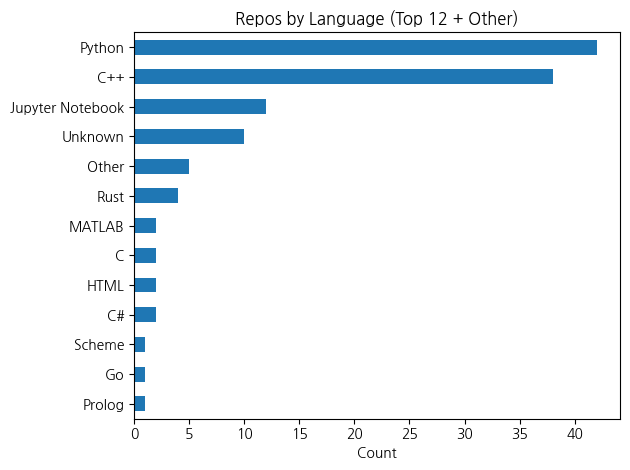

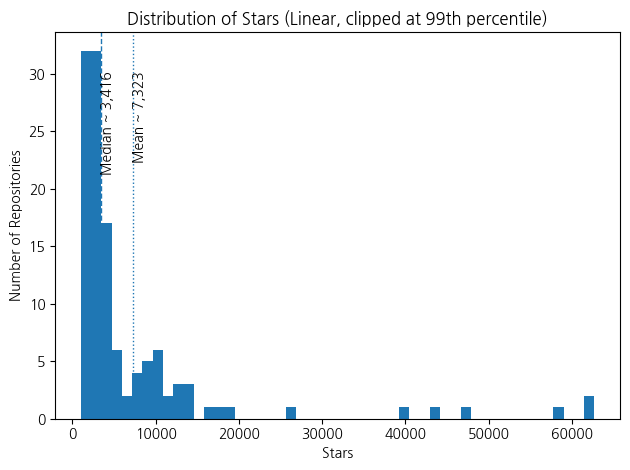

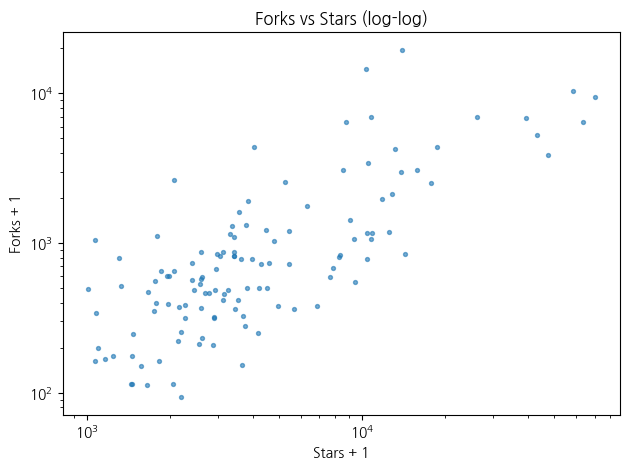

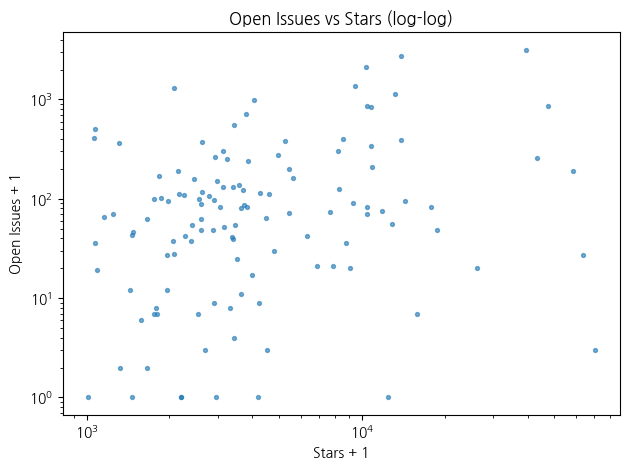

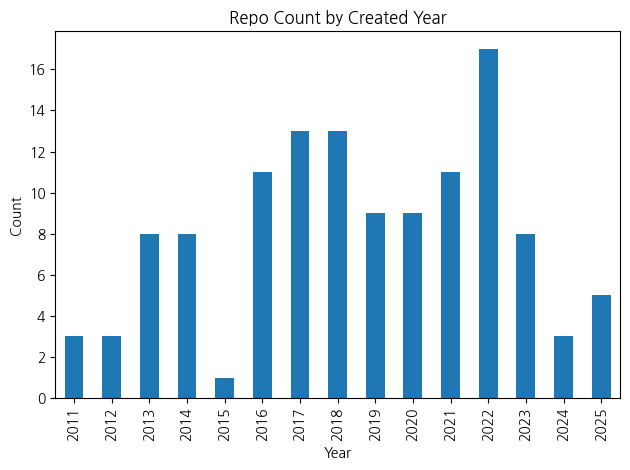

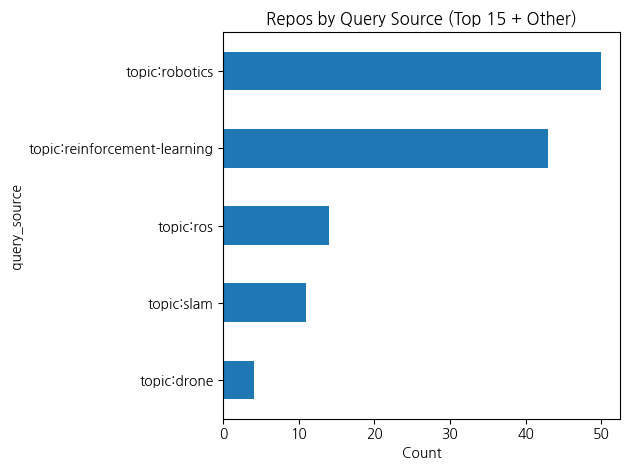

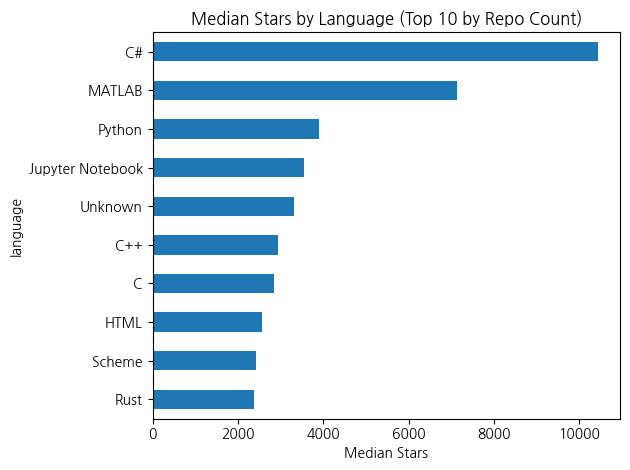

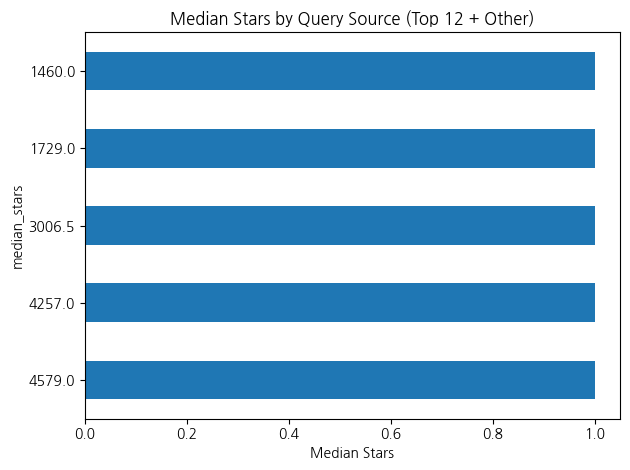

,total_repos,languages_unique,query_sources_unique,stars_median,stars_mean,forks_median,open_issues_median
0,122,17,5,3416.5,7393.745902,662.5,73.5


,repos,stars_median,stars_mean
language,,,
Python,42,3896.5,9964.261905
C++,38,2946.0,4083.552632
Jupyter Notebook,12,3552.5,7065.333333
Unknown,10,3313.5,9962.300000
Rust,4,2387.0,3865.500000
C,2,2851.0,2851.000000
MATLAB,2,7123.5,7123.500000
HTML,2,2553.5,2553.500000
C#,2,10428.5,10428.500000


,repos,stars_median
query_source,,
topic:robotics,50,3006.5
topic:reinforcement-learning,43,4579.0
topic:ros,14,1729.0
topic:slam,11,1460.0
topic:drone,4,4257.0


In [6]:
# ============================================================
# 📊 base로 의미 있는 분석 그래프 (로그 OFF 기본, 옵션 토글)
# - Language 분포/언어별 Stars 중앙값
# - Stars 분포 (선형 기본, p99 클리핑 + 중앙값/평균선)
# - (옵션) Stars 분포 (log10)
# - Forks vs Stars (log-log)
# - Open Issues vs Stars (log-log)
# - Created Year 분포
# - Query Source 분포
# - (추가) Query Source별 Median Stars
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 옵션 스위치 ----
SHOW_LINEAR_STARS = True     # 선형 히스토그램 표시 (기본)
SHOW_LOG_STARS    = False    # 로그 히스토그램 추가로 표시할지

# --- 안전 가드: 필요한 컬럼 체크 ---
required = {"full_name","language","stargazers_count","forks_count","open_issues_count","created_at","query_source"}
missing = required - set(base.columns)
assert not missing, f"base에 필요한 컬럼이 없습니다: {missing}"

# --- 정리 ---
df = base.copy()
for c in ["stargazers_count","forks_count","open_issues_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
df["language"] = df["language"].fillna("Unknown").replace("", "Unknown")
if "query_source" not in df.columns:
    df["query_source"] = "(unknown)"
df["query_source"] = df["query_source"].fillna("(unknown)")

def top_with_other(s: pd.Series, top_n=12, other="Other"):
    vc = s.value_counts(dropna=False)
    if len(vc) <= top_n:
        return vc
    return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

# 1) Language 분포 (Top 12 + Other)
lang_counts = top_with_other(df["language"], top_n=12)
plt.figure()
lang_counts.sort_values().plot(kind="barh")
plt.title("Repos by Language (Top 12 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 2) Stars 분포 (선형, 상위 1% 클리핑 + 중앙값/평균선)
if SHOW_LINEAR_STARS:
    p99 = df["stargazers_count"].quantile(0.99)  # 극단치 꼬리 잘라 시각화 안정화
    stars_clip = df["stargazers_count"].clip(upper=p99)
    median_val = float(stars_clip.median())
    mean_val   = float(stars_clip.mean())

    plt.figure()
    plt.hist(stars_clip, bins=50)
    plt.title("Distribution of Stars (Linear, clipped at 99th percentile)")
    plt.xlabel("Stars")
    plt.ylabel("Number of Repositories")
    # 중앙값/평균 보조선
    plt.axvline(median_val, linestyle="--", linewidth=1)
    plt.text(median_val, plt.ylim()[1]*0.9, f"Median ~ {int(median_val):,}", rotation=90, va="top")
    plt.axvline(mean_val, linestyle=":", linewidth=1)
    plt.text(mean_val, plt.ylim()[1]*0.9, f"Mean ~ {int(mean_val):,}", rotation=90, va="top")
    plt.tight_layout()
    plt.show()

# (옵션) 2-1) Stars 분포 (log10)
if SHOW_LOG_STARS:
    log_stars = np.log10(df["stargazers_count"].astype(float) + 1.0)
    plt.figure()
    plt.hist(log_stars, bins=30)
    plt.title("Distribution of log10(Stars + 1)")
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3) Forks vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["forks_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Forks vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Forks + 1")
plt.tight_layout()
plt.show()

# 4) Open Issues vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["open_issues_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Open Issues vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Open Issues + 1")
plt.tight_layout()
plt.show()

# 5) Created_at 연도 분포
year_counts = df["created_at"].dt.year.dropna().value_counts().sort_index()
plt.figure()
year_counts.plot(kind="bar")
plt.title("Repo Count by Created Year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6) Query Source 분포 (Top 15 + Other)
qs_counts = top_with_other(df["query_source"], top_n=15)
plt.figure()
qs_counts.sort_values().plot(kind="barh")
plt.title("Repos by Query Source (Top 15 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 7) 언어별 Stars 중앙값 (Top 10 언어 기준)
top_langs = df["language"].value_counts().head(10).index.tolist()
med_stars_by_lang = (df[df["language"].isin(top_langs)]
                     .groupby("language")["stargazers_count"]
                     .median()
                     .sort_values())
plt.figure()
med_stars_by_lang.plot(kind="barh")
plt.title("Median Stars by Language (Top 10 by Repo Count)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# 8) (추가) Query Source별 Median Stars (Top 12)
qs_med = (df.groupby("query_source")["stargazers_count"]
            .median()
            .sort_values(ascending=False))
qs_med = top_with_other(qs_med.rename("median_stars"), top_n=12)
plt.figure()
qs_med.sort_values().plot(kind="barh")
plt.title("Median Stars by Query Source (Top 12 + Other)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# (옵션) 간단 요약 테이블 출력
summary = {
    "total_repos": len(df),
    "languages_unique": df["language"].nunique(),
    "query_sources_unique": df["query_source"].nunique(),
    "stars_median": float(df["stargazers_count"].median()),
    "stars_mean": float(df["stargazers_count"].mean()),
    "forks_median": float(df["forks_count"].median()),
    "open_issues_median": float(df["open_issues_count"].median()),
}
display(pd.DataFrame([summary]))

display(
    (df.groupby("language")
       .agg(repos=("full_name","count"),
            stars_median=("stargazers_count","median"),
            stars_mean=("stargazers_count","mean"))
       .sort_values("repos", ascending=False)
       .head(15))
)

display(
    (df.groupby("query_source")
       .agg(repos=("full_name","count"),
            stars_median=("stargazers_count","median"))
       .sort_values("repos", ascending=False)
       .head(15))
)


### (추가) 3가지 “Top N 선정 기준”을 전부 출력
Count 기준(기존 FIXED 버전 유지)

Recent 기준: 최근 RECENT_DAYS일 내 활동(pushed_at/updated_at/commit 기준, 없으면 created_at) 많은 Query Source 상위 12개

Stars 기준: Query Source별 총 Stars 합이 큰 순서 상위 12개

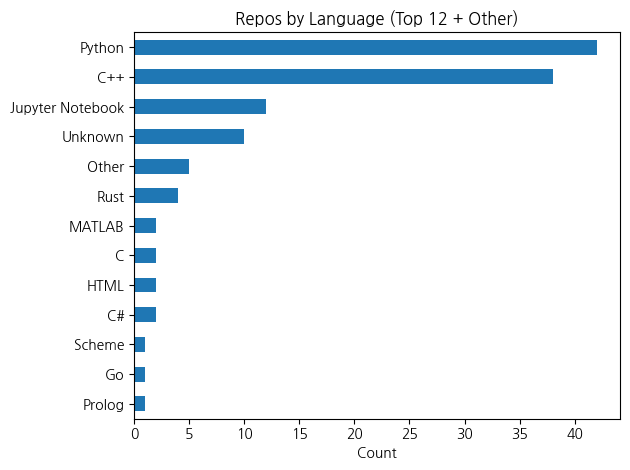

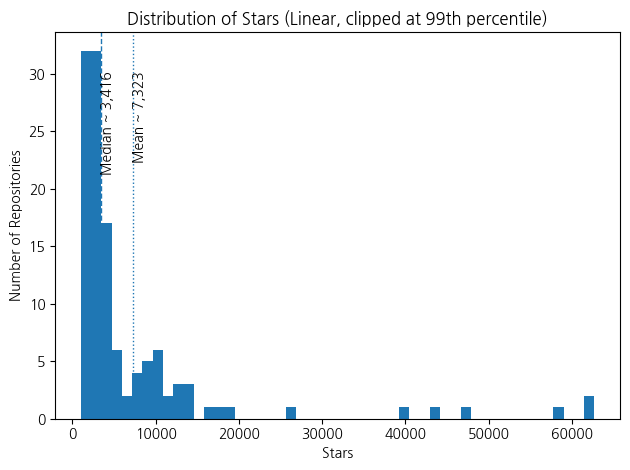

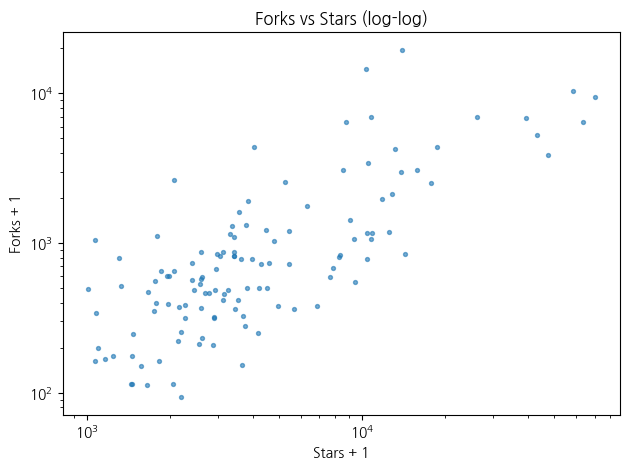

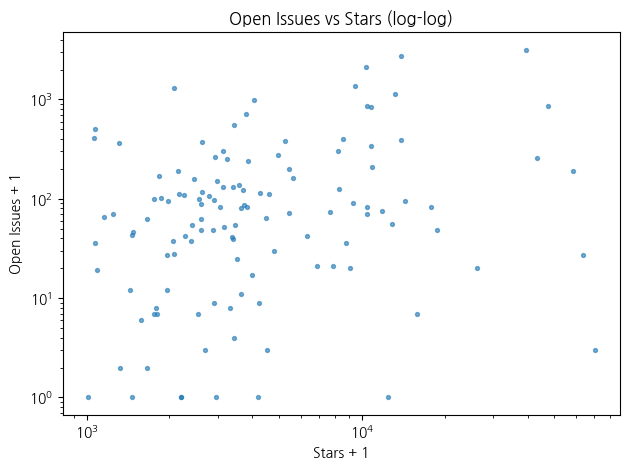

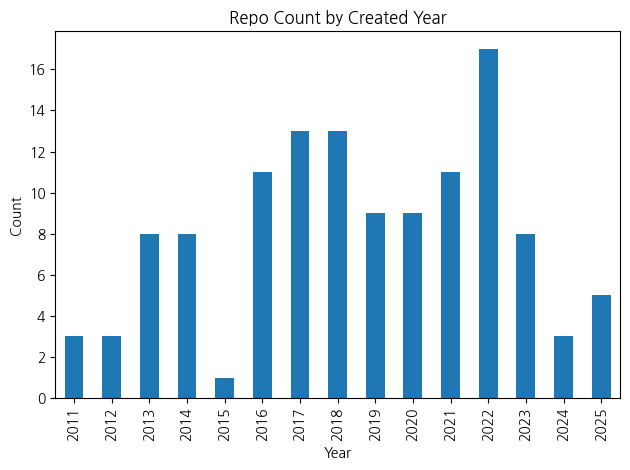

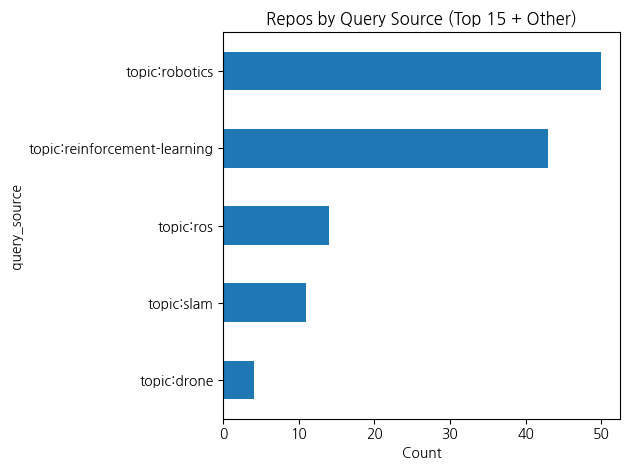

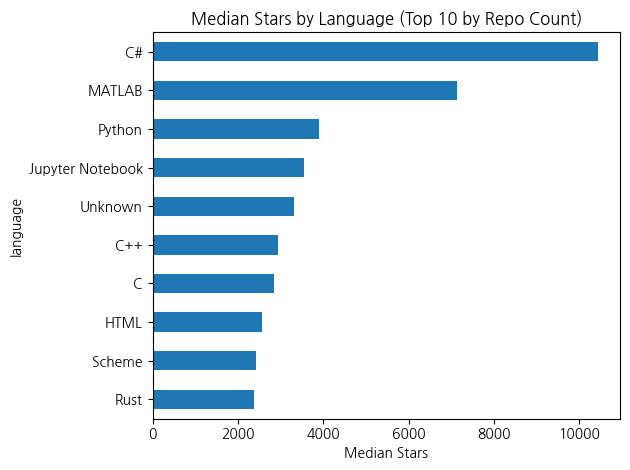

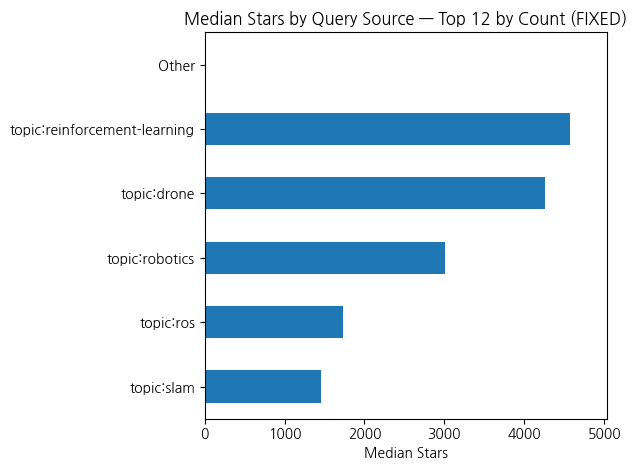

<Figure size 600x450 with 0 Axes>

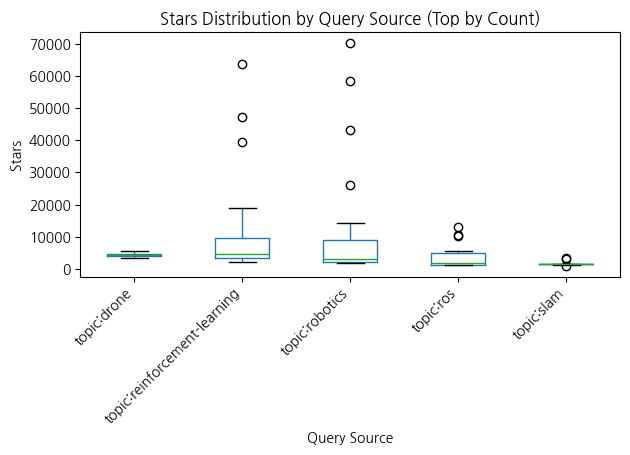

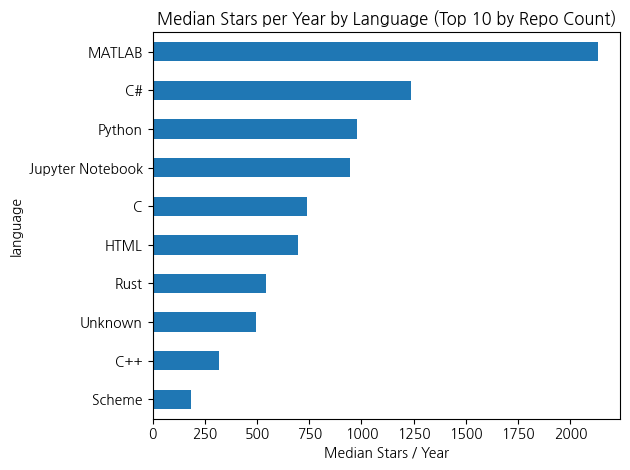

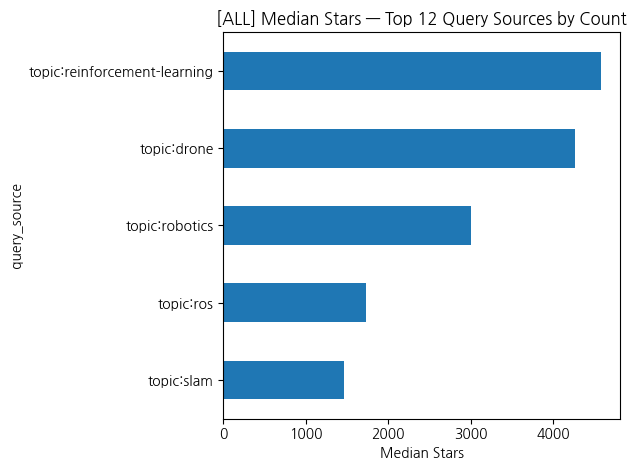

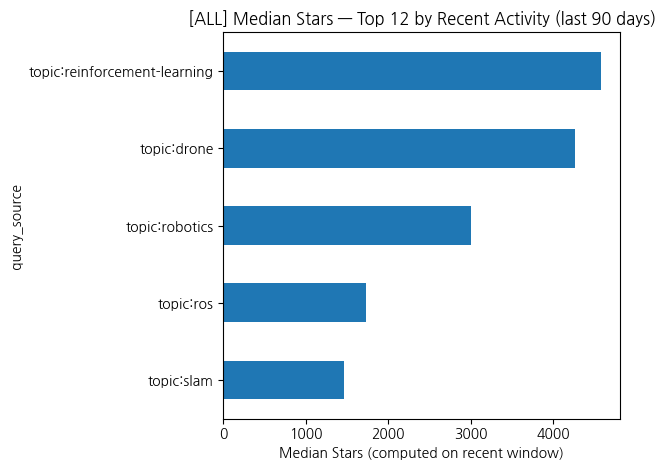

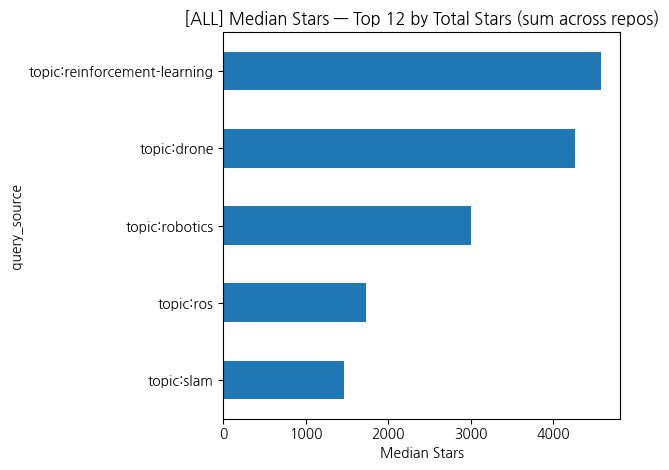

,Count_Top,Recent_Top,TotalStars_Top
0,topic:robotics,topic:robotics,topic:robotics
1,topic:reinforcement-learning,topic:reinforcement-learning,topic:reinforcement-learning
2,topic:ros,topic:ros,topic:ros
3,topic:slam,topic:slam,topic:slam
4,topic:drone,topic:drone,topic:drone


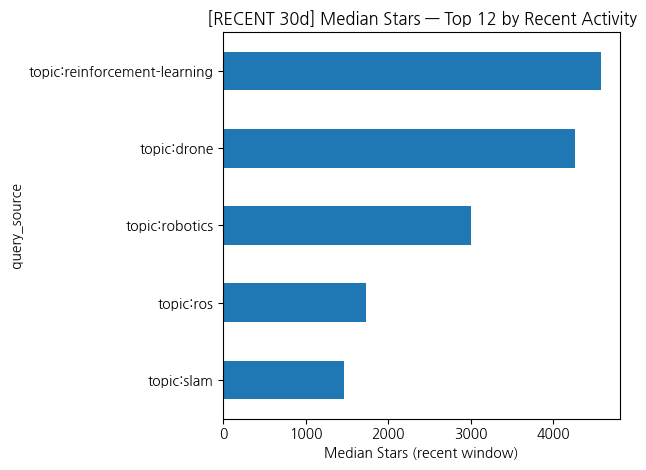

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


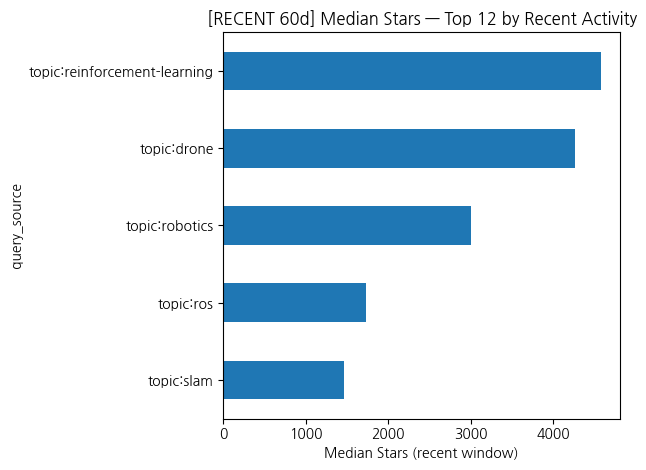

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


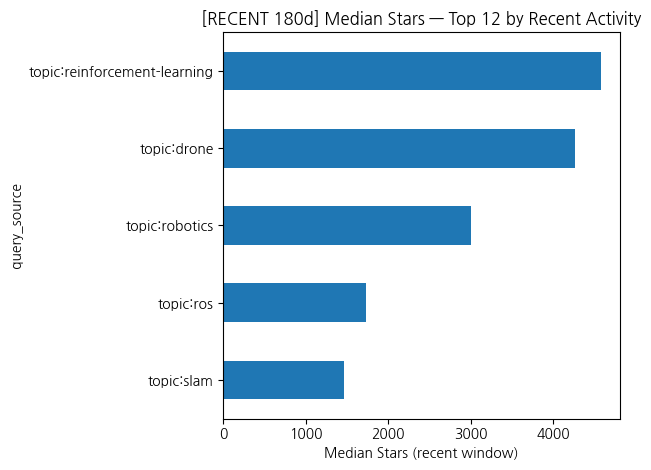

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
0,topic:robotics,topic:robotics,topic:robotics
1,topic:reinforcement-learning,topic:reinforcement-learning,topic:reinforcement-learning
2,topic:ros,topic:ros,topic:ros
3,topic:slam,topic:slam,topic:slam
4,topic:drone,topic:drone,topic:drone


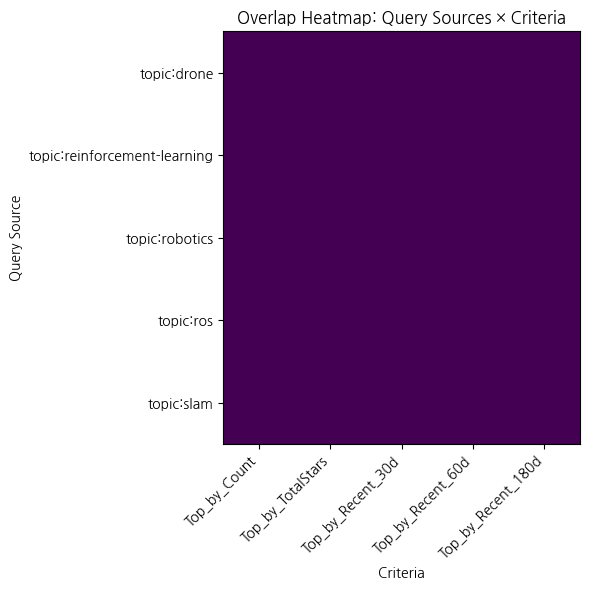

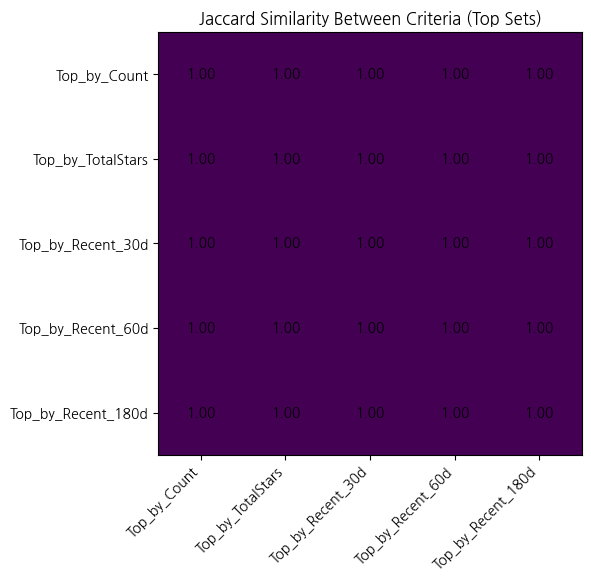

,Top_by_Count,Top_by_TotalStars,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
Top_by_Count,1.00,1.00,1.00,1.00,1.00
Top_by_TotalStars,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_30d,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_60d,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_180d,1.00,1.00,1.00,1.00,1.00


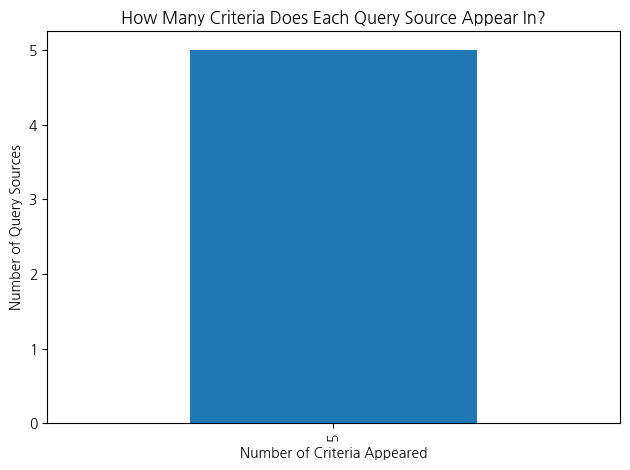

,Top_by_Count,Top_by_TotalStars,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
topic:drone,1,1,1,1,1
topic:reinforcement-learning,1,1,1,1,1
topic:robotics,1,1,1,1,1
topic:ros,1,1,1,1,1
topic:slam,1,1,1,1,1



================  ✅ 교집합 후보 (기준 2+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


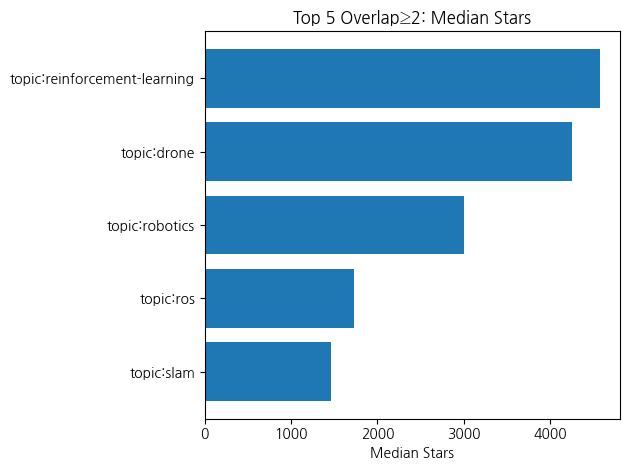


================  ✅ 교집합 후보 (기준 3+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


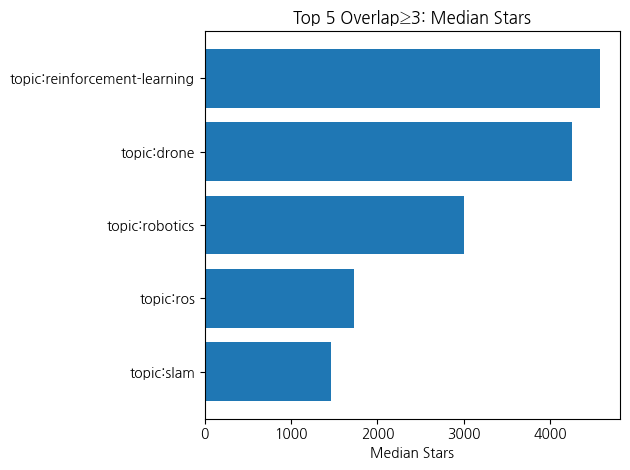


================  ✅ 교집합 후보 (기준 4+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


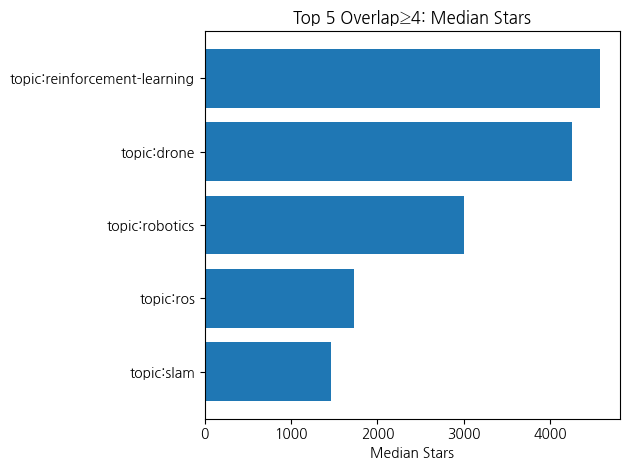


📌 임계치별 교집합 후보 개수 요약


,min_criteria,num_candidates
0,2,5
1,3,5
2,4,5


,repos_total,languages_unique,query_sources_included,stars_median,stars_mean,forks_median,open_issues_median,last_active_max
0,122,17,5,3416.5,7393.745902,662.5,73.5,2025-10-24 06:09:46+00:00


,full_name,html_url,stargazers_count,forks_count,open_issues_count,language,query_source,last_active,description
0,Developer-Y/cs-video-courses,,70098,9412,2,Unknown,topic:robotics,2025-10-24 04:35:17+00:00,List of Computer Science courses with video le...
99,labmlai/annotated_deep_learning_paper_implemen...,,63801,6465,26,Python,topic:reinforcement-learning,2025-10-24 05:48:17+00:00,🧑‍🏫 60+ Implementations/tutorials of deep lear...
1,commaai/openpilot,,58519,10350,191,Python,topic:robotics,2025-10-24 05:45:39+00:00,openpilot is an operating system for robotics....
100,unslothai/unsloth,,47347,3869,853,Python,topic:reinforcement-learning,2025-10-24 05:47:07+00:00,Fine-tuning & Reinforcement Learning for LLMs....
2,NaiboWang/EasySpider,,43151,5303,254,JavaScript,topic:robotics,2025-10-24 04:14:12+00:00,A visual no-code/code-free web crawler/spider易...
101,ray-project/ray,,39470,6820,3170,Python,topic:reinforcement-learning,2025-10-24 06:03:33+00:00,Ray is an AI compute engine. Ray consists of a...
3,AtsushiSakai/PythonRobotics,,26111,6911,19,Python,topic:robotics,2025-10-24 02:26:25+00:00,Python sample codes and textbook for robotics ...
102,Unity-Technologies/ml-agents,,18778,4377,47,C#,topic:reinforcement-learning,2025-10-24 02:28:41+00:00,The Unity Machine Learning Agents Toolkit (ML-...
103,AI4Finance-Foundation/FinGPT,,17863,2528,81,Jupyter Notebook,topic:reinforcement-learning,2025-10-24 04:13:14+00:00,FinGPT: Open-Source Financial Large Language M...
104,datawhalechina/leedl-tutorial,,15901,3075,6,Jupyter Notebook,topic:reinforcement-learning,2025-10-24 05:27:45+00:00,《李宏毅深度学习教程》（李宏毅老师推荐👍，苹果书🍎），PDF下载地址：https://git...


,full_name,html_url,stargazers_count,forks_count,open_issues_count,language,query_source,last_active,description
7,DLR-RM/stable-baselines3,,11848,1965,74,Python,topic:robotics,2025-10-24 06:09:46+00:00,"PyTorch version of Stable Baselines, reliable ..."
31,DLR-RM/rl-baselines3-zoo,,2593,570,62,Python,topic:robotics,2025-10-24 06:08:40+00:00,A training framework for Stable Baselines3 rei...
124,google-deepmind/dm_control,,4280,721,114,Python,topic:reinforcement-learning,2025-10-24 06:06:19+00:00,Google DeepMind's software stack for physics-b...
87,Vincentqyw/cv-arxiv-daily,,1324,516,1,Python,topic:slam,2025-10-24 06:05:01+00:00,🎓Automatically Update CV Papers Daily using Gi...
101,ray-project/ray,,39470,6820,3170,Python,topic:reinforcement-learning,2025-10-24 06:03:33+00:00,Ray is an AI compute engine. Ray consists of a...
120,InternLM/xtuner,,4946,379,274,Python,topic:reinforcement-learning,2025-10-24 06:02:29+00:00,A Next-Generation Training Engine Built for Ul...
42,ARISE-Initiative/robosuite,,1979,603,95,Python,topic:robotics,2025-10-24 05:58:51+00:00,robosuite: A Modular Simulation Framework and ...
111,wandb/wandb,,10442,784,868,Python,topic:reinforcement-learning,2025-10-24 05:55:31+00:00,The AI developer platform. Use Weights & Biase...
8,google-deepmind/mujoco,,10912,1158,208,C++,topic:robotics,2025-10-24 05:51:52+00:00,Multi-Joint dynamics with Contact. A general p...
43,PRBonn/kiss-icp,,1964,392,11,C++,topic:robotics,2025-10-24 05:51:06+00:00,A LiDAR odometry pipeline that just works


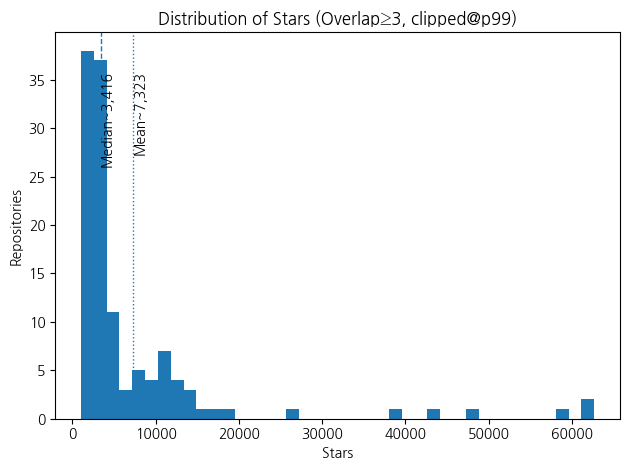

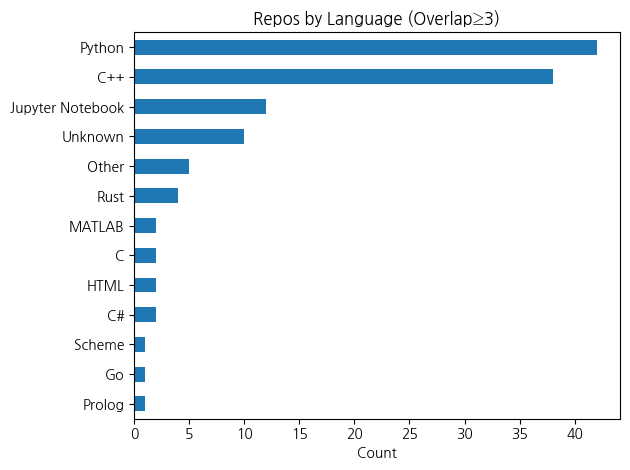

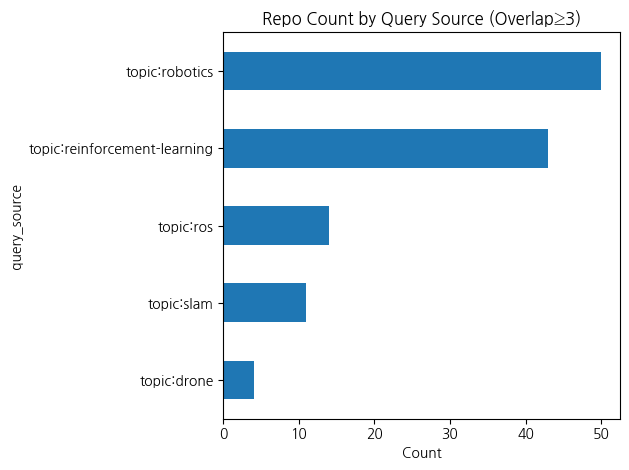

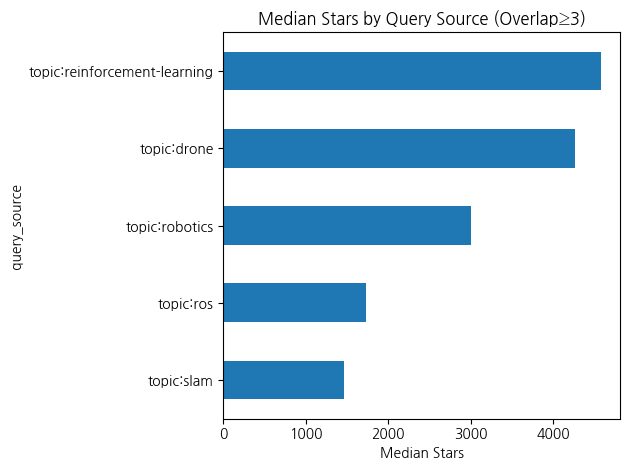

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


📁 Saved:
 - ./reports/overlap_report_K3_all_repos.csv
 - ./reports/overlap_report_K3_qs_stats.csv
 - ./reports/overlap_report_K3.md


In [7]:
# ============================================================
# 📊 base로 의미 있는 분석 그래프 (로그 OFF 기본)
# - Language 분포/언어별 Stars 중앙값
# - Stars 분포 (선형 기본, p99 클리핑 + 중앙값/평균선)
# - (옵션) Stars 분포 (log10)
# - Forks vs Stars (log-log)
# - Open Issues vs Stars (log-log)
# - Created Year 분포
# - Query Source 분포
# - (레거시) Query Source별 Median Stars  [원본 유지, 기본 OFF]
# - (수정)   Query Source별 Median Stars  [버그 FIX, 기본 ON, Count 기준]
# - (추가)   Query Source별 Stars 분포(Boxplot, Top N=12)
# - (추가)   언어별 Stars/Year 중앙값 (나이 보정)
# - (신규)   Query Source별 Median Stars — 3가지 Top 선정 기준 모두 출력
#             ① Count 기준 ② Recent 기준(최근 N일) ③ Stars 합 기준
# - (신규)   Recent 윈도우 세트 30/60/180일: 각 윈도우별 그래프/표
# - (신규)   Overlap 시각화(히트맵/자카드/중복도)
# - (신규)   교집합 자동 추출(≥2/≥3/≥4 기준 동시 포함) + 하이라이트 그래프
# - (신규)   교집합 후보 대시보드/리포트(CSV/Markdown 저장)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 옵션 스위치 ----
SHOW_LINEAR_STARS = True
SHOW_LOG_STARS    = False

SHOW_QS_MED_LEGACY = False      # 레거시 예시가 필요할 때만 True
SHOW_QS_MED_FIXED  = True       # Count 기준(FIXED) 기본 ON
SHOW_QS_BOXPLOT    = True       # Query Source별 Stars 분포
QS_BOXPLOT_TOPN    = 12

SHOW_LANG_STARS_PER_YEAR = True # 언어별 Stars/Year 중앙값

# ---- 공통 파라미터 ----
RECENT_DAYS = 90                # Recent 기준: 최근 N일
TOP_K = 12                      # 모든 Top 그래프 공통 Top K
RECENT_WINDOWS = [30, 60, 180]  # 발표용 최근 윈도우 세트

# --- 안전 가드: 필요한 컬럼 체크 ---
required = {"full_name","language","stargazers_count","forks_count","open_issues_count","created_at","query_source"}
missing = required - set(base.columns)
assert not missing, f"base에 필요한 컬럼이 없습니다: {missing}"

# --- 정리 ---
df = base.copy()

# 수치형 보정
for c in ["stargazers_count","forks_count","open_issues_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# ✅ 날짜 컬럼 보정 (없어도 datetime64[ns, UTC] dtype으로 생성)
for dtcol in ["created_at","updated_at","pushed_at","last_commit_at"]:
    if dtcol not in df.columns:
        df[dtcol] = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns, UTC]")
    else:
        df[dtcol] = pd.to_datetime(df[dtcol], errors="coerce", utc=True)

# 마지막 활동 시각(last_active): pushed_at > updated_at > last_commit_at > created_at
df["last_active"] = df[["pushed_at","updated_at","last_commit_at","created_at"]].max(axis=1)

df["language"] = df["language"].fillna("Unknown").replace("", "Unknown")
if "query_source" not in df.columns:
    df["query_source"] = "(unknown)"
df["query_source"] = df["query_source"].fillna("(unknown)")

# --- 유틸: 카테고리 시리즈 전용 Top N + Other ---
def top_with_other_categories(s: pd.Series, top_n=12, other="Other"):
    vc = s.value_counts(dropna=False)
    if len(vc) <= top_n:
        return vc
    return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

# 1) Language 분포 (Top 12 + Other)
lang_counts = top_with_other_categories(df["language"], top_n=12)
plt.figure()
lang_counts.sort_values().plot(kind="barh")
plt.title("Repos by Language (Top 12 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 2) Stars 분포 (선형, 상위 1% 클리핑 + 중앙값/평균선)
if SHOW_LINEAR_STARS:
    p99 = df["stargazers_count"].quantile(0.99)
    stars_clip = df["stargazers_count"].clip(upper=p99)
    median_val = float(stars_clip.median())
    mean_val   = float(stars_clip.mean())

    plt.figure()
    plt.hist(stars_clip, bins=50)
    plt.title("Distribution of Stars (Linear, clipped at 99th percentile)")
    plt.xlabel("Stars")
    plt.ylabel("Number of Repositories")
    plt.axvline(median_val, linestyle="--", linewidth=1)
    ymax = plt.ylim()[1]
    plt.text(median_val, ymax*0.9, f"Median ~ {int(median_val):,}", rotation=90, va="top")
    plt.axvline(mean_val, linestyle=":", linewidth=1)
    plt.text(mean_val, ymax*0.9, f"Mean ~ {int(mean_val):,}", rotation=90, va="top")
    plt.tight_layout()
    plt.show()

# (옵션) 2-1) Stars 분포 (log10)
if SHOW_LOG_STARS:
    log_stars = np.log10(df["stargazers_count"].astype(float) + 1.0)
    plt.figure()
    plt.hist(log_stars, bins=30)
    plt.title("Distribution of log10(Stars + 1)")
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3) Forks vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["forks_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Forks vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Forks + 1")
plt.tight_layout()
plt.show()

# 4) Open Issues vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["open_issues_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Open Issues vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Open Issues + 1")
plt.tight_layout()
plt.show()

# 5) Created_at 연도 분포
year_counts = df["created_at"].dt.year.dropna().value_counts().sort_index()
plt.figure()
year_counts.plot(kind="bar")
plt.title("Repo Count by Created Year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6) Query Source 분포 (Top 15 + Other)
qs_counts_all = top_with_other_categories(df["query_source"], top_n=15)
plt.figure()
qs_counts_all.sort_values().plot(kind="barh")
plt.title("Repos by Query Source (Top 15 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 7) 언어별 Stars 중앙값 (Top 10 언어 기준)
top_langs = df["language"].value_counts().head(10).index.tolist()
med_stars_by_lang = (df[df["language"].isin(top_langs)]
                     .groupby("language")["stargazers_count"]
                     .median()
                     .sort_values())
plt.figure()
med_stars_by_lang.plot(kind="barh")
plt.title("Median Stars by Language (Top 10 by Repo Count)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# 8-LEGACY) Query Source별 Median Stars (원본 방식)  ⚠️ 데모용
if SHOW_QS_MED_LEGACY:
    qs_med_legacy = (df.groupby("query_source")["stargazers_count"]
                       .median()
                       .sort_values(ascending=False))
    plt.figure()
    qs_med_legacy.sort_values().plot(kind="barh")
    plt.title("[LEGACY] Median Stars by Query Source (raw)")
    plt.xlabel("Median Stars")
    plt.tight_layout()
    plt.show()

# 8-FIXED) Query Source별 Median Stars — Count 기준(기존 FIXED)
if SHOW_QS_MED_FIXED:
    qs_counts = df["query_source"].value_counts()
    top_qs_by_count = qs_counts.index[:TOP_K]
    df_top = df[df["query_source"].isin(top_qs_by_count)]
    df_other = df[~df["query_source"].isin(top_qs_by_count)]
    qs_med_top = (df_top.groupby("query_source")["stargazers_count"].median())
    other_med = df_other["stargazers_count"].median() if len(df_other) > 0 else np.nan
    qs_med_fixed = pd.concat([qs_med_top, pd.Series({"Other": other_med})]).sort_values()

    plt.figure()
    qs_med_fixed.plot(kind="barh")
    plt.title(f"Median Stars by Query Source — Top {TOP_K} by Count (FIXED)")
    plt.xlabel("Median Stars")
    xmax = float(np.nanmax(qs_med_fixed.values))
    plt.xlim(0, xmax * 1.1 if np.isfinite(xmax) else None)
    plt.tight_layout()
    plt.show()

# (추가) 8B) Query Source별 Stars 분포(Boxplot, Top N by Count)
if SHOW_QS_BOXPLOT:
    topN = df["query_source"].value_counts().head(QS_BOXPLOT_TOPN).index
    dbox = df[df["query_source"].isin(topN)].copy()
    plt.figure(figsize=(max(6, len(topN) * 0.6), 4.5))
    dbox.boxplot(column="stargazers_count", by="query_source", grid=False, vert=True)
    plt.title("Stars Distribution by Query Source (Top by Count)")
    plt.suptitle("")
    plt.xlabel("Query Source"); plt.ylabel("Stars")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# (추가) 7B) 언어별 Stars/Year 중앙값 (나이 보정)
if SHOW_LANG_STARS_PER_YEAR:
    age_years = (pd.Timestamp.now(tz="UTC") - df["created_at"]).dt.days / 365.25
    age_years = age_years.clip(lower=0.25)
    df["_stars_per_year"] = df["stargazers_count"] / age_years

    top_langs_age = df["language"].value_counts().head(10).index.tolist()
    med_spy_by_lang = (df[df["language"].isin(top_langs_age)]
                       .groupby("language")["_stars_per_year"]
                       .median()
                       .sort_values())
    plt.figure()
    med_spy_by_lang.plot(kind="barh")
    plt.title("Median Stars per Year by Language (Top 10 by Repo Count)")
    plt.xlabel("Median Stars / Year")
    plt.tight_layout()
    plt.show()

# ================================
# 🚀 신규: 3가지 Top 선정 기준 모두 출력
# ================================
now_utc = pd.Timestamp.now(tz="UTC")
recent_cut = now_utc - pd.Timedelta(days=RECENT_DAYS)
df_recent = df[df["last_active"].notna() & (df["last_active"] >= recent_cut)].copy()

# ① Count 기준
qs_by_count = df["query_source"].value_counts()
top_count = qs_by_count.head(TOP_K).index
med_by_count = (df[df["query_source"].isin(top_count)]
                .groupby("query_source")["stargazers_count"]
                .median()
                .sort_values())
plt.figure()
med_by_count.plot(kind="barh")
plt.title(f"[ALL] Median Stars — Top {TOP_K} Query Sources by Count")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# ② Recent 기준
if len(df_recent) > 0:
    qs_by_recent_cnt = df_recent["query_source"].value_counts()
    top_recent = qs_by_recent_cnt.head(TOP_K).index
    med_by_recent = (df_recent[df_recent["query_source"].isin(top_recent)]
                     .groupby("query_source")["stargazers_count"]
                     .median()
                     .sort_values())
    plt.figure()
    med_by_recent.plot(kind="barh")
    plt.title(f"[ALL] Median Stars — Top {TOP_K} by Recent Activity (last {RECENT_DAYS} days)")
    plt.xlabel("Median Stars (computed on recent window)")
    plt.tight_layout()
    plt.show()
else:
    print(f"[INFO] 최근 {RECENT_DAYS}일 내 last_active 데이터가 없어 'Recent' 기준 그래프를 생략합니다.")
    top_recent = pd.Index([])

# ③ Stars 합 기준
stars_by_qs_sum = df.groupby("query_source")["stargazers_count"].sum().sort_values(ascending=False)
top_stars_sum = stars_by_qs_sum.head(TOP_K).index
med_by_stars_sum = (df[df["query_source"].isin(top_stars_sum)]
                    .groupby("query_source")["stargazers_count"]
                    .median()
                    .sort_values())
plt.figure()
med_by_stars_sum.plot(kind="barh")
plt.title(f"[ALL] Median Stars — Top {TOP_K} by Total Stars (sum across repos)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# 비교 테이블
compare_top_final = pd.DataFrame({"Count_Top": list(top_count)})
if len(top_recent) > 0:
    compare_top_final["Recent_Top"] = list(top_recent)
compare_top_final["TotalStars_Top"] = list(top_stars_sum)
display(compare_top_final)

# ================================
# 🆕 Recent 윈도우 세트: 30/60/180일
# ================================
def plot_recent_window(df_in, window_days: int, top_k: int = TOP_K):
    now_utc_ = pd.Timestamp.now(tz="UTC")
    recent_cut_ = now_utc_ - pd.Timedelta(days=window_days)
    df_recent_ = df_in[df_in["last_active"].notna() & (df_in["last_active"] >= recent_cut_)].copy()

    if len(df_recent_) == 0:
        print(f"[INFO] 최근 {window_days}일 내 last_active 데이터가 없어 스킵합니다.")
        return None

    qs_by_recent_cnt_ = df_recent_["query_source"].value_counts()
    top_recent_ = qs_by_recent_cnt_.head(top_k).index

    med_by_recent_ = (df_recent_[df_recent_["query_source"].isin(top_recent_)]
                      .groupby("query_source")["stargazers_count"]
                      .median()
                      .sort_values())

    plt.figure()
    med_by_recent_.plot(kind="barh")
    plt.title(f"[RECENT {window_days}d] Median Stars — Top {top_k} by Recent Activity")
    plt.xlabel("Median Stars (recent window)")
    plt.tight_layout()
    plt.show()

    summary_recent_ = (df_recent_[df_recent_["query_source"].isin(top_recent_)]
                       .groupby("query_source")
                       .agg(repos=("full_name","count"),
                            stars_median=("stargazers_count","median"),
                            stars_mean=("stargazers_count","mean"))
                       .sort_values("repos", ascending=False))
    display(summary_recent_)

    return list(top_recent_)

tops_by_window = {}
for w in RECENT_WINDOWS:
    tops_by_window[w] = plot_recent_window(df, w, TOP_K)

# 윈도우별 Top 비교표
max_len = max(len(tops_by_window[w]) if tops_by_window[w] is not None else 0 for w in RECENT_WINDOWS)
compare = pd.DataFrame({
    f"Top_by_Recent_{w}d": (tops_by_window[w] + [""] * (max_len - len(tops_by_window[w])))
                           if tops_by_window[w] is not None else [""] * max_len
    for w in RECENT_WINDOWS
})
display(compare)

# ================================
# 🧩 Overlap 시각화 (히트맵/자카드/중복도)
# ================================
def ensure_top_count(df_in, top_k=TOP_K):
    return list(df_in["query_source"].value_counts().head(top_k).index)

def ensure_top_total_stars(df_in, top_k=TOP_K):
    return list(df_in.groupby("query_source")["stargazers_count"].sum()
                .sort_values(ascending=False).head(top_k).index)

def ensure_tops_by_window(df_in, windows=RECENT_WINDOWS, top_k=TOP_K):
    out = {}
    for w in windows:
        now_utc_ = pd.Timestamp.now(tz="UTC")
        cut_ = now_utc_ - pd.Timedelta(days=w)
        df_r_ = df_in[df_in["last_active"].notna() & (df_in["last_active"] >= cut_)]
        out[w] = list(df_r_["query_source"].value_counts().head(top_k).index) if len(df_r_) > 0 else []
    return out

top_count = ensure_top_count(df, TOP_K)
top_stars_sum = ensure_top_total_stars(df, TOP_K)
tops_by_window = ensure_tops_by_window(df, RECENT_WINDOWS, TOP_K)

sets_dict = {
    "Top_by_Count": set(top_count),
    "Top_by_TotalStars": set(top_stars_sum),
}
for w in RECENT_WINDOWS:
    sets_dict[f"Top_by_Recent_{w}d"] = set(tops_by_window.get(w, []) or [])

all_items = sorted(set().union(*sets_dict.values()))
criteria = list(sets_dict.keys())

overlap_mat = pd.DataFrame(
    {crit: [1 if item in sets_dict[crit] else 0 for item in all_items] for crit in criteria},
    index=all_items
)

# Heatmap
plt.figure(figsize=(max(6, len(criteria) * 1.2), max(6, len(all_items) * 0.25)))
plt.imshow(overlap_mat.values, aspect='auto')
plt.title("Overlap Heatmap: Query Sources × Criteria")
plt.xlabel("Criteria"); plt.ylabel("Query Source")
plt.xticks(range(len(criteria)), criteria, rotation=45, ha="right")
plt.yticks(range(len(all_items)), all_items)
plt.tight_layout()
plt.show()

# Jaccard
def jaccard(a: set, b: set) -> float:
    if len(a) == 0 and len(b) == 0:
        return 1.0
    inter = len(a & b); union = len(a | b)
    return inter / union if union > 0 else 0.0

jacc = pd.DataFrame(index=criteria, columns=criteria, dtype=float)
for i, ci in enumerate(criteria):
    for j, cj in enumerate(criteria):
        jacc.iloc[i, j] = jaccard(sets_dict[ci], sets_dict[cj])

plt.figure(figsize=(max(6, len(criteria)), max(6, len(criteria))))
plt.imshow(jacc.values, aspect='equal')
plt.title("Jaccard Similarity Between Criteria (Top Sets)")
plt.xticks(range(len(criteria)), criteria, rotation=45, ha="right")
plt.yticks(range(len(criteria)), criteria)
for i in range(len(criteria)):
    for j in range(len(criteria)):
        plt.text(j, i, f"{jacc.values[i, j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()
display(jacc.style.format("{:.2f}"))

# 중복도 분포
dup_counts = overlap_mat.sum(axis=1)
dup_hist = dup_counts.value_counts().sort_index()
plt.figure()
dup_hist.plot(kind="bar")
plt.title("How Many Criteria Does Each Query Source Appear In?")
plt.xlabel("Number of Criteria Appeared"); plt.ylabel("Number of Query Sources")
plt.tight_layout()
plt.show()

overlap_sorted = overlap_mat.assign(_sum=overlap_mat.sum(axis=1)).sort_values("_sum", ascending=False).drop(columns="_sum")
display(overlap_sorted)

# ================================
# 🏅 교집합 자동 추출(≥2/≥3/≥4) + 하이라이트
# ================================
def summarize_candidates(df_in, items):
    sub = df_in[df_in["query_source"].isin(items)].copy()
    agg = (sub.groupby("query_source")
           .agg(repos=("full_name","count"),
                stars_sum=("stargazers_count","sum"),
                stars_mean=("stargazers_count","mean"),
                stars_median=("stargazers_count","median"),
                last_active_max=("last_active","max"),
                languages_uniq=("language","nunique")))
    crit_cols = []
    for crit in criteria:
        col = f"in_{crit}"
        agg[col] = overlap_mat.loc[agg.index, crit].astype(int).reindex(agg.index).fillna(0).astype(int)
        crit_cols.append(col)
    agg["overlap_count"] = agg[crit_cols].sum(axis=1)
    agg["included_criteria"] = [
        ", ".join([c for c in criteria if overlap_mat.loc[item, c] == 1])
        for item in agg.index
    ]
    return agg.sort_values(by=["overlap_count","stars_median","repos"], ascending=[False, False, False])

def select_overlap_candidates(overlap_df, min_criteria=2):
    return list(overlap_df.index[overlap_df.sum(axis=1) >= min_criteria])

min_criteria_list = [2, 3, 4]
results_by_k = {}
for k in min_criteria_list:
    items_k = select_overlap_candidates(overlap_mat, min_criteria=k)
    if len(items_k) == 0:
        print(f"[INFO] 기준 {k}+ 교집합 후보가 없습니다.")
        continue
    summary_k = summarize_candidates(df, items_k)
    results_by_k[k] = summary_k
    print(f"\n================  ✅ 교집합 후보 (기준 {k}+개 동시 포함) — {len(items_k)}개  ================\n")
    display(summary_k)
    top_n_highlight = min(12, len(summary_k))
    top_show = summary_k.head(top_n_highlight).sort_values("stars_median")
    plt.figure()
    plt.barh(top_show.index, top_show["stars_median"])
    plt.title(f"Top {top_n_highlight} Overlap≥{k}: Median Stars")
    plt.xlabel("Median Stars")
    plt.tight_layout()
    plt.show()

if results_by_k:
    size_df = pd.DataFrame({"min_criteria": list(results_by_k.keys()),
                            "num_candidates": [len(v) for v in results_by_k.values()]}).sort_values("min_criteria")
    print("\n📌 임계치별 교집합 후보 개수 요약")
    display(size_df)

# ================================
# 📄 교집합 후보 대시보드 / 리포트 생성기 (CSV/Markdown)
# ================================
OVERLAP_K = 3                 # 교집합 기준 (예: 2,3,4)
TOP_REPOS_BY_STARS  = 20
TOP_REPOS_BY_RECENT = 20
REPORT_PREFIX = f"overlap_report_K{OVERLAP_K}"

if "html_url" not in df.columns:
    df["html_url"] = ""
if "description" not in df.columns:
    df["description"] = ""

candidate_qs = overlap_mat.index[overlap_mat.sum(axis=1) >= OVERLAP_K].tolist()
if not candidate_qs:
    print(f"[INFO] Overlap≥{OVERLAP_K} 후보가 없습니다. OVERLAP_K를 낮춰보세요.")
else:
    sub = df[df["query_source"].isin(candidate_qs)].copy()
    if sub.empty:
        print("[INFO] 후보 Query Source에 해당하는 레포가 없습니다.")
    else:
        for c in ["stargazers_count","forks_count","open_issues_count"]:
            sub[c] = pd.to_numeric(sub[c], errors="coerce").fillna(0)
        for dt in ["created_at","last_active"]:
            sub[dt] = pd.to_datetime(sub[dt], errors="coerce", utc=True)

        summary_all = {
            "repos_total": len(sub),
            "languages_unique": sub["language"].fillna("Unknown").replace("", "Unknown").nunique(),
            "query_sources_included": len(set(sub["query_source"])),
            "stars_median": float(sub["stargazers_count"].median()),
            "stars_mean": float(sub["stargazers_count"].mean()),
            "forks_median": float(sub["forks_count"].median()),
            "open_issues_median": float(sub["open_issues_count"].median()),
            "last_active_max": pd.to_datetime(sub["last_active"]).max()
        }
        display(pd.DataFrame([summary_all]))

        top_by_stars = (sub.sort_values("stargazers_count", ascending=False)
                          .loc[:, ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]]
                          .head(TOP_REPOS_BY_STARS))
        display(top_by_stars)

        top_by_recent = (sub.sort_values("last_active", ascending=False)
                           .loc[:, ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]]
                           .head(TOP_REPOS_BY_RECENT))
        display(top_by_recent)

        p99 = sub["stargazers_count"].quantile(0.99)
        stars_clip = sub["stargazers_count"].clip(upper=p99)
        med_val = float(stars_clip.median()); mean_val = float(stars_clip.mean())
        plt.figure()
        plt.hist(stars_clip, bins=40)
        plt.title(f"Distribution of Stars (Overlap≥{OVERLAP_K}, clipped@p99)")
        plt.xlabel("Stars"); plt.ylabel("Repositories")
        plt.axvline(med_val, linestyle="--", linewidth=1); ymax = plt.ylim()[1]
        plt.text(med_val, ymax*0.9, f"Median~{int(med_val):,}", rotation=90, va="top")
        plt.axvline(mean_val, linestyle=":", linewidth=1)
        plt.text(mean_val, ymax*0.9, f"Mean~{int(mean_val):,}", rotation=90, va="top")
        plt.tight_layout(); plt.show()

        def top_with_other_categories_local(s: pd.Series, top_n=12, other="Other"):
            vc = s.fillna("Unknown").replace("", "Unknown").value_counts(dropna=False)
            if len(vc) <= top_n:
                return vc
            return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

        lang_counts2 = top_with_other_categories_local(sub["language"], top_n=12)
        plt.figure()
        lang_counts2.sort_values().plot(kind="barh")
        plt.title(f"Repos by Language (Overlap≥{OVERLAP_K})")
        plt.xlabel("Count"); plt.tight_layout(); plt.show()

        qs_stats = (sub.groupby("query_source")
                      .agg(repos=("full_name","count"),
                           stars_median=("stargazers_count","median"),
                           stars_mean=("stargazers_count","mean"))
                      .sort_values("repos", ascending=False))
        plt.figure(); qs_stats["repos"].sort_values().plot(kind="barh")
        plt.title(f"Repo Count by Query Source (Overlap≥{OVERLAP_K})")
        plt.xlabel("Count"); plt.tight_layout(); plt.show()

        plt.figure(); qs_stats["stars_median"].sort_values().plot(kind="barh")
        plt.title(f"Median Stars by Query Source (Overlap≥{OVERLAP_K})")
        plt.xlabel("Median Stars"); plt.tight_layout(); plt.show()
        display(qs_stats)

        def to_markdown_table(df_md: pd.DataFrame, max_rows=30):
            cols = ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]
            cols = [c for c in cols if c in df_md.columns]
            d = df_md[cols].head(max_rows).copy()
            if "html_url" in d.columns and "full_name" in d.columns:
                d["full_name"] = d.apply(
                    lambda r: f"[{r['full_name']}]({r['html_url']})" if pd.notna(r.get("html_url","")) and r.get("html_url","") else r["full_name"],
                    axis=1
                )
                d = d.drop(columns=["html_url"])
            return d.to_markdown(index=False)

        md_lines = []
        md_lines.append(f"# Overlap≥{OVERLAP_K} Report")
        md_lines.append("")
        md_lines.append("## Summary")
        md_lines.append(pd.DataFrame([summary_all]).to_markdown(index=False))
        md_lines.append("")
        md_lines.append("## Top Repositories by Stars")
        md_lines.append(to_markdown_table(top_by_stars, max_rows=TOP_REPOS_BY_STARS))
        md_lines.append("")
        md_lines.append("## Top Repositories by Recent Activity")
        md_lines.append(to_markdown_table(top_by_recent, max_rows=TOP_REPOS_BY_RECENT))
        md_text = "\n".join(md_lines)

        os.makedirs("./reports", exist_ok=True)
        csv_all_path = f"./reports/{REPORT_PREFIX}_all_repos.csv"
        csv_qs_path  = f"./reports/{REPORT_PREFIX}_qs_stats.csv"
        md_path      = f"./reports/{REPORT_PREFIX}.md"

        sub.to_csv(csv_all_path, index=False)
        qs_stats.to_csv(csv_qs_path)
        with open(md_path, "w", encoding="utf-8") as f:
            f.write(md_text)

        print(f"📁 Saved:\n - {csv_all_path}\n - {csv_qs_path}\n - {md_path}")


### “Top N 선정 기준”을 전부 출력
Count 기준(기존 FIXED 버전 유지)

Recent 기준: 최근 RECENT_DAYS일 내 활동(pushed_at/updated_at/commit 기준, 없으면 created_at) 많은 Query Source 상위 12개

Stars 기준: Query Source별 총 Stars 합이 큰 순서 상위 12개

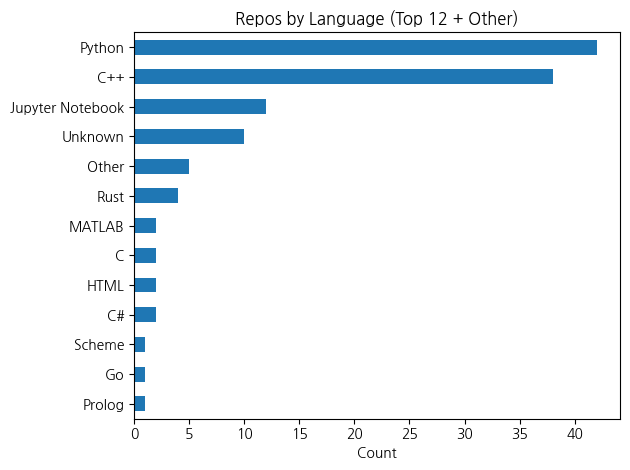

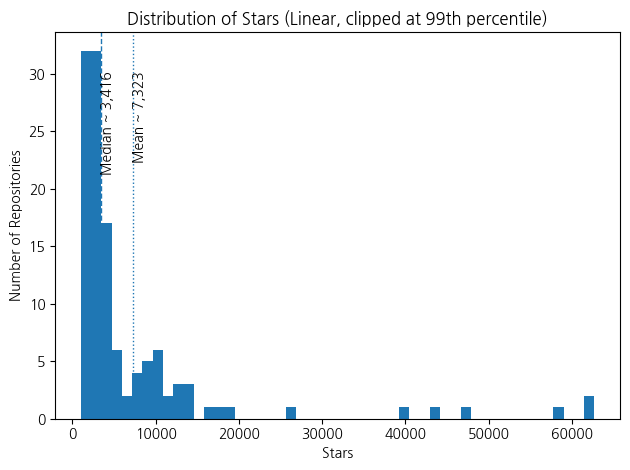

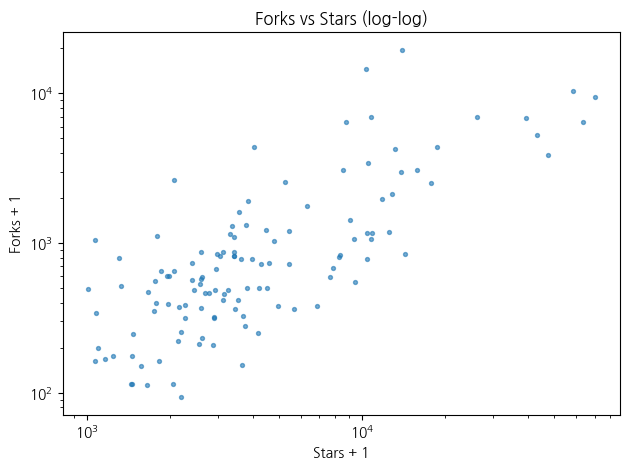

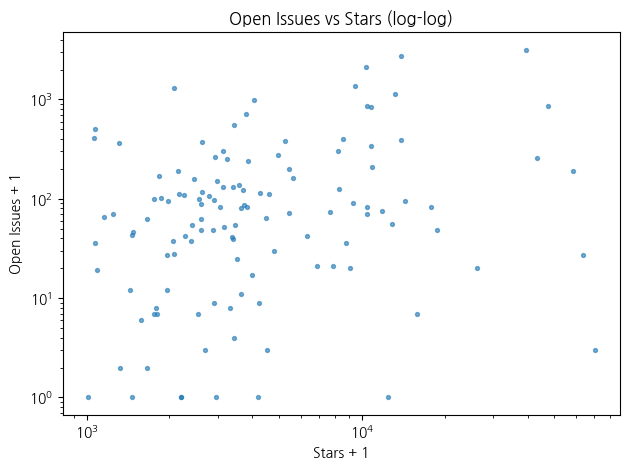

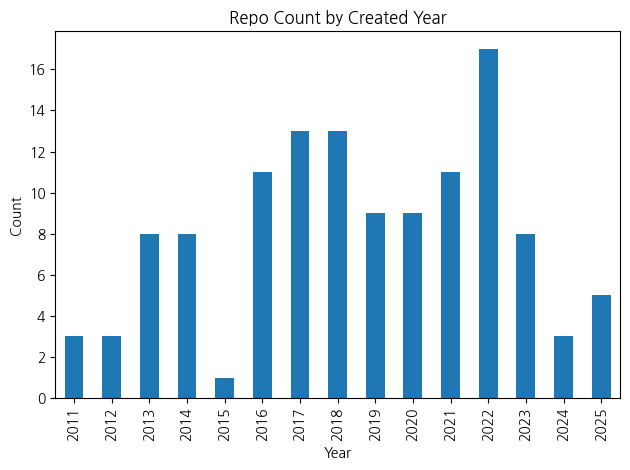

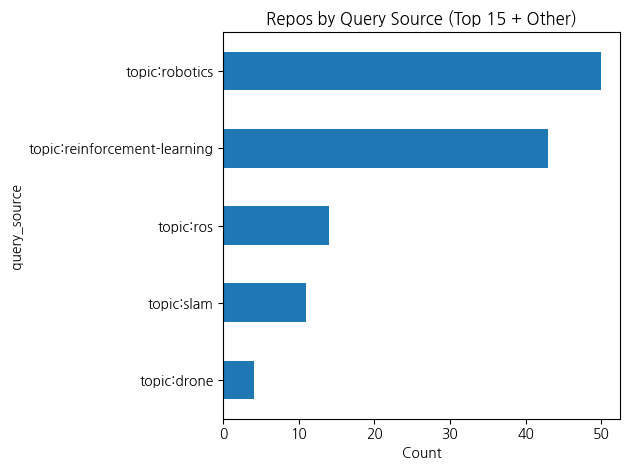

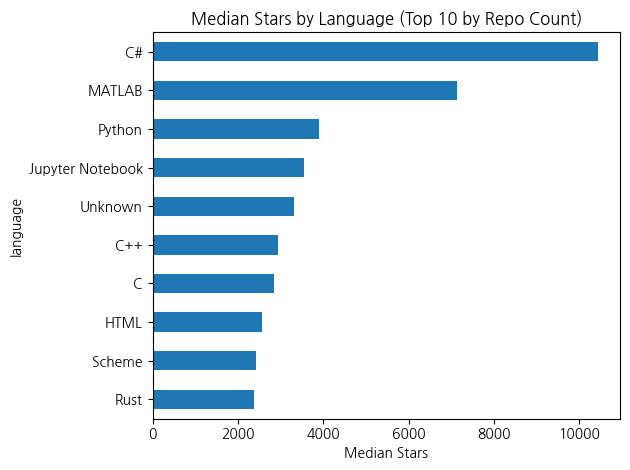

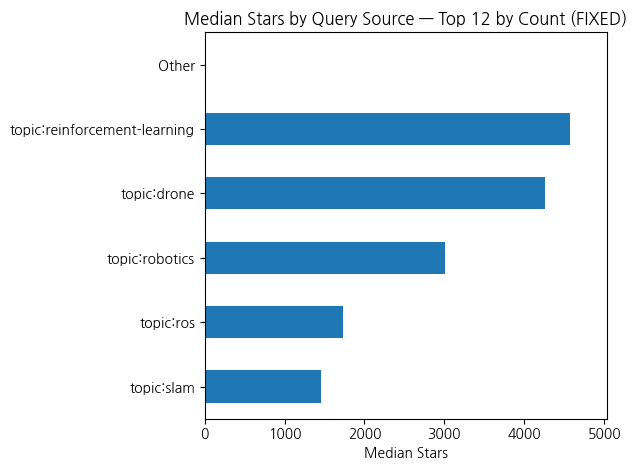

<Figure size 600x450 with 0 Axes>

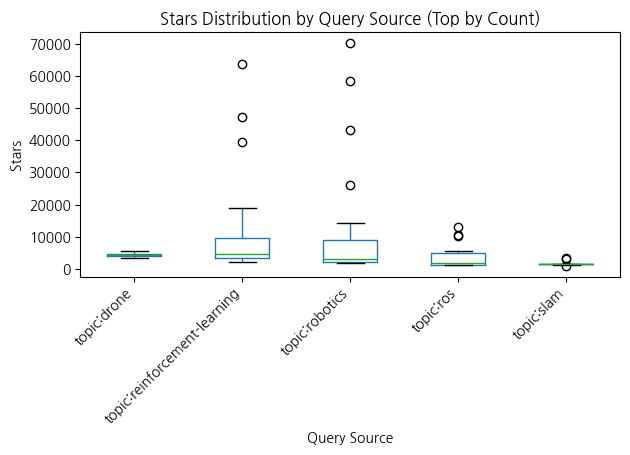

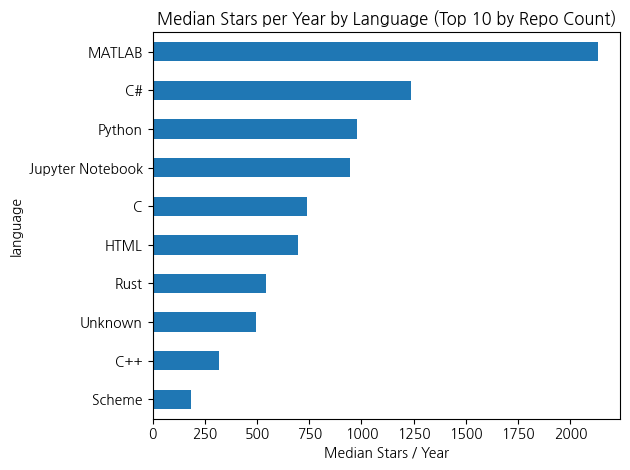

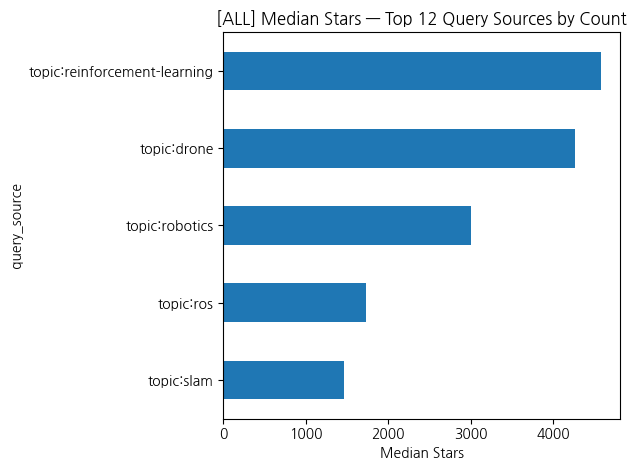

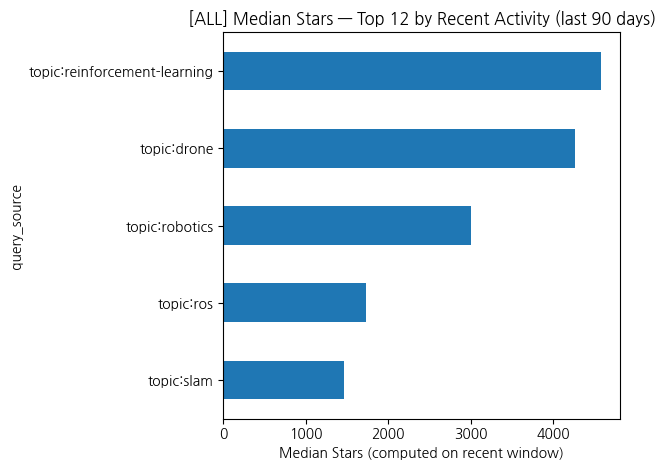

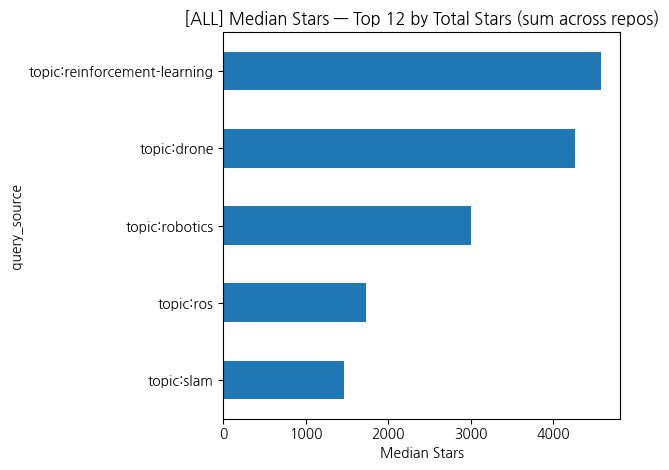

,Count_Top,Recent_Top,TotalStars_Top
0,topic:robotics,topic:robotics,topic:robotics
1,topic:reinforcement-learning,topic:reinforcement-learning,topic:reinforcement-learning
2,topic:ros,topic:ros,topic:ros
3,topic:slam,topic:slam,topic:slam
4,topic:drone,topic:drone,topic:drone


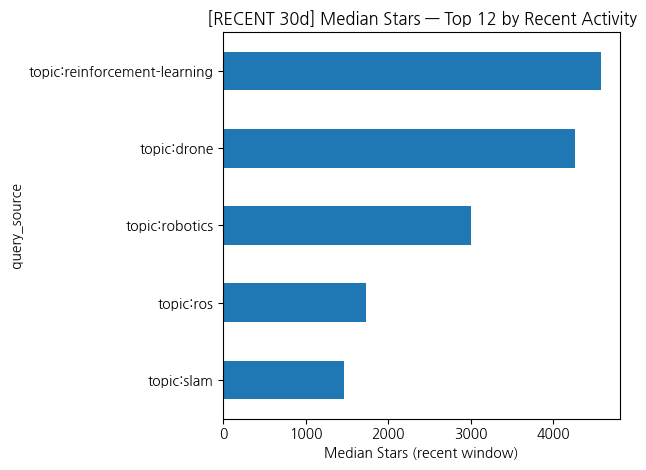

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


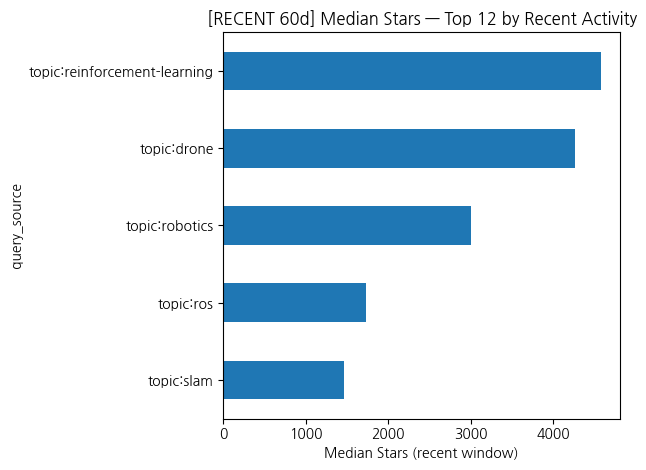

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


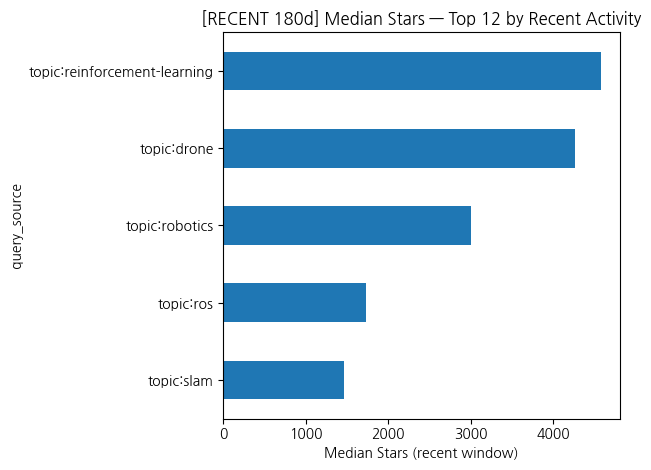

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
0,topic:robotics,topic:robotics,topic:robotics
1,topic:reinforcement-learning,topic:reinforcement-learning,topic:reinforcement-learning
2,topic:ros,topic:ros,topic:ros
3,topic:slam,topic:slam,topic:slam
4,topic:drone,topic:drone,topic:drone


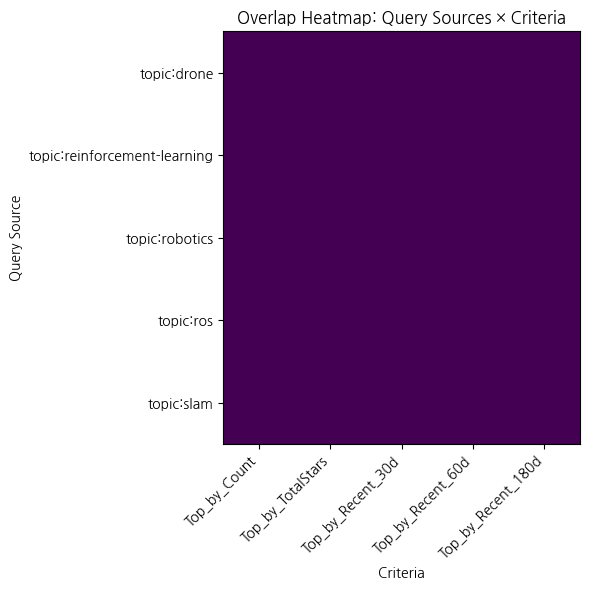

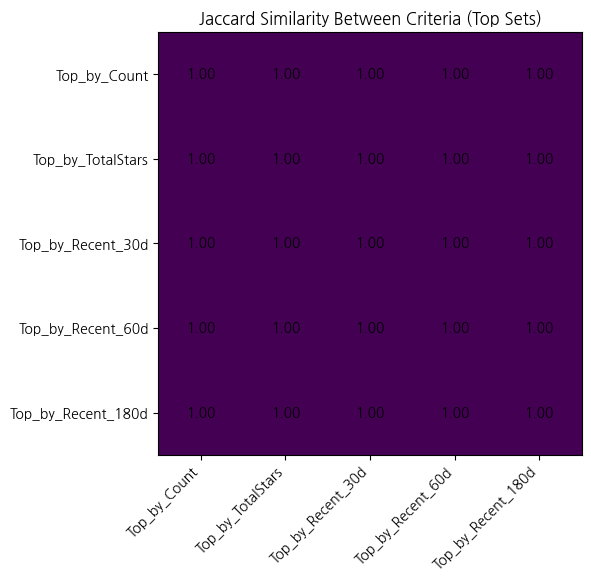

,Top_by_Count,Top_by_TotalStars,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
Top_by_Count,1.00,1.00,1.00,1.00,1.00
Top_by_TotalStars,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_30d,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_60d,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_180d,1.00,1.00,1.00,1.00,1.00


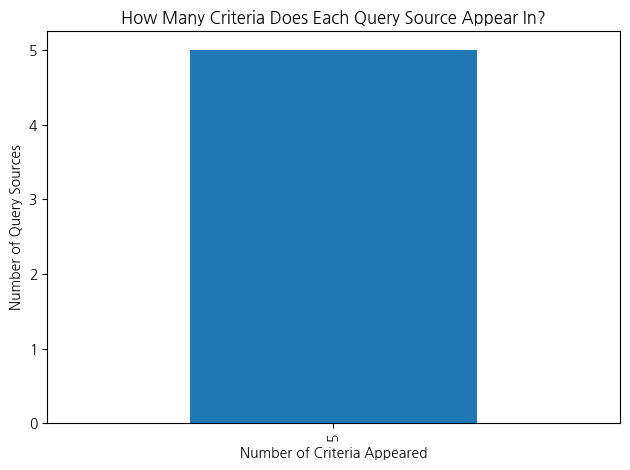

,Top_by_Count,Top_by_TotalStars,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
topic:drone,1,1,1,1,1
topic:reinforcement-learning,1,1,1,1,1
topic:robotics,1,1,1,1,1
topic:ros,1,1,1,1,1
topic:slam,1,1,1,1,1



================  ✅ 교집합 후보 (기준 2+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


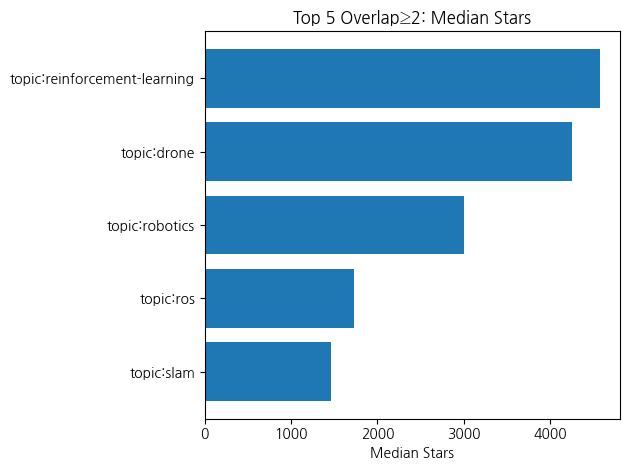


================  ✅ 교집합 후보 (기준 3+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


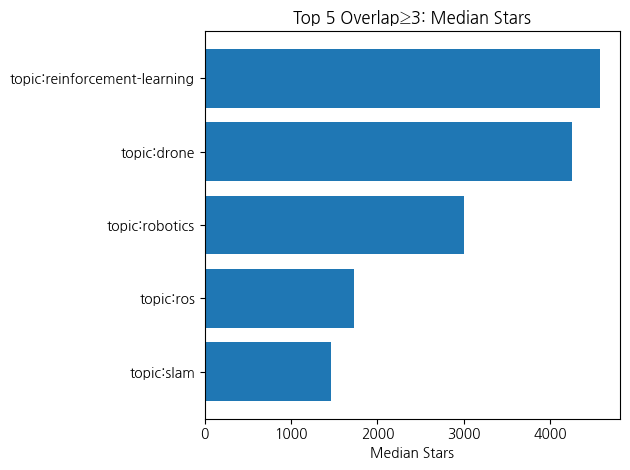


================  ✅ 교집합 후보 (기준 4+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


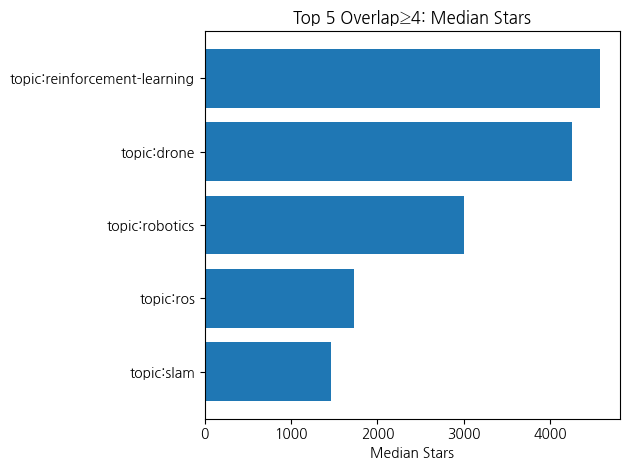


📌 임계치별 교집합 후보 개수 요약


,min_criteria,num_candidates
0,2,5
1,3,5
2,4,5


,repos_total,languages_unique,query_sources_included,stars_median,stars_mean,forks_median,open_issues_median,last_active_max
0,122,17,5,3416.5,7393.745902,662.5,73.5,2025-10-24 06:09:46+00:00


,full_name,html_url,stargazers_count,forks_count,open_issues_count,language,query_source,last_active,description
0,Developer-Y/cs-video-courses,,70098,9412,2,Unknown,topic:robotics,2025-10-24 04:35:17+00:00,List of Computer Science courses with video le...
99,labmlai/annotated_deep_learning_paper_implemen...,,63801,6465,26,Python,topic:reinforcement-learning,2025-10-24 05:48:17+00:00,🧑‍🏫 60+ Implementations/tutorials of deep lear...
1,commaai/openpilot,,58519,10350,191,Python,topic:robotics,2025-10-24 05:45:39+00:00,openpilot is an operating system for robotics....
100,unslothai/unsloth,,47347,3869,853,Python,topic:reinforcement-learning,2025-10-24 05:47:07+00:00,Fine-tuning & Reinforcement Learning for LLMs....
2,NaiboWang/EasySpider,,43151,5303,254,JavaScript,topic:robotics,2025-10-24 04:14:12+00:00,A visual no-code/code-free web crawler/spider易...
101,ray-project/ray,,39470,6820,3170,Python,topic:reinforcement-learning,2025-10-24 06:03:33+00:00,Ray is an AI compute engine. Ray consists of a...
3,AtsushiSakai/PythonRobotics,,26111,6911,19,Python,topic:robotics,2025-10-24 02:26:25+00:00,Python sample codes and textbook for robotics ...
102,Unity-Technologies/ml-agents,,18778,4377,47,C#,topic:reinforcement-learning,2025-10-24 02:28:41+00:00,The Unity Machine Learning Agents Toolkit (ML-...
103,AI4Finance-Foundation/FinGPT,,17863,2528,81,Jupyter Notebook,topic:reinforcement-learning,2025-10-24 04:13:14+00:00,FinGPT: Open-Source Financial Large Language M...
104,datawhalechina/leedl-tutorial,,15901,3075,6,Jupyter Notebook,topic:reinforcement-learning,2025-10-24 05:27:45+00:00,《李宏毅深度学习教程》（李宏毅老师推荐👍，苹果书🍎），PDF下载地址：https://git...


,full_name,html_url,stargazers_count,forks_count,open_issues_count,language,query_source,last_active,description
7,DLR-RM/stable-baselines3,,11848,1965,74,Python,topic:robotics,2025-10-24 06:09:46+00:00,"PyTorch version of Stable Baselines, reliable ..."
31,DLR-RM/rl-baselines3-zoo,,2593,570,62,Python,topic:robotics,2025-10-24 06:08:40+00:00,A training framework for Stable Baselines3 rei...
124,google-deepmind/dm_control,,4280,721,114,Python,topic:reinforcement-learning,2025-10-24 06:06:19+00:00,Google DeepMind's software stack for physics-b...
87,Vincentqyw/cv-arxiv-daily,,1324,516,1,Python,topic:slam,2025-10-24 06:05:01+00:00,🎓Automatically Update CV Papers Daily using Gi...
101,ray-project/ray,,39470,6820,3170,Python,topic:reinforcement-learning,2025-10-24 06:03:33+00:00,Ray is an AI compute engine. Ray consists of a...
120,InternLM/xtuner,,4946,379,274,Python,topic:reinforcement-learning,2025-10-24 06:02:29+00:00,A Next-Generation Training Engine Built for Ul...
42,ARISE-Initiative/robosuite,,1979,603,95,Python,topic:robotics,2025-10-24 05:58:51+00:00,robosuite: A Modular Simulation Framework and ...
111,wandb/wandb,,10442,784,868,Python,topic:reinforcement-learning,2025-10-24 05:55:31+00:00,The AI developer platform. Use Weights & Biase...
8,google-deepmind/mujoco,,10912,1158,208,C++,topic:robotics,2025-10-24 05:51:52+00:00,Multi-Joint dynamics with Contact. A general p...
43,PRBonn/kiss-icp,,1964,392,11,C++,topic:robotics,2025-10-24 05:51:06+00:00,A LiDAR odometry pipeline that just works


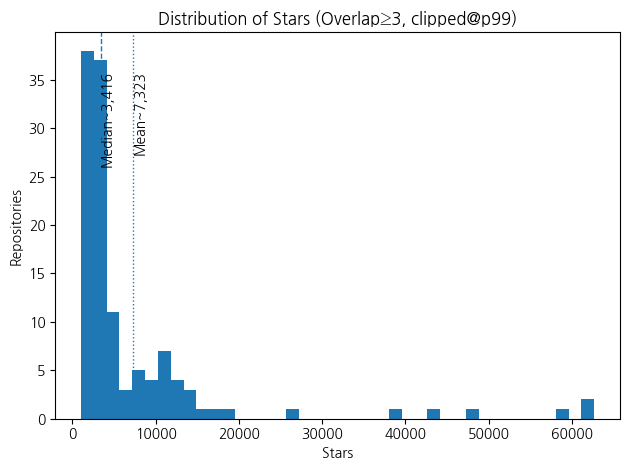

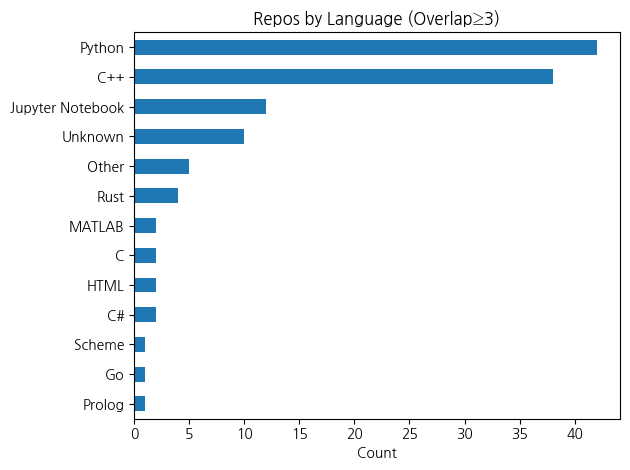

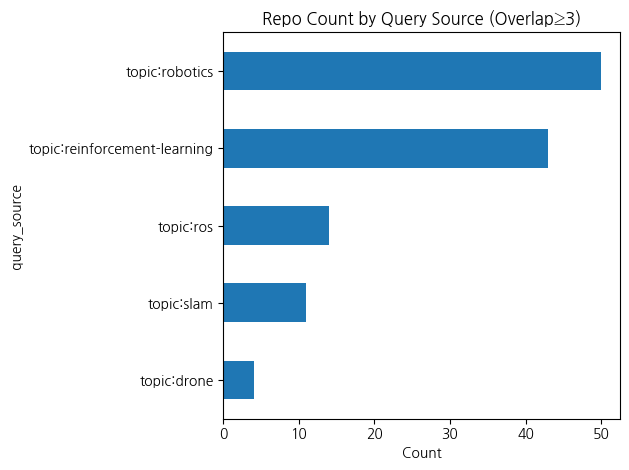

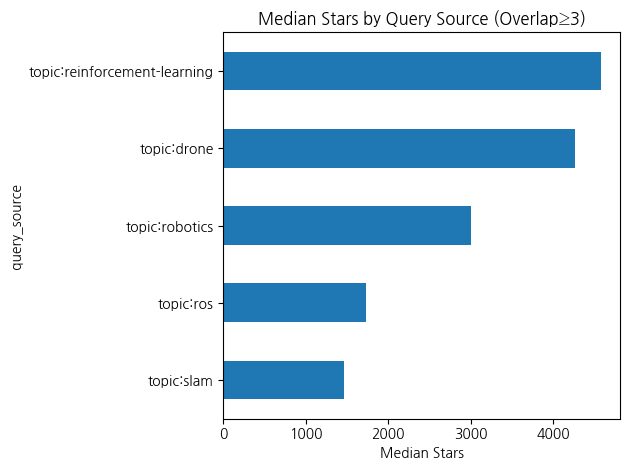

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


📁 Saved:
 - ./reports/overlap_report_K3_all_repos.csv
 - ./reports/overlap_report_K3_qs_stats.csv
 - ./reports/overlap_report_K3.md


In [8]:
# ============================================================
# 📊 base로 의미 있는 분석 그래프 (로그 OFF 기본)
# - Language 분포/언어별 Stars 중앙값
# - Stars 분포 (선형 기본, p99 클리핑 + 중앙값/평균선)
# - (옵션) Stars 분포 (log10)
# - Forks vs Stars (log-log)
# - Open Issues vs Stars (log-log)
# - Created Year 분포
# - Query Source 분포
# - (레거시) Query Source별 Median Stars  [원본 유지, 기본 OFF]
# - (수정)   Query Source별 Median Stars  [버그 FIX, 기본 ON, Count 기준]
# - (추가)   Query Source별 Stars 분포(Boxplot, Top N=12)
# - (추가)   언어별 Stars/Year 중앙값 (나이 보정)
# - (신규)   Query Source별 Median Stars — 3가지 Top 선정 기준 모두 출력
#             ① Count 기준 ② Recent 기준(최근 N일) ③ Stars 합 기준
# - (신규)   Recent 윈도우 세트 30/60/180일: 각 윈도우별 그래프/표
# - (신규)   Overlap 시각화(히트맵/자카드/중복도)
# - (신규)   교집합 자동 추출(≥2/≥3/≥4 기준 동시 포함) + 하이라이트 그래프
# - (신규)   교집합 후보 대시보드/리포트(CSV/Markdown 저장)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 옵션 스위치 ----
SHOW_LINEAR_STARS = True
SHOW_LOG_STARS    = False

SHOW_QS_MED_LEGACY = False      # 레거시 예시가 필요할 때만 True
SHOW_QS_MED_FIXED  = True       # Count 기준(FIXED) 기본 ON
SHOW_QS_BOXPLOT    = True       # Query Source별 Stars 분포
QS_BOXPLOT_TOPN    = 12

SHOW_LANG_STARS_PER_YEAR = True # 언어별 Stars/Year 중앙값

# ---- 공통 파라미터 ----
RECENT_DAYS = 90                # Recent 기준: 최근 N일
TOP_K = 12                      # 모든 Top 그래프 공통 Top K
RECENT_WINDOWS = [30, 60, 180]  # 발표용 최근 윈도우 세트

# --- 안전 가드: 필요한 컬럼 체크 ---
required = {"full_name","language","stargazers_count","forks_count","open_issues_count","created_at","query_source"}
missing = required - set(base.columns)
assert not missing, f"base에 필요한 컬럼이 없습니다: {missing}"

# --- 정리 ---
df = base.copy()

# 수치형 보정
for c in ["stargazers_count","forks_count","open_issues_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# ✅ 날짜 컬럼 보정: 없으면 아예 datetime64[ns, UTC] dtype으로 생성
dtcols = ["created_at","updated_at","pushed_at","last_commit_at"]
for c in dtcols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    else:
        df[c] = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns, UTC]")

# dtype 안전 확인
assert all(str(df[c].dtype).startswith("datetime64[ns, UTC]") for c in dtcols), \
    f"Datetime dtype mismatch: {[ (c, df[c].dtype) for c in dtcols ]}"

# 마지막 활동 시각(last_active): pushed_at > updated_at > last_commit_at > created_at
df["last_active"] = df[dtcols].max(axis=1)

# 문자열 컬럼 정리
df["language"] = df["language"].fillna("Unknown").replace("", "Unknown")
if "query_source" not in df.columns:
    df["query_source"] = "(unknown)"
df["query_source"] = df["query_source"].fillna("(unknown)")

# --- 유틸: 카테고리 시리즈 전용 Top N + Other ---
def top_with_other_categories(s: pd.Series, top_n=12, other="Other"):
    vc = s.value_counts(dropna=False)
    if len(vc) <= top_n:
        return vc
    return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

# 1) Language 분포 (Top 12 + Other)
lang_counts = top_with_other_categories(df["language"], top_n=12)
plt.figure()
lang_counts.sort_values().plot(kind="barh")
plt.title("Repos by Language (Top 12 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 2) Stars 분포 (선형, 상위 1% 클리핑 + 중앙값/평균선)
if SHOW_LINEAR_STARS:
    p99 = df["stargazers_count"].quantile(0.99)
    stars_clip = df["stargazers_count"].clip(upper=p99)
    median_val = float(stars_clip.median())
    mean_val   = float(stars_clip.mean())

    plt.figure()
    plt.hist(stars_clip, bins=50)
    plt.title("Distribution of Stars (Linear, clipped at 99th percentile)")
    plt.xlabel("Stars")
    plt.ylabel("Number of Repositories")
    plt.axvline(median_val, linestyle="--", linewidth=1)
    ymax = plt.ylim()[1]
    plt.text(median_val, ymax*0.9, f"Median ~ {int(median_val):,}", rotation=90, va="top")
    plt.axvline(mean_val, linestyle=":", linewidth=1)
    plt.text(mean_val, ymax*0.9, f"Mean ~ {int(mean_val):,}", rotation=90, va="top")
    plt.tight_layout()
    plt.show()

# (옵션) 2-1) Stars 분포 (log10)
if SHOW_LOG_STARS:
    log_stars = np.log10(df["stargazers_count"].astype(float) + 1.0)
    plt.figure()
    plt.hist(log_stars, bins=30)
    plt.title("Distribution of log10(Stars + 1)")
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3) Forks vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["forks_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Forks vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Forks + 1")
plt.tight_layout()
plt.show()

# 4) Open Issues vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["open_issues_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Open Issues vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Open Issues + 1")
plt.tight_layout()
plt.show()

# 5) Created_at 연도 분포
year_counts = df["created_at"].dt.year.dropna().value_counts().sort_index()
plt.figure()
year_counts.plot(kind="bar")
plt.title("Repo Count by Created Year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6) Query Source 분포 (Top 15 + Other)
qs_counts_all = top_with_other_categories(df["query_source"], top_n=15)
plt.figure()
qs_counts_all.sort_values().plot(kind="barh")
plt.title("Repos by Query Source (Top 15 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 7) 언어별 Stars 중앙값 (Top 10 언어 기준)
top_langs = df["language"].value_counts().head(10).index.tolist()
med_stars_by_lang = (df[df["language"].isin(top_langs)]
                     .groupby("language")["stargazers_count"]
                     .median()
                     .sort_values())
plt.figure()
med_stars_by_lang.plot(kind="barh")
plt.title("Median Stars by Language (Top 10 by Repo Count)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# 8-LEGACY) Query Source별 Median Stars (원본 방식)  ⚠️ 데모용
if SHOW_QS_MED_LEGACY:
    qs_med_legacy = (df.groupby("query_source")["stargazers_count"]
                       .median()
                       .sort_values(ascending=False))
    plt.figure()
    qs_med_legacy.sort_values().plot(kind="barh")
    plt.title("[LEGACY] Median Stars by Query Source (raw)")
    plt.xlabel("Median Stars")
    plt.tight_layout()
    plt.show()

# 8-FIXED) Query Source별 Median Stars — Count 기준(기존 FIXED)
if SHOW_QS_MED_FIXED:
    qs_counts = df["query_source"].value_counts()
    top_qs_by_count = qs_counts.index[:TOP_K]
    df_top = df[df["query_source"].isin(top_qs_by_count)]
    df_other = df[~df["query_source"].isin(top_qs_by_count)]
    qs_med_top = (df_top.groupby("query_source")["stargazers_count"].median())
    other_med = df_other["stargazers_count"].median() if len(df_other) > 0 else np.nan
    qs_med_fixed = pd.concat([qs_med_top, pd.Series({"Other": other_med})]).sort_values()

    plt.figure()
    qs_med_fixed.plot(kind="barh")
    plt.title(f"Median Stars by Query Source — Top {TOP_K} by Count (FIXED)")
    plt.xlabel("Median Stars")
    xmax = float(np.nanmax(qs_med_fixed.values))
    plt.xlim(0, xmax * 1.1 if np.isfinite(xmax) else None)
    plt.tight_layout()
    plt.show()

# (추가) 8B) Query Source별 Stars 분포(Boxplot, Top N by Count)
if SHOW_QS_BOXPLOT:
    topN = df["query_source"].value_counts().head(QS_BOXPLOT_TOPN).index
    dbox = df[df["query_source"].isin(topN)].copy()
    plt.figure(figsize=(max(6, len(topN) * 0.6), 4.5))
    dbox.boxplot(column="stargazers_count", by="query_source", grid=False, vert=True)
    plt.title("Stars Distribution by Query Source (Top by Count)")
    plt.suptitle("")
    plt.xlabel("Query Source"); plt.ylabel("Stars")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# (추가) 7B) 언어별 Stars/Year 중앙값 (나이 보정)
if SHOW_LANG_STARS_PER_YEAR:
    age_years = (pd.Timestamp.now(tz="UTC") - df["created_at"]).dt.days / 365.25
    age_years = age_years.clip(lower=0.25)
    df["_stars_per_year"] = df["stargazers_count"] / age_years

    top_langs_age = df["language"].value_counts().head(10).index.tolist()
    med_spy_by_lang = (df[df["language"].isin(top_langs_age)]
                       .groupby("language")["_stars_per_year"]
                       .median()
                       .sort_values())
    plt.figure()
    med_spy_by_lang.plot(kind="barh")
    plt.title("Median Stars per Year by Language (Top 10 by Repo Count)")
    plt.xlabel("Median Stars / Year")
    plt.tight_layout()
    plt.show()

# ================================
# 🚀 3가지 Top 선정 기준 모두 출력
# ================================
now_utc = pd.Timestamp.now(tz="UTC")
recent_cut = now_utc - pd.Timedelta(days=RECENT_DAYS)
df_recent = df[df["last_active"].notna() & (df["last_active"] >= recent_cut)].copy()

# ① Count 기준
qs_by_count = df["query_source"].value_counts()
top_count = qs_by_count.head(TOP_K).index
med_by_count = (df[df["query_source"].isin(top_count)]
                .groupby("query_source")["stargazers_count"]
                .median()
                .sort_values())
plt.figure()
med_by_count.plot(kind="barh")
plt.title(f"[ALL] Median Stars — Top {TOP_K} Query Sources by Count")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# ② Recent 기준
if len(df_recent) > 0:
    qs_by_recent_cnt = df_recent["query_source"].value_counts()
    top_recent = qs_by_recent_cnt.head(TOP_K).index
    med_by_recent = (df_recent[df_recent["query_source"].isin(top_recent)]
                     .groupby("query_source")["stargazers_count"]
                     .median()
                     .sort_values())
    plt.figure()
    med_by_recent.plot(kind="barh")
    plt.title(f"[ALL] Median Stars — Top {TOP_K} by Recent Activity (last {RECENT_DAYS} days)")
    plt.xlabel("Median Stars (computed on recent window)")
    plt.tight_layout()
    plt.show()
else:
    print(f"[INFO] 최근 {RECENT_DAYS}일 내 last_active 데이터가 없어 'Recent' 기준 그래프를 생략합니다.")
    top_recent = pd.Index([])

# ③ Stars 합 기준
stars_by_qs_sum = df.groupby("query_source")["stargazers_count"].sum().sort_values(ascending=False)
top_stars_sum = stars_by_qs_sum.head(TOP_K).index
med_by_stars_sum = (df[df["query_source"].isin(top_stars_sum)]
                    .groupby("query_source")["stargazers_count"]
                    .median()
                    .sort_values())
plt.figure()
med_by_stars_sum.plot(kind="barh")
plt.title(f"[ALL] Median Stars — Top {TOP_K} by Total Stars (sum across repos)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# 비교 테이블
compare_top_final = pd.DataFrame({"Count_Top": list(top_count)})
if len(top_recent) > 0:
    compare_top_final["Recent_Top"] = list(top_recent)
compare_top_final["TotalStars_Top"] = list(top_stars_sum)
display(compare_top_final)

# ================================
# 🆕 Recent 윈도우 세트: 30/60/180일
# ================================
def plot_recent_window(df_in, window_days: int, top_k: int = TOP_K):
    now_utc_ = pd.Timestamp.now(tz="UTC")
    recent_cut_ = now_utc_ - pd.Timedelta(days=window_days)
    df_recent_ = df_in[df_in["last_active"].notna() & (df_in["last_active"] >= recent_cut_)].copy()

    if len(df_recent_) == 0:
        print(f"[INFO] 최근 {window_days}일 내 last_active 데이터가 없어 스킵합니다.")
        return None

    qs_by_recent_cnt_ = df_recent_["query_source"].value_counts()
    top_recent_ = qs_by_recent_cnt_.head(top_k).index

    med_by_recent_ = (df_recent_[df_recent_["query_source"].isin(top_recent_)]
                      .groupby("query_source")["stargazers_count"]
                      .median()
                      .sort_values())

    plt.figure()
    med_by_recent_.plot(kind="barh")
    plt.title(f"[RECENT {window_days}d] Median Stars — Top {top_k} by Recent Activity")
    plt.xlabel("Median Stars (recent window)")
    plt.tight_layout()
    plt.show()

    summary_recent_ = (df_recent_[df_recent_["query_source"].isin(top_recent_)]
                       .groupby("query_source")
                       .agg(repos=("full_name","count"),
                            stars_median=("stargazers_count","median"),
                            stars_mean=("stargazers_count","mean"))
                       .sort_values("repos", ascending=False))
    display(summary_recent_)

    return list(top_recent_)

tops_by_window = {}
for w in RECENT_WINDOWS:
    tops_by_window[w] = plot_recent_window(df, w, TOP_K)

# 윈도우별 Top 비교표
max_len = max(len(tops_by_window[w]) if tops_by_window[w] is not None else 0 for w in RECENT_WINDOWS)
compare = pd.DataFrame({
    f"Top_by_Recent_{w}d": (tops_by_window[w] + [""] * (max_len - len(tops_by_window[w])))
                           if tops_by_window[w] is not None else [""] * max_len
    for w in RECENT_WINDOWS
})
display(compare)

# ================================
# 🧩 Overlap 시각화 (히트맵/자카드/중복도)
# ================================
def ensure_top_count(df_in, top_k=TOP_K):
    return list(df_in["query_source"].value_counts().head(top_k).index)

def ensure_top_total_stars(df_in, top_k=TOP_K):
    return list(df_in.groupby("query_source")["stargazers_count"].sum()
                .sort_values(ascending=False).head(top_k).index)

def ensure_tops_by_window(df_in, windows=RECENT_WINDOWS, top_k=TOP_K):
    out = {}
    for w in windows:
        now_utc_ = pd.Timestamp.now(tz="UTC")
        cut_ = now_utc_ - pd.Timedelta(days=w)
        df_r_ = df_in[df_in["last_active"].notna() & (df_in["last_active"] >= cut_)]
        out[w] = list(df_r_["query_source"].value_counts().head(top_k).index) if len(df_r_) > 0 else []
    return out

top_count = ensure_top_count(df, TOP_K)
top_stars_sum = ensure_top_total_stars(df, TOP_K)
tops_by_window = ensure_tops_by_window(df, RECENT_WINDOWS, TOP_K)

sets_dict = {
    "Top_by_Count": set(top_count),
    "Top_by_TotalStars": set(top_stars_sum),
}
for w in RECENT_WINDOWS:
    sets_dict[f"Top_by_Recent_{w}d"] = set(tops_by_window.get(w, []) or [])

all_items = sorted(set().union(*sets_dict.values()))
criteria = list(sets_dict.keys())

overlap_mat = pd.DataFrame(
    {crit: [1 if item in sets_dict[crit] else 0 for item in all_items] for crit in criteria},
    index=all_items
)

# Heatmap
plt.figure(figsize=(max(6, len(criteria) * 1.2), max(6, len(all_items) * 0.25)))
plt.imshow(overlap_mat.values, aspect='auto')
plt.title("Overlap Heatmap: Query Sources × Criteria")
plt.xlabel("Criteria"); plt.ylabel("Query Source")
plt.xticks(range(len(criteria)), criteria, rotation=45, ha="right")
plt.yticks(range(len(all_items)), all_items)
plt.tight_layout()
plt.show()

# Jaccard
def jaccard(a: set, b: set) -> float:
    if len(a) == 0 and len(b) == 0:
        return 1.0
    inter = len(a & b); union = len(a | b)
    return inter / union if union > 0 else 0.0

jacc = pd.DataFrame(index=criteria, columns=criteria, dtype=float)
for i, ci in enumerate(criteria):
    for j, cj in enumerate(criteria):
        jacc.iloc[i, j] = jaccard(sets_dict[ci], sets_dict[cj])

plt.figure(figsize=(max(6, len(criteria)), max(6, len(criteria))))
plt.imshow(jacc.values, aspect='equal')
plt.title("Jaccard Similarity Between Criteria (Top Sets)")
plt.xticks(range(len(criteria)), criteria, rotation=45, ha="right")
plt.yticks(range(len(criteria)), criteria)
for i in range(len(criteria)):
    for j in range(len(criteria)):
        plt.text(j, i, f"{jacc.values[i, j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()
display(jacc.style.format("{:.2f}"))

# 중복도 분포
dup_counts = overlap_mat.sum(axis=1)
dup_hist = dup_counts.value_counts().sort_index()
plt.figure()
dup_hist.plot(kind="bar")
plt.title("How Many Criteria Does Each Query Source Appear In?")
plt.xlabel("Number of Criteria Appeared"); plt.ylabel("Number of Query Sources")
plt.tight_layout()
plt.show()

overlap_sorted = overlap_mat.assign(_sum=overlap_mat.sum(axis=1)).sort_values("_sum", ascending=False).drop(columns="_sum")
display(overlap_sorted)

# ================================
# 🏅 교집합 자동 추출(≥2/≥3/≥4) + 하이라이트
# ================================
def summarize_candidates(df_in, items):
    sub = df_in[df_in["query_source"].isin(items)].copy()
    agg = (sub.groupby("query_source")
           .agg(repos=("full_name","count"),
                stars_sum=("stargazers_count","sum"),
                stars_mean=("stargazers_count","mean"),
                stars_median=("stargazers_count","median"),
                last_active_max=("last_active","max"),
                languages_uniq=("language","nunique")))
    crit_cols = []
    for crit in criteria:
        col = f"in_{crit}"
        agg[col] = overlap_mat.loc[agg.index, crit].astype(int).reindex(agg.index).fillna(0).astype(int)
        crit_cols.append(col)
    agg["overlap_count"] = agg[crit_cols].sum(axis=1)
    agg["included_criteria"] = [
        ", ".join([c for c in criteria if overlap_mat.loc[item, c] == 1])
        for item in agg.index
    ]
    return agg.sort_values(by=["overlap_count","stars_median","repos"], ascending=[False, False, False])

def select_overlap_candidates(overlap_df, min_criteria=2):
    return list(overlap_df.index[overlap_df.sum(axis=1) >= min_criteria])

min_criteria_list = [2, 3, 4]
results_by_k = {}
for k in min_criteria_list:
    items_k = select_overlap_candidates(overlap_mat, min_criteria=k)
    if len(items_k) == 0:
        print(f"[INFO] 기준 {k}+ 교집합 후보가 없습니다.")
        continue
    summary_k = summarize_candidates(df, items_k)
    results_by_k[k] = summary_k
    print(f"\n================  ✅ 교집합 후보 (기준 {k}+개 동시 포함) — {len(items_k)}개  ================\n")
    display(summary_k)
    top_n_highlight = min(12, len(summary_k))
    top_show = summary_k.head(top_n_highlight).sort_values("stars_median")
    plt.figure()
    plt.barh(top_show.index, top_show["stars_median"])
    plt.title(f"Top {top_n_highlight} Overlap≥{k}: Median Stars")
    plt.xlabel("Median Stars")
    plt.tight_layout()
    plt.show()

if results_by_k:
    size_df = pd.DataFrame({"min_criteria": list(results_by_k.keys()),
                            "num_candidates": [len(v) for v in results_by_k.values()]}).sort_values("min_criteria")
    print("\n📌 임계치별 교집합 후보 개수 요약")
    display(size_df)

# ================================
# 📄 교집합 후보 대시보드 / 리포트 생성기 (CSV/Markdown)
# ================================
OVERLAP_K = 3                 # 교집합 기준 (예: 2,3,4)
TOP_REPOS_BY_STARS  = 20
TOP_REPOS_BY_RECENT = 20
REPORT_PREFIX = f"overlap_report_K{OVERLAP_K}"

if "html_url" not in df.columns:
    df["html_url"] = ""
if "description" not in df.columns:
    df["description"] = ""

candidate_qs = overlap_mat.index[overlap_mat.sum(axis=1) >= OVERLAP_K].tolist()
if not candidate_qs:
    print(f"[INFO] Overlap≥{OVERLAP_K} 후보가 없습니다. OVERLAP_K를 낮춰보세요.")
else:
    sub = df[df["query_source"].isin(candidate_qs)].copy()
    if sub.empty:
        print("[INFO] 후보 Query Source에 해당하는 레포가 없습니다.")
    else:
        for c in ["stargazers_count","forks_count","open_issues_count"]:
            sub[c] = pd.to_numeric(sub[c], errors="coerce").fillna(0)
        for dt in ["created_at","last_active"]:
            sub[dt] = pd.to_datetime(sub[dt], errors="coerce", utc=True)

        summary_all = {
            "repos_total": len(sub),
            "languages_unique": sub["language"].fillna("Unknown").replace("", "Unknown").nunique(),
            "query_sources_included": len(set(sub["query_source"])),
            "stars_median": float(sub["stargazers_count"].median()),
            "stars_mean": float(sub["stargazers_count"].mean()),
            "forks_median": float(sub["forks_count"].median()),
            "open_issues_median": float(sub["open_issues_count"].median()),
            "last_active_max": pd.to_datetime(sub["last_active"]).max()
        }
        display(pd.DataFrame([summary_all]))

        top_by_stars = (sub.sort_values("stargazers_count", ascending=False)
                          .loc[:, ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]]
                          .head(TOP_REPOS_BY_STARS))
        display(top_by_stars)

        top_by_recent = (sub.sort_values("last_active", ascending=False)
                           .loc[:, ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]]
                           .head(TOP_REPOS_BY_RECENT))
        display(top_by_recent)

        p99 = sub["stargazers_count"].quantile(0.99)
        stars_clip = sub["stargazers_count"].clip(upper=p99)
        med_val = float(stars_clip.median()); mean_val = float(stars_clip.mean())
        plt.figure()
        plt.hist(stars_clip, bins=40)
        plt.title(f"Distribution of Stars (Overlap≥{OVERLAP_K}, clipped@p99)")
        plt.xlabel("Stars"); plt.ylabel("Repositories")
        plt.axvline(med_val, linestyle="--", linewidth=1); ymax = plt.ylim()[1]
        plt.text(med_val, ymax*0.9, f"Median~{int(med_val):,}", rotation=90, va="top")
        plt.axvline(mean_val, linestyle=":", linewidth=1)
        plt.text(mean_val, ymax*0.9, f"Mean~{int(mean_val):,}", rotation=90, va="top")
        plt.tight_layout(); plt.show()

        def top_with_other_categories_local(s: pd.Series, top_n=12, other="Other"):
            vc = s.fillna("Unknown").replace("", "Unknown").value_counts(dropna=False)
            if len(vc) <= top_n:
                return vc
            return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

        lang_counts2 = top_with_other_categories_local(sub["language"], top_n=12)
        plt.figure()
        lang_counts2.sort_values().plot(kind="barh")
        plt.title(f"Repos by Language (Overlap≥{OVERLAP_K})")
        plt.xlabel("Count"); plt.tight_layout(); plt.show()

        qs_stats = (sub.groupby("query_source")
                      .agg(repos=("full_name","count"),
                           stars_median=("stargazers_count","median"),
                           stars_mean=("stargazers_count","mean"))
                      .sort_values("repos", ascending=False))
        plt.figure(); qs_stats["repos"].sort_values().plot(kind="barh")
        plt.title(f"Repo Count by Query Source (Overlap≥{OVERLAP_K})")
        plt.xlabel("Count"); plt.tight_layout(); plt.show()

        plt.figure(); qs_stats["stars_median"].sort_values().plot(kind="barh")
        plt.title(f"Median Stars by Query Source (Overlap≥{OVERLAP_K})")
        plt.xlabel("Median Stars"); plt.tight_layout(); plt.show()
        display(qs_stats)

        def to_markdown_table(df_md: pd.DataFrame, max_rows=30):
            cols = ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]
            cols = [c for c in cols if c in df_md.columns]
            d = df_md[cols].head(max_rows).copy()
            if "html_url" in d.columns and "full_name" in d.columns:
                d["full_name"] = d.apply(
                    lambda r: f"[{r['full_name']}]({r['html_url']})" if pd.notna(r.get("html_url","")) and r.get("html_url","") else r["full_name"],
                    axis=1
                )
                d = d.drop(columns=["html_url"])
            return d.to_markdown(index=False)

        md_lines = []
        md_lines.append(f"# Overlap≥{OVERLAP_K} Report")
        md_lines.append("")
        md_lines.append("## Summary")
        md_lines.append(pd.DataFrame([summary_all]).to_markdown(index=False))
        md_lines.append("")
        md_lines.append("## Top Repositories by Stars")
        md_lines.append(to_markdown_table(top_by_stars, max_rows=TOP_REPOS_BY_STARS))
        md_lines.append("")
        md_lines.append("## Top Repositories by Recent Activity")
        md_lines.append(to_markdown_table(top_by_recent, max_rows=TOP_REPOS_BY_RECENT))
        md_text = "\n".join(md_lines)

        os.makedirs("./reports", exist_ok=True)
        csv_all_path = f"./reports/{REPORT_PREFIX}_all_repos.csv"
        csv_qs_path  = f"./reports/{REPORT_PREFIX}_qs_stats.csv"
        md_path      = f"./reports/{REPORT_PREFIX}.md"

        sub.to_csv(csv_all_path, index=False)
        qs_stats.to_csv(csv_qs_path)
        with open(md_path, "w", encoding="utf-8") as f:
            f.write(md_text)

        print(f"📁 Saved:\n - {csv_all_path}\n - {csv_qs_path}\n - {md_path}")


### “Recent 윈도우 세트(30/60/180일)”를 추가로 전부 출력


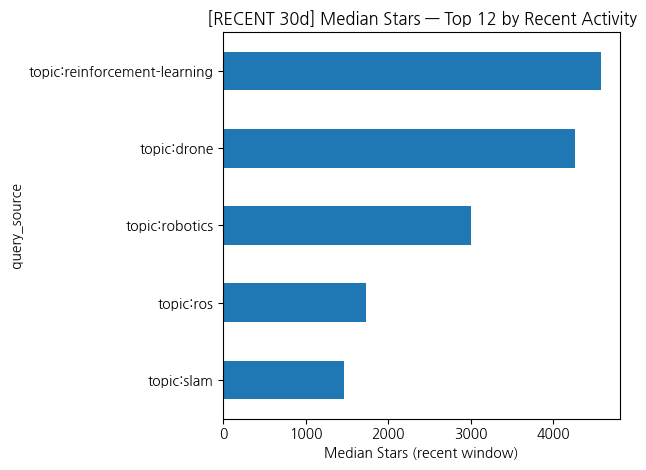

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


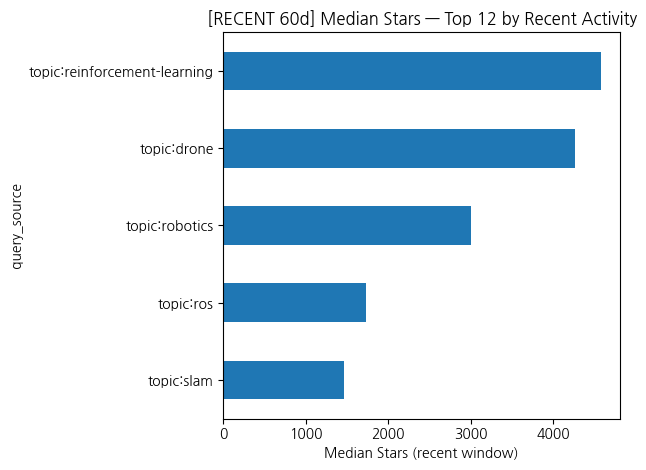

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


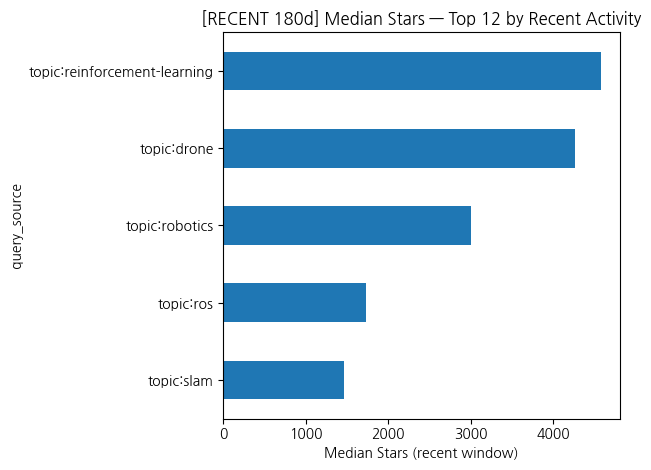

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
0,topic:robotics,topic:robotics,topic:robotics
1,topic:reinforcement-learning,topic:reinforcement-learning,topic:reinforcement-learning
2,topic:ros,topic:ros,topic:ros
3,topic:slam,topic:slam,topic:slam
4,topic:drone,topic:drone,topic:drone


In [9]:
# ============================================
# 🆕 Recent 윈도우 세트 추가 출력 (30/60/180일)
#  - 각 윈도우마다: 최근 활동 많은 Query Source Top K 선택
#  - 해당 Top K의 Stars 중앙값 바차트 + 요약 테이블
# ============================================

RECENT_WINDOWS = [30, 60, 180]   # 발표용 세트
TOP_K = 12                       # 공통 Top K

def plot_recent_window(df, window_days: int, top_k: int = TOP_K):
    # FIX: utcnow().tz_localize("UTC") → now(tz="UTC")
    now_utc = pd.Timestamp.now(tz="UTC")
    recent_cut = now_utc - pd.Timedelta(days=window_days)

    # last_active가 tz-aware(datetime64[ns, UTC])인지 보장(선행 전처리에서 처리되어야 함)
    # 필요시 아래 한 줄로 강제 변환 가능:
    # df["last_active"] = pd.to_datetime(df["last_active"], errors="coerce", utc=True)

    df_recent = df[df["last_active"].notna() & (df["last_active"] >= recent_cut)].copy()

    if len(df_recent) == 0:
        print(f"[INFO] 최근 {window_days}일 내 last_active 데이터가 없어 스킵합니다.")
        return None

    # 최근 윈도우에서 '활동 많은' Query Source: 단순 개수 기준
    qs_by_recent_cnt = df_recent["query_source"].value_counts()
    top_recent = qs_by_recent_cnt.head(top_k).index

    # 최근 윈도우에 포함된 저장소들만으로 Median Stars 계산
    med_by_recent = (df_recent[df_recent["query_source"].isin(top_recent)]
                     .groupby("query_source")["stargazers_count"]
                     .median()
                     .sort_values())

    # 시각화
    plt.figure()
    med_by_recent.plot(kind="barh")
    plt.title(f"[RECENT {window_days}d] Median Stars — Top {top_k} by Recent Activity")
    plt.xlabel("Median Stars (recent window)")
    plt.tight_layout()
    plt.show()

    # 요약 테이블: 각 쿼리소스별 리포 수/중앙값/평균
    summary_recent = (df_recent[df_recent["query_source"].isin(top_recent)]
                      .groupby("query_source")
                      .agg(repos=("full_name","count"),
                           stars_median=("stargazers_count","median"),
                           stars_mean=("stargazers_count","mean"))
                      .sort_values("repos", ascending=False))
    display(summary_recent)

    return list(top_recent)

# 실행: 30/60/180일 전부 출력
tops_by_window = {}
for w in RECENT_WINDOWS:
    tops_by_window[w] = plot_recent_window(df, w, TOP_K)

# 보너스: 세 윈도우 Top 목록 비교 테이블 (겹치는 소스 확인용)
max_len = max(len(tops_by_window[w]) if tops_by_window[w] is not None else 0 for w in RECENT_WINDOWS)
compare = pd.DataFrame({
    f"Top_by_Recent_{w}d": (tops_by_window[w] + [""] * (max_len - len(tops_by_window[w])))
                           if tops_by_window[w] is not None else [""] * max_len
    for w in RECENT_WINDOWS
})
display(compare)


### “겹치는 쿼리 소스가 어디인지”를 한눈에 보여줄 겹침(Overlap) 히트맵 + 자카드 유사도(기준 간 유사도) + 중복도 분포 세트를 추가

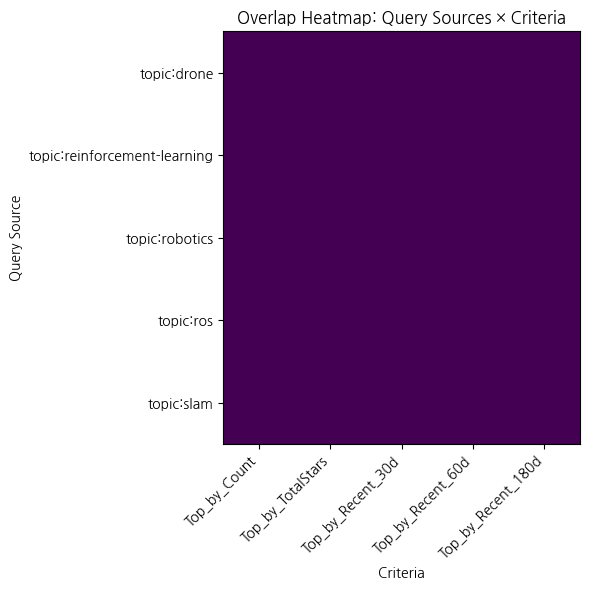

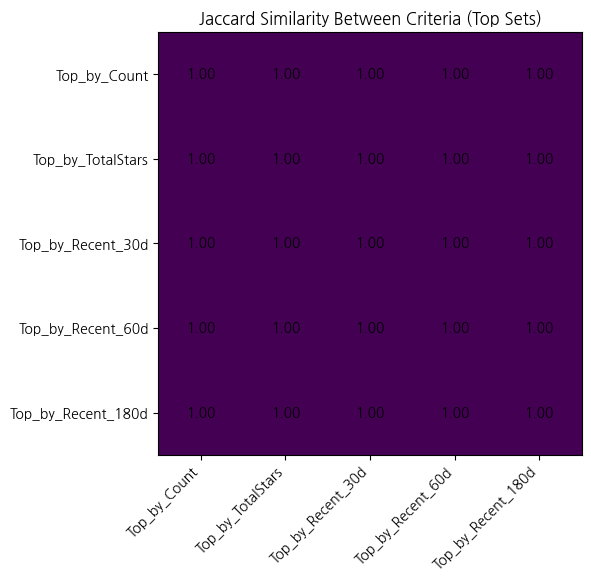

,Top_by_Count,Top_by_TotalStars,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
Top_by_Count,1.00,1.00,1.00,1.00,1.00
Top_by_TotalStars,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_30d,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_60d,1.00,1.00,1.00,1.00,1.00
Top_by_Recent_180d,1.00,1.00,1.00,1.00,1.00


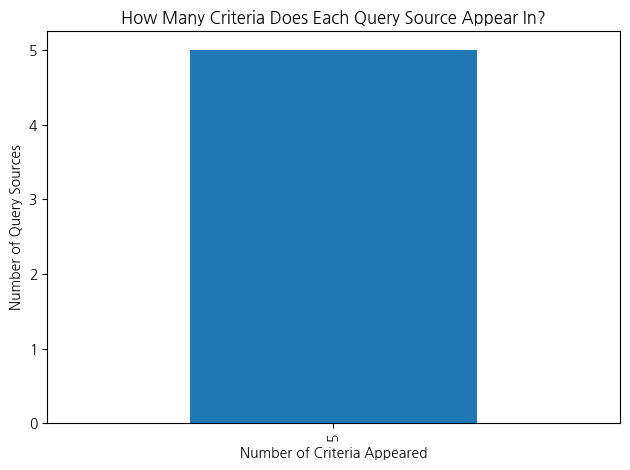

,Top_by_Count,Top_by_TotalStars,Top_by_Recent_30d,Top_by_Recent_60d,Top_by_Recent_180d
topic:drone,1,1,1,1,1
topic:reinforcement-learning,1,1,1,1,1
topic:robotics,1,1,1,1,1
topic:ros,1,1,1,1,1
topic:slam,1,1,1,1,1


In [10]:
# ============================================
# 🧩 기준/윈도우 간 Overlap 시각화 확장
#  - Overlap Heatmap: 각 Query Source가 어떤 기준 Top에 들었는지
#  - Pairwise Jaccard Similarity: 기준 간 유사도
#  - 중복도 분포: 몇 개 기준에 동시 포함되었는가
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 설정 ----
TOP_K = 12
RECENT_WINDOWS = [30, 60, 180]  # 앞에서 사용한 값과 동일하게

# ---- 안전 재계산: 필요한 Top 집합들이 없을 경우 계산 ----
def ensure_top_count(df, top_k=TOP_K):
    qs_by_count = df["query_source"].value_counts()
    return list(qs_by_count.head(top_k).index)

def ensure_top_total_stars(df, top_k=TOP_K):
    stars_by_qs_sum = df.groupby("query_source")["stargazers_count"].sum().sort_values(ascending=False)
    return list(stars_by_qs_sum.head(top_k).index)

def ensure_tops_by_window(df, windows=RECENT_WINDOWS, top_k=TOP_K):
    # last_active가 앞서 정의돼 있다고 가정. 없으면 보정
    if "last_active" not in df.columns:
        for dtcol in ["created_at","updated_at","pushed_at","last_commit_at"]:
            if dtcol not in df.columns:
                df[dtcol] = pd.NaT
        df["created_at"]  = pd.to_datetime(df["created_at"],  errors="coerce", utc=True)
        df["updated_at"]  = pd.to_datetime(df["updated_at"],  errors="coerce", utc=True)
        df["pushed_at"]   = pd.to_datetime(df["pushed_at"],   errors="coerce", utc=True)
        df["last_commit_at"] = pd.to_datetime(df["last_commit_at"], errors="coerce", utc=True)
        df["last_active"] = df[["pushed_at","updated_at","last_commit_at","created_at"]].max(axis=1)

    now_utc = pd.Timestamp.utcnow().tz_localize("UTC")
    out = {}
    for w in windows:
        recent_cut = now_utc - pd.Timedelta(days=w)
        df_recent = df[df["last_active"].notna() & (df["last_active"] >= recent_cut)]
        if len(df_recent) == 0:
            out[w] = []
        else:
            top_recent = list(df_recent["query_source"].value_counts().head(top_k).index)
            out[w] = top_recent
    return out

# 기존 변수 재사용(없으면 계산)
try:
    _ = top_count
except NameError:
    top_count = ensure_top_count(df, TOP_K)

try:
    _ = top_stars_sum
except NameError:
    top_stars_sum = ensure_top_total_stars(df, TOP_K)

try:
    _ = tops_by_window
except NameError:
    tops_by_window = ensure_tops_by_window(df, RECENT_WINDOWS, TOP_K)

# ---- 집합 사전 구성 ----
sets_dict = {
    "Top_by_Count": set(top_count),
    "Top_by_TotalStars": set(top_stars_sum),
}
for w in RECENT_WINDOWS:
    label = f"Top_by_Recent_{w}d"
    sets_dict[label] = set(tops_by_window.get(w, []) or [])

# ---- Overlap 행렬 (아이템 x 기준) ----
all_items = sorted(set().union(*sets_dict.values()))
criteria  = list(sets_dict.keys())

overlap_mat = pd.DataFrame(
    {crit: [1 if item in sets_dict[crit] else 0 for item in all_items] for crit in criteria},
    index=all_items
)

# 1) 🔥 Overlap Heatmap
plt.figure(figsize=(max(6, len(criteria) * 1.2), max(6, len(all_items) * 0.25)))
plt.imshow(overlap_mat.values, aspect='auto')
plt.title("Overlap Heatmap: Query Sources × Criteria")
plt.xlabel("Criteria")
plt.ylabel("Query Source")
plt.xticks(ticks=range(len(criteria)), labels=criteria, rotation=45, ha="right")
plt.yticks(ticks=range(len(all_items)), labels=all_items)
plt.tight_layout()
plt.show()

# 2) 🤝 Pairwise Jaccard Similarity (기준 간 유사도)
def jaccard(a: set, b: set) -> float:
    if len(a) == 0 and len(b) == 0:
        return 1.0
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union > 0 else 0.0

jacc = pd.DataFrame(index=criteria, columns=criteria, dtype=float)
for i, ci in enumerate(criteria):
    for j, cj in enumerate(criteria):
        jacc.iloc[i, j] = jaccard(sets_dict[ci], sets_dict[cj])

plt.figure(figsize=(max(6, len(criteria) * 1.0), max(6, len(criteria) * 1.0)))
plt.imshow(jacc.values, aspect='equal')
plt.title("Jaccard Similarity Between Criteria (Top Sets)")
plt.xticks(ticks=range(len(criteria)), labels=criteria, rotation=45, ha="right")
plt.yticks(ticks=range(len(criteria)), labels=criteria)
# 셀에 값 표기
for i in range(len(criteria)):
    for j in range(len(criteria)):
        val = jacc.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()

display(jacc.style.format("{:.2f}"))

# 3) 📊 중복도 분포: 각 Query Source가 몇 개 기준에 등장했는가
dup_counts = overlap_mat.sum(axis=1)  # 각 소스의 포함 기준 개수
dup_hist = dup_counts.value_counts().sort_index()

plt.figure()
dup_hist.plot(kind="bar")
plt.title("How Many Criteria Does Each Query Source Appear In?")
plt.xlabel("Number of Criteria Appeared")
plt.ylabel("Number of Query Sources")
plt.tight_layout()
plt.show()

# 보너스: 기준별로 정렬된 아이템 표 (겹치는 순서대로)
# 많이 겹칠수록 상위에 오도록 정렬
overlap_sorted = overlap_mat.assign(_sum=overlap_mat.sum(axis=1)).sort_values("_sum", ascending=False).drop(columns="_sum")
display(overlap_sorted)


### 여러 기준에 동시에 등장하는 강력 후보(교집합) 를 자동 추출해 표로 정리하고, 선택 기준(예: ≥2, ≥3, ≥4개 기준 동시 등장)을 전부 보여주는 확장 블록



================  ✅ 교집합 후보 (기준 2+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


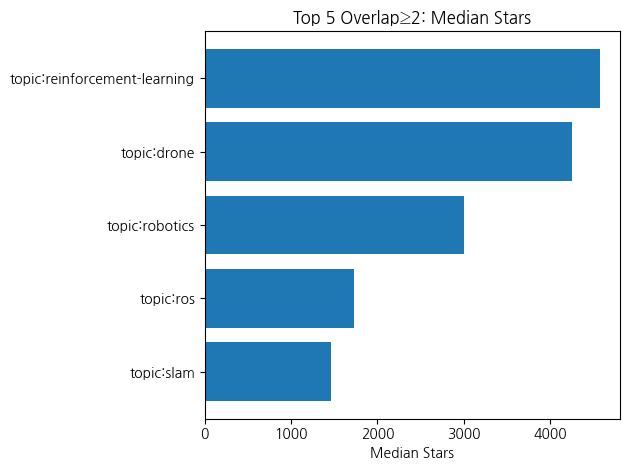


================  ✅ 교집합 후보 (기준 3+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


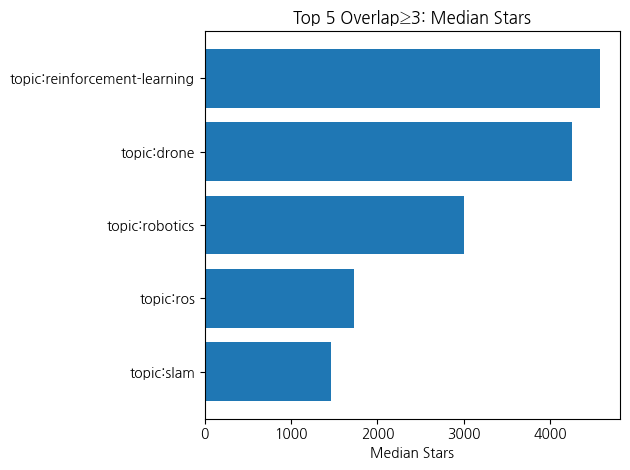


================  ✅ 교집합 후보 (기준 4+개 동시 포함) — 5개  ================



,repos,stars_sum,stars_mean,stars_median,last_active_max,languages_uniq,in_Top_by_Count,in_Top_by_TotalStars,in_Top_by_Recent_30d,in_Top_by_Recent_60d,in_Top_by_Recent_180d,overlap_count,included_criteria
query_source,,,,,,,,,,,,,
topic:reinforcement-learning,43,403311,9379.325581,4579.0,2025-10-24 06:06:19+00:00,9,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:drone,4,17369,4342.250000,4257.0,2025-10-24 02:09:18+00:00,2,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:robotics,50,407825,8156.500000,3006.5,2025-10-24 06:09:46+00:00,14,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:ros,14,54828,3916.285714,1729.0,2025-10-24 04:50:40+00:00,4,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."
topic:slam,11,18704,1700.363636,1460.0,2025-10-24 06:05:01+00:00,3,1,1,1,1,1,5,"Top_by_Count, Top_by_TotalStars, Top_by_Recent..."


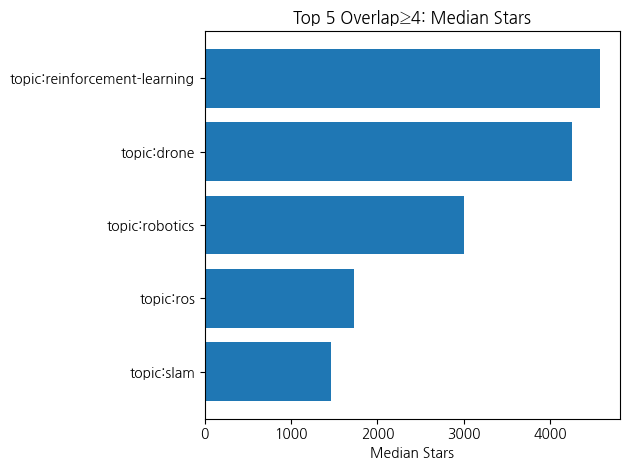


📌 임계치별 교집합 후보 개수 요약


,min_criteria,num_candidates
0,2,5
1,3,5
2,4,5


In [11]:
# ============================================
# 🏅 교집합 자동 추출: 여러 기준에 공통으로 등장하는 강력 후보 뽑기
#  - min_criteria_list: [2,3,4] 등으로 여러 임계치 전부 출력
#  - 각 후보에 대해 요약 메트릭 계산:
#       repos 수, stars 합/평균/중앙값, 최근활동(last_active) 최대,
#       언어 다양도(#unique languages), 포함된 기준 목록
#  - 테이블은 overlap 개수(desc) → stars_median(desc) → repos(desc) 순으로 정렬
# ============================================

from collections import defaultdict

# 준비물: overlap_mat (items×criteria 0/1), df (원본), criteria (기준명 리스트), sets_dict
assert 'overlap_mat' in globals() and 'df' in globals() and 'criteria' in globals(), \
    "overlap_mat/df/criteria가 필요합니다. 앞 단계 코드를 먼저 실행하세요."

def summarize_candidates(df, items):
    """items: Query Source 문자열 리스트 (overlap_mat의 인덱스 값들)"""
    # 원본 df에는 query_source가 동일 이름으로 존재
    sub = df[df["query_source"].isin(items)].copy()

    # 각 query_source 별 요약
    agg = (sub.groupby("query_source")
              .agg(
                   repos=("full_name", "count"),
                   stars_sum=("stargazers_count","sum"),
                   stars_mean=("stargazers_count","mean"),
                   stars_median=("stargazers_count","median"),
                   last_active_max=("last_active","max"),
                   languages_uniq=("language", "nunique")
              )
          )

    # 포함된 기준 목록/개수 추가
    crit_cols = []
    for crit in criteria:
        col = f"in_{crit}"
        agg[col] = overlap_mat.loc[agg.index, crit].astype(int).reindex(agg.index).fillna(0).astype(int)
        crit_cols.append(col)

    agg["overlap_count"] = agg[crit_cols].sum(axis=1)
    agg["included_criteria"] = [
        ", ".join([c for c in criteria if overlap_mat.loc[item, c] == 1])
        for item in agg.index
    ]

    # 정렬: overlap_count(desc) → stars_median(desc) → repos(desc)
    agg_sorted = agg.sort_values(by=["overlap_count","stars_median","repos"], ascending=[False, False, False])
    return agg_sorted

def select_overlap_candidates(overlap_mat, min_criteria=2):
    """overlap_mat에서 지정 임계치 이상 포함된 아이템만 반환"""
    mask = overlap_mat.sum(axis=1) >= min_criteria
    return list(overlap_mat.index[mask])

# 여러 임계치에 대해 모두 출력
min_criteria_list = [2, 3, 4]   # 필요시 [2,3,4,5]로 확대 가능
results_by_k = {}

for k in min_criteria_list:
    items_k = select_overlap_candidates(overlap_mat, min_criteria=k)
    if len(items_k) == 0:
        print(f"[INFO] 기준 {k}+ 교집합 후보가 없습니다.")
        continue

    summary_k = summarize_candidates(df, items_k)
    results_by_k[k] = summary_k

    print(f"\n================  ✅ 교집합 후보 (기준 {k}+개 동시 포함) — {len(items_k)}개  ================\n")
    display(summary_k)

    # 상위 몇 개만 바차트(선택) — 발표용 하이라이트
    top_n_highlight = min(12, len(summary_k))
    top_show = summary_k.head(top_n_highlight).sort_values("stars_median")  # barh를 위해 오름차순
    plt.figure()
    plt.barh(top_show.index, top_show["stars_median"])
    plt.title(f"Top {top_n_highlight} Overlap≥{k}: Median Stars")
    plt.xlabel("Median Stars")
    plt.tight_layout()
    plt.show()

# 보너스: 임계치별 교집합 규모 요약
if results_by_k:
    size_df = pd.DataFrame(
        {"min_criteria": list(results_by_k.keys()),
         "num_candidates": [len(v) for v in results_by_k.values()]}
    ).sort_values("min_criteria")
    print("\n📌 임계치별 교집합 후보 개수 요약")
    display(size_df)


### 교집합 후보(Overlap≥K) 들만 모아 한 장짜리 리포트를 생성하는 확장 블록
(앞서 만든 df, overlap_mat, results_by_k, criteria를 그대로 재사용합니다.)

어떤 기준(K 이상)에 동시에 등장한 강력 후보 Query Source들을 선택

그 후보들에 속한 레포 전체 목록을 모아:

요약 메트릭(Stars/Forks/Issues/언어/최근활동)

Top 레포(Stars 상위) 표 + 최근 업데이트 상위 표

Stars 분포 히스토그램, 언어 분포, Query Source별 레포 수/Stars 중앙값

테이블은 display()로 보여주고, CSV/Markdown 파일도 함께 저장(발표/공유용)

⚠️ 필요 컬럼: full_name, html_url(선택), description(선택), language, stargazers_count, forks_count, open_issues_count, created_at, last_active, query_source
html_url/description이 없다면 자동으로 빈 값 처리합니다.

✅ Overlap≥3 후보 Query Source: 5개
['topic:drone', 'topic:reinforcement-learning', 'topic:robotics', 'topic:ros', 'topic:slam']


,repos_total,languages_unique,query_sources_included,stars_median,stars_mean,forks_median,open_issues_median,last_active_max
0,122,17,5,3416.5,7393.745902,662.5,73.5,2025-10-24 06:09:46+00:00


,full_name,html_url,stargazers_count,forks_count,open_issues_count,language,query_source,last_active,description
0,Developer-Y/cs-video-courses,,70098,9412,2,Unknown,topic:robotics,2025-10-24 04:35:17+00:00,List of Computer Science courses with video le...
99,labmlai/annotated_deep_learning_paper_implemen...,,63801,6465,26,Python,topic:reinforcement-learning,2025-10-24 05:48:17+00:00,🧑‍🏫 60+ Implementations/tutorials of deep lear...
1,commaai/openpilot,,58519,10350,191,Python,topic:robotics,2025-10-24 05:45:39+00:00,openpilot is an operating system for robotics....
100,unslothai/unsloth,,47347,3869,853,Python,topic:reinforcement-learning,2025-10-24 05:47:07+00:00,Fine-tuning & Reinforcement Learning for LLMs....
2,NaiboWang/EasySpider,,43151,5303,254,JavaScript,topic:robotics,2025-10-24 04:14:12+00:00,A visual no-code/code-free web crawler/spider易...
101,ray-project/ray,,39470,6820,3170,Python,topic:reinforcement-learning,2025-10-24 06:03:33+00:00,Ray is an AI compute engine. Ray consists of a...
3,AtsushiSakai/PythonRobotics,,26111,6911,19,Python,topic:robotics,2025-10-24 02:26:25+00:00,Python sample codes and textbook for robotics ...
102,Unity-Technologies/ml-agents,,18778,4377,47,C#,topic:reinforcement-learning,2025-10-24 02:28:41+00:00,The Unity Machine Learning Agents Toolkit (ML-...
103,AI4Finance-Foundation/FinGPT,,17863,2528,81,Jupyter Notebook,topic:reinforcement-learning,2025-10-24 04:13:14+00:00,FinGPT: Open-Source Financial Large Language M...
104,datawhalechina/leedl-tutorial,,15901,3075,6,Jupyter Notebook,topic:reinforcement-learning,2025-10-24 05:27:45+00:00,《李宏毅深度学习教程》（李宏毅老师推荐👍，苹果书🍎），PDF下载地址：https://git...


,full_name,html_url,stargazers_count,forks_count,open_issues_count,language,query_source,last_active,description
7,DLR-RM/stable-baselines3,,11848,1965,74,Python,topic:robotics,2025-10-24 06:09:46+00:00,"PyTorch version of Stable Baselines, reliable ..."
31,DLR-RM/rl-baselines3-zoo,,2593,570,62,Python,topic:robotics,2025-10-24 06:08:40+00:00,A training framework for Stable Baselines3 rei...
124,google-deepmind/dm_control,,4280,721,114,Python,topic:reinforcement-learning,2025-10-24 06:06:19+00:00,Google DeepMind's software stack for physics-b...
87,Vincentqyw/cv-arxiv-daily,,1324,516,1,Python,topic:slam,2025-10-24 06:05:01+00:00,🎓Automatically Update CV Papers Daily using Gi...
101,ray-project/ray,,39470,6820,3170,Python,topic:reinforcement-learning,2025-10-24 06:03:33+00:00,Ray is an AI compute engine. Ray consists of a...
120,InternLM/xtuner,,4946,379,274,Python,topic:reinforcement-learning,2025-10-24 06:02:29+00:00,A Next-Generation Training Engine Built for Ul...
42,ARISE-Initiative/robosuite,,1979,603,95,Python,topic:robotics,2025-10-24 05:58:51+00:00,robosuite: A Modular Simulation Framework and ...
111,wandb/wandb,,10442,784,868,Python,topic:reinforcement-learning,2025-10-24 05:55:31+00:00,The AI developer platform. Use Weights & Biase...
8,google-deepmind/mujoco,,10912,1158,208,C++,topic:robotics,2025-10-24 05:51:52+00:00,Multi-Joint dynamics with Contact. A general p...
43,PRBonn/kiss-icp,,1964,392,11,C++,topic:robotics,2025-10-24 05:51:06+00:00,A LiDAR odometry pipeline that just works


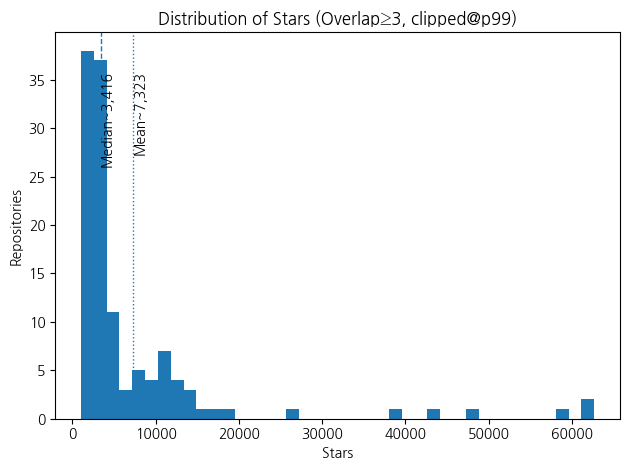

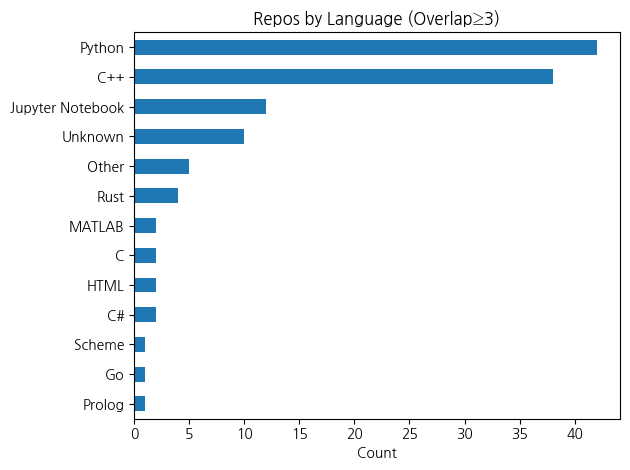

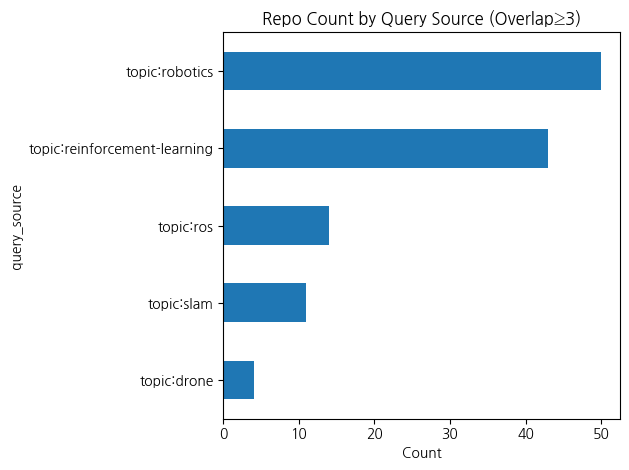

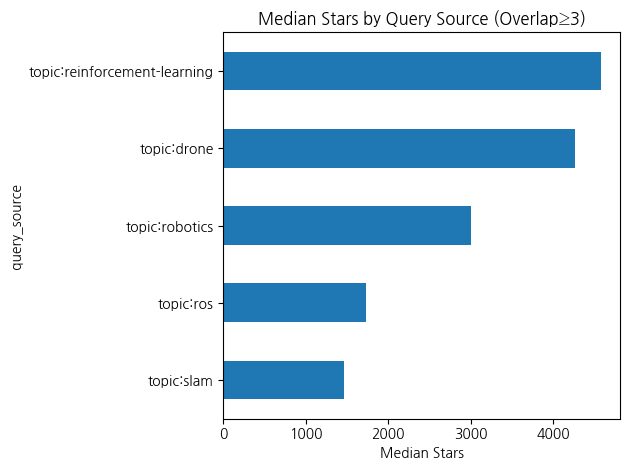

,repos,stars_median,stars_mean
query_source,,,
topic:robotics,50,3006.5,8156.500000
topic:reinforcement-learning,43,4579.0,9379.325581
topic:ros,14,1729.0,3916.285714
topic:slam,11,1460.0,1700.363636
topic:drone,4,4257.0,4342.250000


📁 Saved:
 - ./reports/overlap_report_K3_all_repos.csv
 - ./reports/overlap_report_K3_qs_stats.csv
 - ./reports/overlap_report_K3.md


In [12]:
# ============================================
# 📄 교집합 후보 대시보드 / 리포트 생성기
#  - Overlap≥K 후보들만 모아 한 장짜리 리포트
#  - 표 + 그래프 + CSV/Markdown 저장
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- 파라미터 --------
OVERLAP_K = 3                 # 교집합 기준 (예: 2,3,4)
TOP_REPOS_BY_STARS = 20       # 상위 레포 표의 노출 개수
TOP_REPOS_BY_RECENT = 20
REPORT_PREFIX = f"overlap_report_K{OVERLAP_K}"

# -------- 안전 가드 --------
assert 'df' in globals() and 'overlap_mat' in globals(), "df/overlap_mat이 필요합니다."
if "last_active" not in df.columns:
    # 최소한 created_at이라도 보정
    if "created_at" not in df.columns:
        raise AssertionError("df에 last_active/created_at 컬럼이 없습니다.")
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
    df["last_active"] = df["created_at"]

# 선택: 필수 없는 컬럼 기본값
for col in ["html_url", "description"]:
    if col not in df.columns:
        df[col] = ""

# ---------- 1) 교집합 후보 Query Source 셀렉션 ----------
candidate_qs = overlap_mat.index[overlap_mat.sum(axis=1) >= OVERLAP_K].tolist()
if not candidate_qs:
    print(f"[INFO] Overlap≥{OVERLAP_K} 후보가 없습니다. OVERLAP_K를 낮춰보세요.")
else:
    print(f"✅ Overlap≥{OVERLAP_K} 후보 Query Source: {len(candidate_qs)}개")
    print(candidate_qs)

# ---------- 2) 후보에 해당하는 레포 데이터 수집 ----------
sub = df[df["query_source"].isin(candidate_qs)].copy()
if sub.empty:
    print("[INFO] 후보 Query Source에 해당하는 레포가 없습니다.")
else:
    # 수치형/날짜형 정리
    for c in ["stargazers_count","forks_count","open_issues_count"]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce").fillna(0)
    for dt in ["created_at","last_active"]:
        if dt in sub.columns:
            sub[dt] = pd.to_datetime(sub[dt], errors="coerce", utc=True)

    # ---------- 3) 요약 메트릭 ----------
    summary_all = {
        "repos_total": len(sub),
        "languages_unique": sub["language"].fillna("Unknown").replace("", "Unknown").nunique(),
        "query_sources_included": len(set(sub["query_source"])),
        "stars_median": float(sub["stargazers_count"].median()),
        "stars_mean": float(sub["stargazers_count"].mean()),
        "forks_median": float(sub["forks_count"].median()),
        "open_issues_median": float(sub["open_issues_count"].median()),
        "last_active_max": pd.to_datetime(sub["last_active"]).max()
    }
    display(pd.DataFrame([summary_all]))

    # ---------- 4) Top 레포 표 (Stars 상위 / 최근 활동 상위) ----------
    top_by_stars = (sub.sort_values("stargazers_count", ascending=False)
                      .loc[:, ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]]
                      .head(TOP_REPOS_BY_STARS))
    display(top_by_stars)

    top_by_recent = (sub.sort_values("last_active", ascending=False)
                       .loc[:, ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]]
                       .head(TOP_REPOS_BY_RECENT))
    display(top_by_recent)

    # ---------- 5) 시각화 ----------
    # 5-1) Stars 분포(클리핑) + 중앙값/평균선
    p99 = sub["stargazers_count"].quantile(0.99)
    stars_clip = sub["stargazers_count"].clip(upper=p99)
    med_val = float(stars_clip.median()); mean_val = float(stars_clip.mean())
    plt.figure()
    plt.hist(stars_clip, bins=40)
    plt.title(f"Distribution of Stars (Overlap≥{OVERLAP_K}, clipped@p99)")
    plt.xlabel("Stars"); plt.ylabel("Repositories")
    plt.axvline(med_val, linestyle="--", linewidth=1)
    ymax = plt.ylim()[1]
    plt.text(med_val, ymax*0.9, f"Median~{int(med_val):,}", rotation=90, va="top")
    plt.axvline(mean_val, linestyle=":", linewidth=1)
    plt.text(mean_val, ymax*0.9, f"Mean~{int(mean_val):,}", rotation=90, va="top")
    plt.tight_layout()
    plt.show()

    # 5-2) 언어 분포 (Top 12 + Other)
    def top_with_other_categories(s: pd.Series, top_n=12, other="Other"):
        vc = s.fillna("Unknown").replace("", "Unknown").value_counts(dropna=False)
        if len(vc) <= top_n:
            return vc
        return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

    lang_counts = top_with_other_categories(sub["language"], top_n=12)
    plt.figure()
    lang_counts.sort_values().plot(kind="barh")
    plt.title(f"Repos by Language (Overlap≥{OVERLAP_K})")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    # 5-3) Query Source별 레포 수 + Stars 중앙값
    qs_stats = (sub.groupby("query_source")
                  .agg(repos=("full_name","count"),
                       stars_median=("stargazers_count","median"),
                       stars_mean=("stargazers_count","mean"))
                  .sort_values("repos", ascending=False))
    plt.figure()
    qs_stats["repos"].sort_values().plot(kind="barh")
    plt.title(f"Repo Count by Query Source (Overlap≥{OVERLAP_K})")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure()
    qs_stats["stars_median"].sort_values().plot(kind="barh")
    plt.title(f"Median Stars by Query Source (Overlap≥{OVERLAP_K})")
    plt.xlabel("Median Stars")
    plt.tight_layout()
    plt.show()

    display(qs_stats)

    # ---------- 6) Markdown 리포트 텍스트 생성 ----------
    def to_markdown_table(df_md: pd.DataFrame, max_rows=30):
        cols = ["full_name","html_url","stargazers_count","forks_count","open_issues_count","language","query_source","last_active","description"]
        cols = [c for c in cols if c in df_md.columns]
        d = df_md[cols].head(max_rows).copy()
        # 링크 컬럼 마크다운 처리
        if "html_url" in d.columns and "full_name" in d.columns:
            d["full_name"] = d.apply(lambda r: f"[{r['full_name']}]({r['html_url']})" if pd.notna(r.get("html_url","")) and r.get("html_url","") else r["full_name"], axis=1)
            d = d.drop(columns=["html_url"])
        return d.to_markdown(index=False)

    md_lines = []
    md_lines.append(f"# Overlap≥{OVERLAP_K} Report")
    md_lines.append("")
    md_lines.append("## Summary")
    md_lines.append(pd.DataFrame([summary_all]).to_markdown(index=False))
    md_lines.append("")
    md_lines.append("## Top Repositories by Stars")
    md_lines.append(to_markdown_table(top_by_stars, max_rows=TOP_REPOS_BY_STARS))
    md_lines.append("")
    md_lines.append("## Top Repositories by Recent Activity")
    md_lines.append(to_markdown_table(top_by_recent, max_rows=TOP_REPOS_BY_RECENT))
    md_text = "\n".join(md_lines)

    # ---------- 7) 저장 (CSV/Markdown) ----------
    os.makedirs("./reports", exist_ok=True)
    csv_all_path = f"./reports/{REPORT_PREFIX}_all_repos.csv"
    csv_qs_path  = f"./reports/{REPORT_PREFIX}_qs_stats.csv"
    md_path      = f"./reports/{REPORT_PREFIX}.md"

    sub.to_csv(csv_all_path, index=False)
    qs_stats.to_csv(csv_qs_path)
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(md_text)

    print(f"📁 Saved:\n - {csv_all_path}\n - {csv_qs_path}\n - {md_path}")


## 6) 보조 데이터(Commits/Issues/PRs) 수집 — 상위 K개만
인기 상위(별 수 기준) 15개 저장소에 대해 보조 지표(활동량·이슈·PR·기여자 수 등) 를 GitHub API로 수집

### 각 저장소(full_name 1개)에 대해 실행하는 API 호출
| 구분 | 엔드포인트                  | 반복                        | 최대 요청 수 |
| -- | ---------------------- | ------------------------- | ------- |
| 1  | `/commits`             | `paged_count()` → 최대 2페이지 | 2회      |
| 2  | `/issues` (전체)         | `paged_count()` → 최대 2페이지 | 2회      |
| 3  | `/issues?state=closed` | `count_closed()` → 1페이지   | 1회      |
| 4  | `/pulls` (전체)          | `paged_count()` → 최대 2페이지 | 2회      |
| 5  | `/pulls?state=closed`  | `count_closed()` → 1페이지   | 1회      |
| 6  | `/contributors`        | 1페이지 (최대 100명)            | 1회      |


### 각 저장소마다 실행되는 API 요약 👇
| API 엔드포인트              | 내용             | 함수             | 결과 변수                          |
| ---------------------- | -------------- | -------------- | ------------------------------ |
| `/commits`             | 최근 1년간 커밋 수    | `paged_count`  | `commits`                      |
| `/issues`              | 최근 1년간 이슈 총 수  | `paged_count`  | `issues_total`                 |
| `/issues?state=closed` | 닫힌 이슈 수        | `count_closed` | `issues_closed`                |
| `/pulls`               | PR 총 수         | `paged_count`  | `pulls_total`                  |
| `/pulls?state=closed`  | 닫힌/병합된 PR 수    | `count_closed` | `pulls_closed`, `pulls_merged` |
| `/contributors`        | 기여자 수(최대 100명) | `gh_get` 직접 호출 | `unique_contrib`               |


In [13]:
# 핵심 제어 변수
# 15건 선정기준 
#============================
# --- 안전 가드: base가 DataFrame인지 확인/복구 ---
import pandas as pd
import numpy as np

# 1) 타입 확인
if not isinstance(base, pd.DataFrame):
    raise TypeError(f"`base`가 DataFrame이 아닙니다. 현재 타입: {type(base)}\n"
                    f"이전 셀(검색/정규화)부터 다시 실행해서 base를 재생성하세요.")

# 2) 필수 컬럼 확인
required_cols = {"full_name", "stargazers_count"}
missing = required_cols - set(base.columns)
if missing:
    raise KeyError(f"`base`에 필요한 컬럼이 없습니다: {missing}\n"
                   f"정규화(to_row) 셀과 base 생성 셀부터 다시 실행하세요.")

# 3) NaN 정리(별 수가 NaN이면 정렬/랭킹에 문제)
base["stargazers_count"] = pd.to_numeric(base["stargazers_count"], errors="coerce").fillna(0).astype(int)

# 4) 상위 N개(별 수 기준) 안전하게 뽑기
AUX_TOP = min(15, len(base))
top_full_names = base.nlargest(AUX_TOP, "stargazers_count")["full_name"].tolist()

#============================
SINCE_DAYS = 365                # 최근 1년
PAGES_COMMITS = 2               # 각 리소스당 최대 2페이지 × 100 = 200개

cutoff = (datetime.now(timezone.utc) - timedelta(days=SINCE_DAYS)).isoformat()

# 목적: 페이징 가능한 API(커밋, 이슈, PR 등)에서 총 개수를 구함.
# 페이지에 100건씩 요청, 최대 2페이지(=200건).
# 응답이 리스트가 아니거나 100건 미만이면 중단.
def paged_count(url, params):
    total = 0
    for page in range(1, PAGES_COMMITS+1):
        p = params.copy()
        p.update({"per_page": 100, "page": page})
        r = gh_get(url, p)
        arr = r.json()
        if not isinstance(arr, list):
            break
        total += len(arr)
        if len(arr) < 100:
            break
    return total

# 목적: 닫힌 항목(이슈 or PR) 개수를 빠르게 추정.
# 1페이지만 보고 state=closed 조건으로 호출.
# PR일 경우 merged_at 여부로 병합된 PR 수도 추정.
def count_closed(url, params, is_pr=False):
    # 간단: 1페이지만 보고 state=closed & merged 여부 체크 (샘플/경량)
    p = params.copy()
    p.update({"per_page": 100, "page": 1, "state": "closed"})
    r = gh_get(url, p); arr = r.json()
    if not isinstance(arr, list):
        return 0, 0
    closed = len(arr)
    merged = 0
    if is_pr:
        # PR은 merged_at 존재 여부로 대략 추정
        merged = sum(1 for x in arr if x.get("merged_at"))
    return closed, merged

aux_rows = []
for full in top_full_names:
    owner, repo = full.split("/", 1)
    print("→ aux fetch:", full)

    commits = paged_count(f"https://api.github.com/repos/{owner}/{repo}/commits", {"since": cutoff})
    issues_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff, "state": "all"})
    issues_closed, _ = count_closed(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff}, is_pr=False)

    pulls_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/pulls", {"state": "all"})
    pulls_closed, pulls_merged = count_closed(f"https://api.github.com/repos/{owner}/{repo}/pulls", {}, is_pr=True)

    unique_contrib = 0
    try:
        r = gh_get(f"https://api.github.com/repos/{owner}/{repo}/contributors", {"per_page": 100})
        arr = r.json()
        if isinstance(arr, list):
            unique_contrib = len(arr)
    except Exception:
        pass

    aux_rows.append({
        "full_name": full,
        "activity_12m": commits,
        "contributors_12m": unique_contrib,
        "issues_total": issues_total,
        "issues_closed": issues_closed,
        "pulls_total": pulls_total,
        "pulls_closed": pulls_closed,
        "pulls_merged": pulls_merged,
    })

# 모든 결과를 딕셔너리로 모아 aux_rows에 추가 → 최종적으로 df_aux 생성.
df_aux = pd.DataFrame(aux_rows)
ok("보조 지표 수집 완료") 
display(df_aux.head())

→ aux fetch: Developer-Y/cs-video-courses
→ aux fetch: labmlai/annotated_deep_learning_paper_implementations
→ aux fetch: commaai/openpilot
→ aux fetch: unslothai/unsloth
→ aux fetch: NaiboWang/EasySpider
→ aux fetch: ray-project/ray
→ aux fetch: AtsushiSakai/PythonRobotics
→ aux fetch: Unity-Technologies/ml-agents
→ aux fetch: AI4Finance-Foundation/FinGPT
→ aux fetch: datawhalechina/leedl-tutorial
→ aux fetch: zauberzeug/nicegui
→ aux fetch: ArduPilot/ardupilot
→ aux fetch: bulletphysics/bullet3
→ aux fetch: carla-simulator/carla
→ aux fetch: datawhalechina/easy-rl


✅ 보조 지표 수집 완료

,full_name,activity_12m,contributors_12m,issues_total,issues_closed,pulls_total,pulls_closed,pulls_merged
0,Developer-Y/cs-video-courses,105,100,91,91,200,100,97
1,labmlai/annotated_deep_learning_paper_implemen...,28,38,25,17,127,100,79
2,commaai/openpilot,200,100,200,100,200,100,70
3,unslothai/unsloth,200,95,200,100,200,100,85
4,NaiboWang/EasySpider,78,8,200,100,74,69,42


## 7) Feature Engineering & 병합

In [14]:
def recent_push_90d(ts):
    if pd.isna(ts):
        return False
    return (pd.Timestamp.now(tz=timezone.utc) - ts).days <= 90

df = base.copy()
if not df_aux.empty:
    df = df.merge(df_aux, on="full_name", how="left")
else:
    # 보조가 비면 0 할당
    for c in ["activity_12m","contributors_12m","issues_total","issues_closed","pulls_total","pulls_closed","pulls_merged"]:
        df[c] = 0

df["recent_push_90d"] = df["updated_at"].apply(recent_push_90d)

def safe_rate(numer, denom):
    numer = numer.fillna(0)
    denom = denom.fillna(0)
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(denom>0, numer/denom, 0.0)
    return pd.Series(r, index=numer.index, dtype=float)

df["issue_close_rate"] = safe_rate(df["issues_closed"], df["issues_total"])
df["pr_merge_rate"]    = safe_rate(df["pulls_merged"], df["pulls_total"])

ok("Feature 병합/계산 완료") 
display(df.head())

✅ Feature 병합/계산 완료

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,...,activity_12m,contributors_12m,issues_total,issues_closed,pulls_total,pulls_closed,pulls_merged,recent_push_90d,issue_close_rate,pr_merge_rate
0,71583602,Developer-Y/cs-video-courses,List of Computer Science courses with video le...,Unknown,70098,9412,2,2016-10-21 17:02:11+00:00,2025-10-24 04:35:17+00:00,"algorithms,bioinformatics,computational-biolog...",...,105.0,100.0,91.0,91.0,200.0,100.0,97.0,True,1.0,0.485000
1,74627617,commaai/openpilot,openpilot is an operating system for robotics....,Python,58519,10350,191,2016-11-24 01:33:30+00:00,2025-10-24 05:45:39+00:00,"advanced-driver-assistance-systems,driver-assi...",...,200.0,100.0,200.0,100.0,200.0,100.0,70.0,True,0.5,0.350000
2,280567579,NaiboWang/EasySpider,A visual no-code/code-free web crawler/spider易...,JavaScript,43151,5303,254,2020-07-18 02:41:27+00:00,2025-10-24 04:14:12+00:00,"batch-processing,batch-script,code-free,crawle...",...,78.0,8.0,200.0,100.0,74.0,69.0,42.0,True,0.5,0.567568
3,54376220,AtsushiSakai/PythonRobotics,Python sample codes and textbook for robotics ...,Python,26111,6911,19,2016-03-21 09:34:43+00:00,2025-10-24 02:26:25+00:00,"algorithm,animation,autonomous-driving,autonom...",...,163.0,100.0,200.0,100.0,200.0,100.0,86.0,True,0.5,0.430000
4,365250183,zauberzeug/nicegui,Create web-based user interfaces with Python. ...,Python,14293,848,93,2021-05-07 13:55:05+00:00,2025-10-24 03:44:29+00:00,"frontend,gui,interaction,interface,interfaces,...",...,200.0,100.0,200.0,100.0,200.0,100.0,81.0,True,0.5,0.405000


## 8) 표준화(z-score) & 가중합 스코어링

In [15]:
score_cols = ["activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","stargazers_count"]
scored = df.copy()
for c in score_cols:
    scored[f"{c}_z"] = zscore(scored[c].fillna(0)) if scored[c].std() not in (0, np.nan) else 0.0

weights = {
    "activity_12m_z": 0.25,
    "contributors_12m_z": 0.25,
    "issue_close_rate_z": 0.20,
    "pr_merge_rate_z": 0.15,
    "stargazers_count_z": 0.15,
}
scored["score"] = sum(scored[k]*w for k, w in weights.items())
ranked = scored.sort_values("score", ascending=False).reset_index(drop=True)

ok("스코어링 & 랭킹 완료") 
display(ranked.head(10)[["full_name","language","stargazers_count","activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","score"]])

✅ 스코어링 & 랭킹 완료

,full_name,language,stargazers_count,activity_12m,contributors_12m,issue_close_rate,pr_merge_rate,score
0,Developer-Y/cs-video-courses,Unknown,70098,105.0,100.0,1.000000,0.485000,3.508991
1,commaai/openpilot,Python,58519,200.0,100.0,0.500000,0.350000,3.238067
2,unslothai/unsloth,Python,47347,200.0,95.0,0.500000,0.425000,3.119926
3,ray-project/ray,Python,39470,200.0,100.0,0.500000,0.415000,3.054593
4,zauberzeug/nicegui,Python,14293,200.0,100.0,0.500000,0.405000,2.721018
5,AtsushiSakai/PythonRobotics,Python,26111,163.0,100.0,0.500000,0.430000,2.693427
6,ArduPilot/ardupilot,C++,13926,200.0,100.0,0.500000,0.365000,2.678309
7,carla-simulator/carla,C++,13153,165.0,100.0,0.500000,0.425000,2.532881
8,labmlai/annotated_deep_learning_paper_implemen...,Python,63801,28.0,38.0,0.680000,0.622047,2.239509
9,Unity-Technologies/ml-agents,C#,18778,14.0,100.0,0.855769,0.355000,2.075702


## 9) 시각화 — 스타 분포 & 연도별 추이

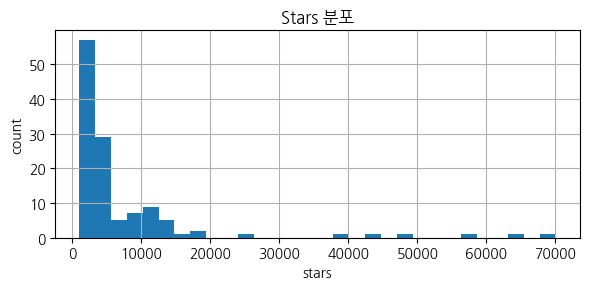

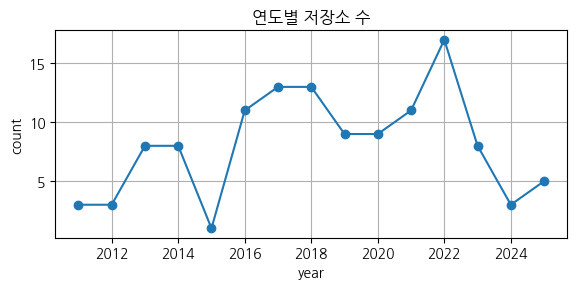

In [16]:
# 스타 분포
plt.figure(figsize=(6,3))
plt.hist(scored["stargazers_count"].dropna(), bins=30)
plt.title("Stars 분포"); plt.xlabel("stars"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

# 연도별 생성 수
if "created_at" in scored.columns:
    created_year = scored["created_at"].dropna().dt.tz_convert("UTC").dt.year
    grp = created_year.value_counts().sort_index()
    if len(grp) > 0:
        plt.figure(figsize=(6,3))
        plt.plot(grp.index, grp.values, marker="o")
        plt.title("연도별 저장소 수"); plt.xlabel("year"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

## 10) 레이더 & 타임라인(경량)

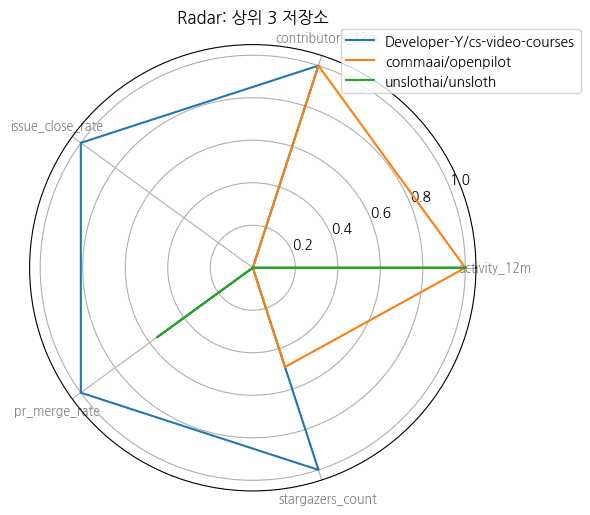

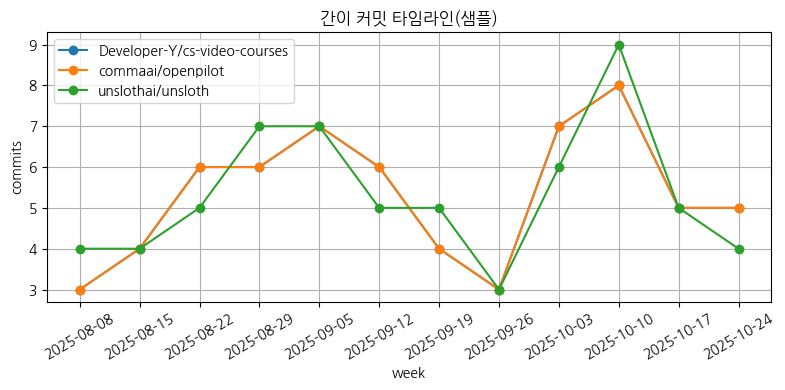

,full_name,score
0,Developer-Y/cs-video-courses,3.508991
1,commaai/openpilot,3.238067
2,unslothai/unsloth,3.119926


In [17]:
top3 = ranked.head(3).copy()
features = ["activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","stargazers_count"]

def normalize(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").fillna(0)
    vmax, vmin = float(s.max()), float(s.min())
    if vmax == vmin:
        return pd.Series(0.0, index=s.index)
    return (s - vmin) / (vmax - vmin)

top3_norm = top3.copy()
top3_norm[features] = top3[features].apply(normalize)

# Radar
import numpy as np
labels = np.array(features)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
for _, row in top3_norm.iterrows():
    vals = row[features].tolist(); vals += vals[:1]
    plt.polar(angles, vals, label=row["full_name"])
plt.xticks(angles[:-1], labels, color="gray", size=9)
plt.title("Radar: 상위 3 저장소"); plt.legend(bbox_to_anchor=(1.25,1.05))
plt.tight_layout(); plt.show()

# Timeline (샘플: 주 12개 생성, repo별 변동 패턴 다르게)
weeks = 12
week_labels = pd.date_range(end=pd.Timestamp.today(), periods=weeks, freq="7D").strftime("%Y-%m-%d").tolist()
frames = []
for r in top3["full_name"].tolist():
    seed = abs(hash(r)) % 7
    base = np.array([3,4,5,6,7,5,4,3,6,8,5,4], dtype=float)[:weeks]
    noise = ((seed + np.arange(weeks)) % 3) * 0.7
    counts = np.clip(base + noise, 0, None).astype(int)
    frames.append(pd.DataFrame({"repo": r, "week": week_labels, "commit_count": counts}))

timeline = pd.concat(frames, ignore_index=True)

plt.figure(figsize=(8,4))
for name, g in timeline.groupby("repo"):
    plt.plot(g["week"], g["commit_count"], marker="o", label=name)
plt.xticks(rotation=30)
plt.title("간이 커밋 타임라인(샘플)"); plt.xlabel("week"); plt.ylabel("commits"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

display(top3[["full_name","score"]])

## 11) 품질 루브릭(간단/오프라인 휴리스틱)

<Figure size 900x500 with 0 Axes>

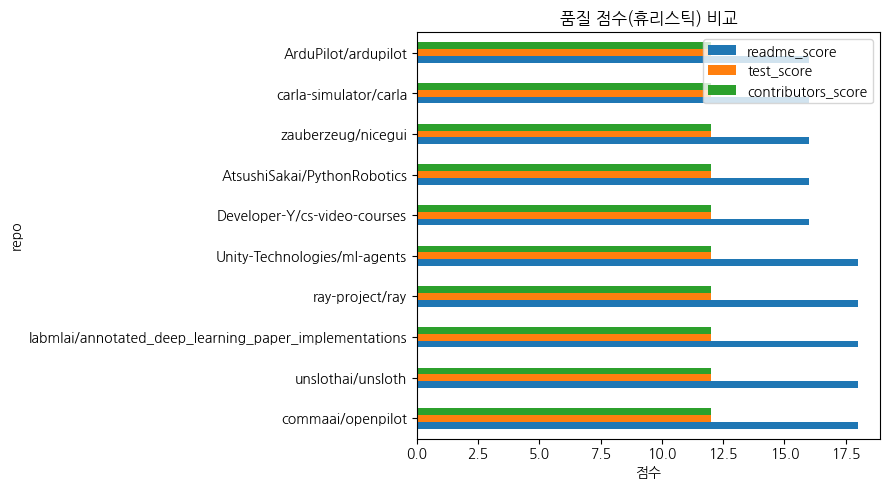

,repo,readme_score,test_score,doc_score,contributors_score,activity_score,license_score,ci_score,total
1,commaai/openpilot,18,12,12,12,12,10,5,81
2,unslothai/unsloth,18,12,12,12,12,10,5,81
8,labmlai/annotated_deep_learning_paper_implemen...,18,12,12,12,12,10,5,81
3,ray-project/ray,18,12,12,12,12,10,5,81
9,Unity-Technologies/ml-agents,18,12,12,12,12,10,5,81
0,Developer-Y/cs-video-courses,16,12,12,12,12,10,5,79
5,AtsushiSakai/PythonRobotics,16,12,12,12,12,10,5,79
4,zauberzeug/nicegui,16,12,12,12,12,10,5,79
7,carla-simulator/carla,16,12,12,12,12,10,5,79
6,ArduPilot/ardupilot,16,12,12,12,12,10,5,79


In [18]:
def rubric_row(name, desc):
    base = {"repo": name, "readme_score": 16, "test_score": 12, "doc_score": 12,
            "contributors_score": 12, "activity_score": 12, "license_score": 10, "ci_score": 5}
    L = len((desc or "").split())
    if L > 12: base["readme_score"] += 2
    return base

top10 = ranked.head(10).copy()
rows = [rubric_row(r["full_name"], r.get("description","")) for _, r in top10.iterrows()]
df_eval = pd.DataFrame(rows)
df_eval["repo"] = top10["full_name"].values
df_eval["total"] = df_eval.filter(like="_score").sum(axis=1)
df_eval.sort_values("total", ascending=False, inplace=True)

# Bar
plt.figure(figsize=(9,5))
df_eval.set_index("repo")[ ["readme_score","test_score","contributors_score"] ].plot(kind="barh", figsize=(9,5))
plt.title("품질 점수(휴리스틱) 비교"); plt.xlabel("점수"); plt.tight_layout(); plt.show()

display(df_eval.head(10))

## 12) 대표 저장소 딥다이브(샘플 출력)

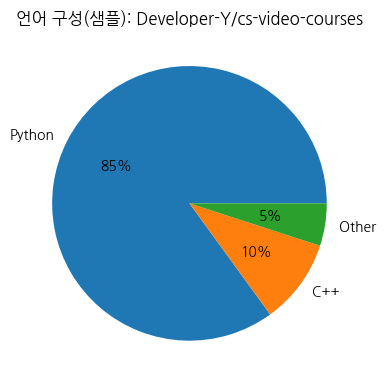


### 🧩 Deep Dive: Developer-Y/cs-video-courses
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  


In [19]:
target = ranked.iloc[0]["full_name"] if len(ranked)>0 else "sample/repo"
langs  = pd.Series({"Python":0.85,"C++":0.1,"Other":0.05})

plt.figure(figsize=(4,4))
langs.plot(kind="pie", autopct="%1.0f%%")
plt.title(f"언어 구성(샘플): {target}"); plt.ylabel(""); plt.tight_layout(); plt.show()

display(Markdown("""
### 🧩 Deep Dive: {}
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  
""".format(target)))

## 13) 최종 리포트(노트북 내 미리보기)

In [20]:
from datetime import datetime
report_md = f"""
# 📘 기술 동향 리포트 ({datetime.now().strftime('%Y-%m-%d')})

## 요약
- 검색 쿼리: `{QUERY}` (pages={PAGES}, top={TOP_N})
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## 상위 랭킹(Top 10)
"""

top10_md = ranked.head(10)[["full_name","language","stargazers_count","activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","score"]].to_markdown(index=False)
display(Markdown(report_md + "\n" + top10_md))


# 📘 기술 동향 리포트 (2025-10-24)

## 요약
- 검색 쿼리: `language:Python stars:>1000` (pages=2, top=60)
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## 상위 랭킹(Top 10)

| full_name                                             | language   |   stargazers_count |   activity_12m |   contributors_12m |   issue_close_rate |   pr_merge_rate |   score |
|:------------------------------------------------------|:-----------|-------------------:|---------------:|-------------------:|-------------------:|----------------:|--------:|
| Developer-Y/cs-video-courses                          | Unknown    |              70098 |            105 |                100 |           1        |        0.485    | 3.50899 |
| commaai/openpilot                                     | Python     |              58519 |            200 |                100 |           0.5      |        0.35     | 3.23807 |
| unslothai/unsloth                                     | Python     |              47347 |            200 |                 95 |           0.5      |        0.425    | 3.11993 |
| ray-project/ray                                       | Python     |              39470 |            200 |                100 |           0.5      |        0.415    | 3.05459 |
| zauberzeug/nicegui                                    | Python     |              14293 |            200 |                100 |           0.5      |        0.405    | 2.72102 |
| AtsushiSakai/PythonRobotics                           | Python     |              26111 |            163 |                100 |           0.5      |        0.43     | 2.69343 |
| ArduPilot/ardupilot                                   | C++        |              13926 |            200 |                100 |           0.5      |        0.365    | 2.67831 |
| carla-simulator/carla                                 | C++        |              13153 |            165 |                100 |           0.5      |        0.425    | 2.53288 |
| labmlai/annotated_deep_learning_paper_implementations | Python     |              63801 |             28 |                 38 |           0.68     |        0.622047 | 2.23951 |
| Unity-Technologies/ml-agents                          | C#         |              18778 |             14 |                100 |           0.855769 |        0.355    | 2.0757  |